In [2]:
import gymnasium as gym
import os
#import gym
import numpy as np

import collections
import pickle
import tqdm
from stable_baselines3 import PPO


import sys
import random
import csv
from datetime import datetime

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import time
import cv2
#del os.environ["IMAGEIO_FFMPEG_EXE"]
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/local/bin"
#from moviepy.editor import *

import yaml
from copy import deepcopy
from Utilities.data_util import *
from Utilities.Transformer import *
import utils_gym

import matplotlib.pyplot as plt
from typing import Optional

%load_ext autoreload
%autoreload 2

In [3]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
#

In [4]:

datasets = []

data_dir = "./data"

print(data_dir)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

env_name_list = ['MountainCar-v0','Taxi-v3','FrozenLake-v1','CliffWalking-v0']#,'LunarLander-v2','CarRacing-v2']

experiment_list  = {i:{'env_name':i,
                      'path' : os.path.join(data_dir, i),
                       'env': gym.make(i)
                      } for i in env_name_list}



if 'CarRacing-v2' in env_name_list:
    experiment_list['CarRacing-v2']['env'] = gym.make('CarRacing-v2',continuous=False)

model_ppo_env_configurations = {

'MountainCar-v0' : {'learning_rate': 0.001 
                    ,'gamma': 0.99
                    ,'vf_coef': 0.5
                    ,'ent_coef': 0.001
                    ,'n_epochs': 20
                    ,'batch_size': 32 }
    ,
'Taxi-v3' : {'learning_rate': 0.001
                    ,'gamma': 0.99
                    ,'vf_coef': 0.5
                    ,'ent_coef': 0.01
                    ,'n_epochs': 10
                    ,'batch_size': 16 }
    ,
'FrozenLake-v1' : {'learning_rate': 0.001 
                    ,'gamma': 0.99
                    ,'vf_coef': 0.5
                    ,'ent_coef': 0.1
                    ,'n_epochs': 10
                    ,'batch_size': 16 }
    ,
'CliffWalking-v0' : {'learning_rate': 0.001 
                    ,'gamma': 0.99
                    ,'vf_coef': 0.5
                    ,'ent_coef': 0.1
                    ,'n_epochs': 10
                    ,'batch_size': 16 } ,
'LunarLander-v2':{'learning_rate': 0.001 
                    ,'gamma': 0.99
                    ,'vf_coef': 0.5
                    ,'ent_coef': 0.001
                    ,'n_epochs': 20
                    ,'batch_size': 32 
                 },

'CarRacing-v2' : {'learning_rate': 0.005
                    ,'gamma': 0.99
                    ,'vf_coef': 0.5
                    ,'ent_coef': 0.01
                    ,'vf_coef':0.5
                    ,'n_epochs': 10
                    ,'batch_size': 128 
                 }
    
    
}


env_max_episode_steps = {
                'MountainCar-v0': 300
                ,'LunarLander-v2': 500
                ,'CarRacing-v2' :300
                ,'Taxi-v3': 300
                ,'FrozenLake-v1': 300
                ,'CliffWalking-v0': 300 }


env_timesteps = {
                'MountainCar-v0': 500000
                ,'LunarLander-v2': 500000
                ,'CarRacing-v2' :500000
                ,'Taxi-v3': 400000
                ,'FrozenLake-v1': 200000
                ,'CliffWalking-v0': 80000 }

model_list = {i:None for i in env_name_list}


def train_sb3(env,policy,total_timesteps=500000,config = {'verbose':0}):
    #env = gym.make(env_name)
    model = policy("MlpPolicy", env, **config).learn(total_timesteps=total_timesteps)
    return model

def visual_iter_sb3(env,model,max_episode_steps = 1000,render_mode = 'human',cast=None,verbose = False):
    #env = gym.make(env_name,render_mode = render_mode,max_episode_steps=max_episode_steps)
    obs,_ = env.reset()
    #action_type = type(env.action_space.sample())
    for i in range(max_episode_steps):
        action, _states = model.predict(obs)
        
        if cast != None:
            action = cast(action)
        #print(action,type(action))
        obs, rewards, t,t_, info = env.step(action)
        print(action,rewards)
        env.render()
        if t or t_:
            print(i)
            break
    env.close()

#reward_fn = (lambda terminated,truncated: 1 if terminated else (-1 if truncated else 0) )

reward_fn = (lambda terminated,truncated: 1 if terminated else (-1 if truncated else 0) )
reward_fn = (lambda terminated,truncated: 1 if terminated else (1 if truncated else 0) )

./data


In [5]:
env_name = env_name_list[0]#'CartPole-v1'
print("processing: ", env_name)
#name = env_name#f'{env_name}'
pkl_file_path = experiment_list[env_name]['path']
env =  experiment_list[env_name]['env']

processing:  MountainCar-v0


In [6]:
for i in experiment_list:
    s =experiment_list[i]['env'].action_space.sample()
    print(i,s,type(s))

MountainCar-v0 1 <class 'numpy.int64'>
Taxi-v3 0 <class 'numpy.int64'>
FrozenLake-v1 3 <class 'numpy.int64'>
CliffWalking-v0 3 <class 'numpy.int64'>


In [7]:
env_ = gym.make(env_name,max_episode_steps=200)

class model_class_3(type(env_)):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.state_list = np.zeros((3,2))
    def step(self,action):
        

        observation, reward, terminated, truncated, info = super().step(action)#self.env.step(action)
        self._elapsed_steps += 1

        if self._elapsed_steps >= self._max_episode_steps:
            truncated = True
        self.state_list[:2,:] = self.state_list[1:,:]
        self.state_list[2,:] = observation
        info['observation'] = observation
        return self.state_list, reward, terminated, truncated, info
        
    def reset(
            self,
            *,
            seed: Optional[int] = None,
            options: Optional[dict] = None,
            default = False,
            
            init_state=[-5,0]
                    ):
            super().reset(seed=seed)
            # Note that if you use custom reset bounds, it may lead to out-of-bound
            # state/observations.
            if default:
                low, high = utils_gym.maybe_parse_reset_bounds(options, -0.6, -0.4)
                self.state = np.array([self.np_random.uniform(low=low, high=high), 0])
            else:
                self.state = np.array(init_state)
    
            if self.render_mode == "human":
                self.render()

            self.state_list = np.array([self.state],dtype=np.float32).repeat(3,axis =0)
            

        
            return self.state_list, {'observation':self.state}


env_fun = model_class_3(env = env,max_episode_steps=200)





In [6]:
#PPO??
#env_??

In [67]:
selected_config = model_ppo_env_configurations[env_name]
selected_config['n_epochs']=1

model_ppo_test = train_sb3(env_fun,policy=PPO,total_timesteps=1000,config = {'verbose':0}|selected_config)

ValueError: could not broadcast input array from shape (3,2) into shape (2,)

In [ ]:
if False:

    for i in [5]:
    
        env_name = env_name_list[i]#'CartPole-v1'
        print("processing: ", env_name)
        #name = env_name#f'{env_name}'
        pkl_file_path = experiment_list[env_name]['path']
        env =  experiment_list[env_name]['env']
        
        selected_config = model_ppo_env_configurations[env_name]
        
        model_list[env_name] = train_sb3(env,policy=PPO,total_timesteps=env_timesteps[env_name],config = {'verbose':0}|selected_config)
        
        model_list[env_name].save("./data/"+env_name+"_model.zip")
        

        if i ==5:
            env = gym.make(env_name,max_episode_steps=env_max_episode_steps[env_name],continuous=False)
            path_ret = get_dataset(env,episode_count=1000,model=model_list[env_name],time_lim = env_timesteps[env_name], random=0.95,reward_fn=reward_fn,pkl_file_path=pkl_file_path,cast = int)
        else:
            env = gym.make(env_name,max_episode_steps=env_max_episode_steps[env_name])
        #model = PPO("MlpPolicy", env, verbose=0).learn(total_timesteps=200000)
            path_ret = get_dataset(env,episode_count=1000,model=model_list[env_name],time_lim = env_timesteps[env_name], random=0.95,reward_fn=reward_fn,pkl_file_path=pkl_file_path,cast = int)

processing:  CarRacing-v2


  0%|                                          | 1/1000 [00:00<16:34,  1.00it/s]

True False False 263


  0%|                                          | 2/1000 [00:02<16:50,  1.01s/it]

True False False 273


  0%|▏                                         | 3/1000 [00:03<16:47,  1.01s/it]

True False False 297


  0%|▏                                         | 4/1000 [00:04<16:54,  1.02s/it]

True False False 279


  0%|▏                                         | 5/1000 [00:05<16:34,  1.00it/s]

True False False 283


  1%|▎                                         | 6/1000 [00:06<16:28,  1.01it/s]

True False False 296


  1%|▎                                         | 7/1000 [00:06<16:14,  1.02it/s]

True False False 273


  1%|▎                                         | 8/1000 [00:08<16:52,  1.02s/it]

True False False 302


  1%|▍                                         | 9/1000 [00:09<16:25,  1.01it/s]

True False False 271


  1%|▍                                        | 10/1000 [00:09<15:53,  1.04it/s]

True False False 257


  1%|▍                                        | 11/1000 [00:10<15:52,  1.04it/s]

True False False 287


  1%|▍                                        | 12/1000 [00:11<16:18,  1.01it/s]

True False False 295


  1%|▌                                        | 13/1000 [00:12<16:35,  1.01s/it]

True False False 293


  1%|▌                                        | 14/1000 [00:13<16:09,  1.02it/s]

True False False 273


  2%|▌                                        | 15/1000 [00:14<15:49,  1.04it/s]

True False False 274


  2%|▋                                        | 16/1000 [00:15<15:50,  1.04it/s]

True False False 268


  2%|▋                                        | 17/1000 [00:16<15:50,  1.03it/s]

True False False 275


  2%|▋                                        | 18/1000 [00:17<15:13,  1.07it/s]

True False False 253


  2%|▊                                        | 19/1000 [00:18<14:57,  1.09it/s]

True False False 257


  2%|▊                                        | 20/1000 [00:19<15:30,  1.05it/s]

True False False 270


  2%|▊                                        | 21/1000 [00:20<15:32,  1.05it/s]

True False False 270


  2%|▉                                        | 22/1000 [00:21<15:08,  1.08it/s]

True False False 260


  2%|▉                                        | 23/1000 [00:22<15:01,  1.08it/s]

True False False 270


  2%|▉                                        | 24/1000 [00:23<15:29,  1.05it/s]

True False False 289


  2%|█                                        | 25/1000 [00:24<15:26,  1.05it/s]

True False False 277


  3%|█                                        | 26/1000 [00:25<15:20,  1.06it/s]

True False False 265


  3%|█                                        | 27/1000 [00:26<15:25,  1.05it/s]

True False False 275


  3%|█▏                                       | 28/1000 [00:27<15:46,  1.03it/s]

True False False 266


  3%|█▏                                       | 29/1000 [00:28<15:40,  1.03it/s]

True False False 260


  3%|█▏                                       | 30/1000 [00:29<15:54,  1.02it/s]

True False False 274


  3%|█▎                                       | 31/1000 [00:30<15:41,  1.03it/s]

True False False 269


  3%|█▎                                       | 32/1000 [00:30<15:17,  1.06it/s]

True False False 264


  3%|█▎                                       | 33/1000 [00:32<15:59,  1.01it/s]

True False False 281


  3%|█▍                                       | 34/1000 [00:33<15:49,  1.02it/s]

True False False 281


  4%|█▍                                       | 35/1000 [00:33<15:34,  1.03it/s]

True False False 274


  4%|█▍                                       | 36/1000 [00:34<15:20,  1.05it/s]

True False False 274


  4%|█▌                                       | 37/1000 [00:35<15:20,  1.05it/s]

True False False 272


  4%|█▌                                       | 38/1000 [00:36<15:21,  1.04it/s]

True False False 285


  4%|█▌                                       | 39/1000 [00:37<15:38,  1.02it/s]

True False False 285


  4%|█▋                                       | 40/1000 [00:38<15:15,  1.05it/s]

True False False 268


  4%|█▋                                       | 41/1000 [00:39<15:24,  1.04it/s]

True False False 274


  4%|█▋                                       | 42/1000 [00:40<15:21,  1.04it/s]

True False False 259


  4%|█▊                                       | 43/1000 [00:41<16:48,  1.05s/it]

True False False 269


  4%|█▊                                       | 44/1000 [00:42<16:48,  1.06s/it]

True False False 299


  4%|█▊                                       | 45/1000 [00:43<16:21,  1.03s/it]

True False False 263


  5%|█▉                                       | 46/1000 [00:44<15:53,  1.00it/s]

True False False 273


  5%|█▉                                       | 47/1000 [00:45<15:22,  1.03it/s]

True False False 269


  5%|█▉                                       | 48/1000 [00:46<15:18,  1.04it/s]

True False False 290


  5%|██                                       | 49/1000 [00:47<15:23,  1.03it/s]

True False False 289


  5%|██                                       | 50/1000 [00:48<15:22,  1.03it/s]

True False False 253


  5%|██                                       | 51/1000 [00:49<15:26,  1.02it/s]

True False False 272


  5%|██▏                                      | 52/1000 [00:50<15:57,  1.01s/it]

True False False 268


  5%|██▏                                      | 53/1000 [00:51<15:46,  1.00it/s]

True False False 285


  5%|██▏                                      | 54/1000 [00:52<15:19,  1.03it/s]

True False False 267


  6%|██▎                                      | 55/1000 [00:53<15:16,  1.03it/s]

True False False 288


  6%|██▎                                      | 56/1000 [00:54<15:27,  1.02it/s]

True False False 270


  6%|██▎                                      | 57/1000 [00:55<15:41,  1.00it/s]

True False False 277


  6%|██▍                                      | 58/1000 [00:56<15:32,  1.01it/s]

True False False 280


  6%|██▍                                      | 59/1000 [00:57<15:53,  1.01s/it]

True False False 259


  6%|██▍                                      | 60/1000 [00:58<16:06,  1.03s/it]

True False False 272


  6%|██▌                                      | 61/1000 [00:59<15:48,  1.01s/it]

True False False 260


  6%|██▌                                      | 62/1000 [01:00<15:22,  1.02it/s]

True False False 263


  6%|██▌                                      | 63/1000 [01:01<15:21,  1.02it/s]

True False False 274


  6%|██▌                                      | 64/1000 [01:02<16:21,  1.05s/it]

True False False 299


  6%|██▋                                      | 65/1000 [01:04<17:26,  1.12s/it]

True False False 271


  7%|██▋                                      | 66/1000 [01:05<16:33,  1.06s/it]

True False False 265


  7%|██▋                                      | 67/1000 [01:05<15:48,  1.02s/it]

True False False 270


  7%|██▊                                      | 68/1000 [01:06<15:23,  1.01it/s]

True False False 258


  7%|██▊                                      | 69/1000 [01:07<15:31,  1.00s/it]

True False False 263


  7%|██▊                                      | 70/1000 [01:09<17:58,  1.16s/it]

True False False 279


  7%|██▉                                      | 71/1000 [01:10<17:43,  1.14s/it]

True False False 269


  7%|██▉                                      | 72/1000 [01:11<18:20,  1.19s/it]

True False False 255


  7%|██▉                                      | 73/1000 [01:13<19:02,  1.23s/it]

True False False 293


  7%|███                                      | 74/1000 [01:14<20:59,  1.36s/it]

True False False 255


  8%|███                                      | 75/1000 [01:16<23:12,  1.51s/it]

True False False 273


  8%|███                                      | 76/1000 [01:18<24:58,  1.62s/it]

True False False 276


  8%|███▏                                     | 77/1000 [01:20<24:25,  1.59s/it]

True False False 267


  8%|███▏                                     | 78/1000 [01:21<22:16,  1.45s/it]

True False False 269


  8%|███▏                                     | 79/1000 [01:22<20:12,  1.32s/it]

True False False 260


  8%|███▎                                     | 80/1000 [01:23<18:12,  1.19s/it]

True False False 251


  8%|███▎                                     | 81/1000 [01:24<17:58,  1.17s/it]

True False False 292


  8%|███▎                                     | 82/1000 [01:25<17:25,  1.14s/it]

True False False 274


  8%|███▍                                     | 83/1000 [01:26<17:06,  1.12s/it]

True False False 258


  8%|███▍                                     | 84/1000 [01:27<17:25,  1.14s/it]

True False False 277


  8%|███▍                                     | 85/1000 [01:28<17:22,  1.14s/it]

True False False 266


  9%|███▌                                     | 86/1000 [01:29<17:46,  1.17s/it]

True False False 261


  9%|███▌                                     | 87/1000 [01:31<19:40,  1.29s/it]

True False False 283


  9%|███▌                                     | 88/1000 [01:33<24:09,  1.59s/it]

True False False 264


  9%|███▋                                     | 89/1000 [01:35<24:31,  1.62s/it]

True False False 258


  9%|███▋                                     | 90/1000 [01:36<23:08,  1.53s/it]

True False False 258


  9%|███▋                                     | 91/1000 [01:38<22:22,  1.48s/it]

True False False 255


  9%|███▊                                     | 92/1000 [01:39<22:05,  1.46s/it]

True False False 262


  9%|███▊                                     | 93/1000 [01:41<22:25,  1.48s/it]

True False False 274


  9%|███▊                                     | 94/1000 [01:43<26:43,  1.77s/it]

True False False 264


 10%|███▉                                     | 95/1000 [01:45<27:05,  1.80s/it]

True False False 288


 10%|███▉                                     | 96/1000 [01:46<24:44,  1.64s/it]

True False False 274


 10%|███▉                                     | 97/1000 [01:47<22:56,  1.52s/it]

True False False 294


 10%|████                                     | 98/1000 [01:48<20:25,  1.36s/it]

True False False 264


 10%|████                                     | 99/1000 [01:49<18:29,  1.23s/it]

True False False 270


 10%|████                                    | 100/1000 [01:50<17:27,  1.16s/it]

True False False 268


 10%|████                                    | 101/1000 [01:52<17:41,  1.18s/it]

True False False 276


 10%|████                                    | 102/1000 [01:53<17:17,  1.16s/it]

True False False 271


 10%|████                                    | 103/1000 [01:54<16:21,  1.09s/it]

True False False 273


 10%|████▏                                   | 104/1000 [01:55<16:29,  1.10s/it]

True False False 302


 10%|████▏                                   | 105/1000 [01:56<16:23,  1.10s/it]

True False False 285


 11%|████▏                                   | 106/1000 [01:57<15:31,  1.04s/it]

True False False 267


 11%|████▎                                   | 107/1000 [01:58<15:10,  1.02s/it]

True False False 287


 11%|████▎                                   | 108/1000 [01:59<14:52,  1.00s/it]

True False False 253


 11%|████▎                                   | 109/1000 [02:00<15:06,  1.02s/it]

True False False 260


 11%|████▍                                   | 110/1000 [02:01<14:48,  1.00it/s]

True False False 260


 11%|████▍                                   | 111/1000 [02:02<14:32,  1.02it/s]

True False False 262


 11%|████▍                                   | 112/1000 [02:03<14:12,  1.04it/s]

True False False 262


 11%|████▌                                   | 113/1000 [02:04<14:50,  1.00s/it]

True False False 255


 11%|████▌                                   | 114/1000 [02:05<15:16,  1.03s/it]

True False False 260


 12%|████▌                                   | 115/1000 [02:06<15:40,  1.06s/it]

True False False 262


 12%|████▋                                   | 116/1000 [02:07<16:01,  1.09s/it]

True False False 258


 12%|████▋                                   | 117/1000 [02:08<15:51,  1.08s/it]

True False False 262


 12%|████▋                                   | 118/1000 [02:09<15:14,  1.04s/it]

True False False 268


 12%|████▊                                   | 119/1000 [02:10<15:21,  1.05s/it]

True False False 310


 12%|████▊                                   | 120/1000 [02:11<15:31,  1.06s/it]

True False False 290


 12%|████▊                                   | 121/1000 [02:12<15:25,  1.05s/it]

True False False 287


 12%|████▉                                   | 122/1000 [02:13<15:47,  1.08s/it]

True False False 278


 12%|████▉                                   | 123/1000 [02:14<15:19,  1.05s/it]

True False False 261


 12%|████▉                                   | 124/1000 [02:15<15:08,  1.04s/it]

True False False 262


 12%|█████                                   | 125/1000 [02:16<14:53,  1.02s/it]

True False False 273


 13%|█████                                   | 126/1000 [02:17<14:33,  1.00it/s]

True False False 258


 13%|█████                                   | 127/1000 [02:18<14:17,  1.02it/s]

True False False 253


 13%|█████                                   | 128/1000 [02:19<14:28,  1.00it/s]

True False False 277


 13%|█████▏                                  | 129/1000 [02:20<14:16,  1.02it/s]

True False False 266


 13%|█████▏                                  | 130/1000 [02:21<13:56,  1.04it/s]

True False False 266


 13%|█████▏                                  | 131/1000 [02:22<13:49,  1.05it/s]

True False False 273


 13%|█████▎                                  | 132/1000 [02:23<14:47,  1.02s/it]

True False False 283


 13%|█████▎                                  | 133/1000 [02:24<14:47,  1.02s/it]

True False False 285


 13%|█████▎                                  | 134/1000 [02:25<14:27,  1.00s/it]

True False False 270


 14%|█████▍                                  | 135/1000 [02:26<14:03,  1.03it/s]

True False False 263


 14%|█████▍                                  | 136/1000 [02:27<14:16,  1.01it/s]

True False False 251


 14%|█████▍                                  | 137/1000 [02:28<14:23,  1.00s/it]

True False False 270


 14%|█████▌                                  | 138/1000 [02:29<14:16,  1.01it/s]

True False False 275


 14%|█████▌                                  | 139/1000 [02:30<13:56,  1.03it/s]

True False False 265


 14%|█████▌                                  | 140/1000 [02:31<14:29,  1.01s/it]

True False False 287


 14%|█████▋                                  | 141/1000 [02:32<14:35,  1.02s/it]

True False False 297


 14%|█████▋                                  | 142/1000 [02:33<14:21,  1.00s/it]

True False False 283


 14%|█████▋                                  | 143/1000 [02:34<13:54,  1.03it/s]

True False False 262


 14%|█████▊                                  | 144/1000 [02:35<14:05,  1.01it/s]

True False False 269


 14%|█████▊                                  | 145/1000 [02:36<14:03,  1.01it/s]

True False False 274


 15%|█████▊                                  | 146/1000 [02:37<14:02,  1.01it/s]

True False False 257


 15%|█████▉                                  | 147/1000 [02:38<13:57,  1.02it/s]

True False False 275


 15%|█████▉                                  | 148/1000 [02:39<14:28,  1.02s/it]

True False False 271


 15%|█████▉                                  | 149/1000 [02:40<14:15,  1.01s/it]

True False False 277


 15%|██████                                  | 150/1000 [02:41<15:49,  1.12s/it]

True False False 258


 15%|██████                                  | 151/1000 [02:43<16:42,  1.18s/it]

True False False 263


 15%|██████                                  | 152/1000 [02:44<16:54,  1.20s/it]

True False False 273


 15%|██████                                  | 153/1000 [02:45<16:59,  1.20s/it]

True False False 286


 15%|██████▏                                 | 154/1000 [02:46<16:41,  1.18s/it]

True False False 258


 16%|██████▏                                 | 155/1000 [02:47<16:12,  1.15s/it]

True False False 260


 16%|██████▏                                 | 156/1000 [02:49<15:37,  1.11s/it]

True False False 257


 16%|██████▎                                 | 157/1000 [02:49<15:00,  1.07s/it]

True False False 259


 16%|██████▎                                 | 158/1000 [02:51<15:22,  1.10s/it]

True False False 262


 16%|██████▎                                 | 159/1000 [02:52<15:21,  1.10s/it]

True False False 261


 16%|██████▍                                 | 160/1000 [02:53<15:23,  1.10s/it]

True False False 288


 16%|██████▍                                 | 161/1000 [02:54<15:04,  1.08s/it]

True False False 276


 16%|██████▍                                 | 162/1000 [02:55<15:06,  1.08s/it]

True False False 284


 16%|██████▌                                 | 163/1000 [02:56<15:14,  1.09s/it]

True False False 268


 16%|██████▌                                 | 164/1000 [02:57<14:54,  1.07s/it]

True False False 274


 16%|██████▌                                 | 165/1000 [02:58<14:50,  1.07s/it]

True False False 274


 17%|██████▋                                 | 166/1000 [02:59<14:42,  1.06s/it]

True False False 277


 17%|██████▋                                 | 167/1000 [03:00<14:16,  1.03s/it]

True False False 284


 17%|██████▋                                 | 168/1000 [03:01<14:24,  1.04s/it]

True False False 264


 17%|██████▊                                 | 169/1000 [03:02<13:54,  1.00s/it]

True False False 253


 17%|██████▊                                 | 170/1000 [03:03<13:59,  1.01s/it]

True False False 254


 17%|██████▊                                 | 171/1000 [03:04<14:45,  1.07s/it]

True False False 295


 17%|██████▉                                 | 172/1000 [03:05<14:05,  1.02s/it]

True False False 253


 17%|██████▉                                 | 173/1000 [03:06<14:10,  1.03s/it]

True False False 292


 17%|██████▉                                 | 174/1000 [03:07<14:37,  1.06s/it]

True False False 265


 18%|███████                                 | 175/1000 [03:08<14:10,  1.03s/it]

True False False 267


 18%|███████                                 | 176/1000 [03:09<14:17,  1.04s/it]

True False False 258


 18%|███████                                 | 177/1000 [03:10<14:02,  1.02s/it]

True False False 260


 18%|███████                                 | 178/1000 [03:12<14:25,  1.05s/it]

True False False 263


 18%|███████▏                                | 179/1000 [03:13<14:12,  1.04s/it]

True False False 273


 18%|███████▏                                | 180/1000 [03:14<13:58,  1.02s/it]

True False False 290


 18%|███████▏                                | 181/1000 [03:15<13:36,  1.00it/s]

True False False 280


 18%|███████▎                                | 182/1000 [03:16<13:37,  1.00it/s]

True False False 255


 18%|███████▎                                | 183/1000 [03:17<13:41,  1.01s/it]

True False False 282


 18%|███████▎                                | 184/1000 [03:17<13:16,  1.02it/s]

True False False 263


 18%|███████▍                                | 185/1000 [03:18<13:05,  1.04it/s]

True False False 274


 19%|███████▍                                | 186/1000 [03:19<13:22,  1.01it/s]

True False False 262


 19%|███████▍                                | 187/1000 [03:20<13:40,  1.01s/it]

True False False 282


 19%|███████▌                                | 188/1000 [03:22<13:47,  1.02s/it]

True False False 271


 19%|███████▌                                | 189/1000 [03:23<13:48,  1.02s/it]

True False False 265


 19%|███████▌                                | 190/1000 [03:24<14:05,  1.04s/it]

True False False 269


 19%|███████▋                                | 191/1000 [03:25<13:42,  1.02s/it]

True False False 267


 19%|███████▋                                | 192/1000 [03:26<14:10,  1.05s/it]

True False False 298


 19%|███████▋                                | 193/1000 [03:27<14:11,  1.06s/it]

True False False 256


 19%|███████▊                                | 194/1000 [03:28<14:15,  1.06s/it]

True False False 274


 20%|███████▊                                | 195/1000 [03:29<15:10,  1.13s/it]

True False False 281


 20%|███████▊                                | 196/1000 [03:30<15:15,  1.14s/it]

True False False 289


 20%|███████▉                                | 197/1000 [03:31<14:51,  1.11s/it]

True False False 253


 20%|███████▉                                | 198/1000 [03:32<14:53,  1.11s/it]

True False False 294


 20%|███████▉                                | 199/1000 [03:34<14:43,  1.10s/it]

True False False 277


 20%|████████                                | 200/1000 [03:35<14:24,  1.08s/it]

True False False 261


 20%|████████                                | 201/1000 [03:36<14:04,  1.06s/it]

True False False 254


 20%|████████                                | 202/1000 [03:37<13:56,  1.05s/it]

True False False 283


 20%|████████                                | 203/1000 [03:38<13:35,  1.02s/it]

True False False 268


 20%|████████▏                               | 204/1000 [03:38<13:05,  1.01it/s]

True False False 264


 20%|████████▏                               | 205/1000 [03:40<13:16,  1.00s/it]

True False False 268


 21%|████████▏                               | 206/1000 [03:41<14:04,  1.06s/it]

True False False 283


 21%|████████▎                               | 207/1000 [03:42<15:45,  1.19s/it]

True False False 275


 21%|████████▎                               | 208/1000 [03:44<17:33,  1.33s/it]

True False False 298


 21%|████████▎                               | 209/1000 [03:45<17:15,  1.31s/it]

True False False 290


 21%|████████▍                               | 210/1000 [03:46<16:36,  1.26s/it]

True False False 279


 21%|████████▍                               | 211/1000 [03:47<15:57,  1.21s/it]

True False False 268


 21%|████████▍                               | 212/1000 [03:48<14:48,  1.13s/it]

True False False 264


 21%|████████▌                               | 213/1000 [03:49<14:04,  1.07s/it]

True False False 266


 21%|████████▌                               | 214/1000 [03:50<13:19,  1.02s/it]

True False False 259


 22%|████████▌                               | 215/1000 [03:51<13:25,  1.03s/it]

True False False 287


 22%|████████▋                               | 216/1000 [03:52<13:10,  1.01s/it]

True False False 260


 22%|████████▋                               | 217/1000 [03:53<12:57,  1.01it/s]

True False False 263


 22%|████████▋                               | 218/1000 [03:54<13:13,  1.01s/it]

True False False 300


 22%|████████▊                               | 219/1000 [03:55<13:27,  1.03s/it]

True False False 286


 22%|████████▊                               | 220/1000 [03:56<13:14,  1.02s/it]

True False False 275


 22%|████████▊                               | 221/1000 [03:57<13:20,  1.03s/it]

True False False 293


 22%|████████▉                               | 222/1000 [03:58<12:40,  1.02it/s]

True False False 259


 22%|████████▉                               | 223/1000 [03:59<12:44,  1.02it/s]

True False False 261


 22%|████████▉                               | 224/1000 [04:00<12:27,  1.04it/s]

True False False 267


 22%|█████████                               | 225/1000 [04:01<12:28,  1.04it/s]

True False False 292


 23%|█████████                               | 226/1000 [04:02<12:14,  1.05it/s]

True False False 265


 23%|█████████                               | 227/1000 [04:03<12:06,  1.06it/s]

True False False 252


 23%|█████████                               | 228/1000 [04:04<13:07,  1.02s/it]

True False False 293


 23%|█████████▏                              | 229/1000 [04:05<12:46,  1.01it/s]

True False False 261


 23%|█████████▏                              | 230/1000 [04:06<12:32,  1.02it/s]

True False False 264


 23%|█████████▏                              | 231/1000 [04:07<13:23,  1.04s/it]

True False False 282


 23%|█████████▎                              | 232/1000 [04:08<13:31,  1.06s/it]

True False False 270


 23%|█████████▎                              | 233/1000 [04:09<14:02,  1.10s/it]

True False False 264


 23%|█████████▎                              | 234/1000 [04:11<15:47,  1.24s/it]

True False False 279


 24%|█████████▍                              | 235/1000 [04:12<14:39,  1.15s/it]

True False False 252


 24%|█████████▍                              | 236/1000 [04:13<13:52,  1.09s/it]

True False False 259


 24%|█████████▍                              | 237/1000 [04:14<13:26,  1.06s/it]

True False False 271


 24%|█████████▌                              | 238/1000 [04:15<13:10,  1.04s/it]

True False False 267


 24%|█████████▌                              | 239/1000 [04:16<12:59,  1.02s/it]

True False False 261


 24%|█████████▌                              | 240/1000 [04:17<12:30,  1.01it/s]

True False False 256


 24%|█████████▋                              | 241/1000 [04:18<12:31,  1.01it/s]

True False False 280


 24%|█████████▋                              | 242/1000 [04:19<12:25,  1.02it/s]

True False False 263


 24%|█████████▋                              | 243/1000 [04:20<12:34,  1.00it/s]

True False False 281


 24%|█████████▊                              | 244/1000 [04:21<12:33,  1.00it/s]

True False False 256


 24%|█████████▊                              | 245/1000 [04:22<12:05,  1.04it/s]

True False False 251


 25%|█████████▊                              | 246/1000 [04:23<12:18,  1.02it/s]

True False False 292


 25%|█████████▉                              | 247/1000 [04:24<12:59,  1.04s/it]

True False False 283


 25%|█████████▉                              | 248/1000 [04:25<12:33,  1.00s/it]

True False False 270


 25%|█████████▉                              | 249/1000 [04:26<12:12,  1.03it/s]

True False False 267


 25%|██████████                              | 250/1000 [04:27<12:00,  1.04it/s]

True False False 261


 25%|██████████                              | 251/1000 [04:28<12:51,  1.03s/it]

True False False 289


 25%|██████████                              | 252/1000 [04:29<12:52,  1.03s/it]

True False False 253


 25%|██████████                              | 253/1000 [04:30<12:36,  1.01s/it]

True False False 264


 25%|██████████▏                             | 254/1000 [04:31<12:38,  1.02s/it]

True False False 273


 26%|██████████▏                             | 255/1000 [04:32<12:35,  1.01s/it]

True False False 263


 26%|██████████▏                             | 256/1000 [04:33<12:24,  1.00s/it]

True False False 253


 26%|██████████▎                             | 257/1000 [04:34<12:24,  1.00s/it]

True False False 272


 26%|██████████▎                             | 258/1000 [04:35<12:07,  1.02it/s]

True False False 258


 26%|██████████▎                             | 259/1000 [04:36<12:17,  1.00it/s]

True False False 258


 26%|██████████▍                             | 260/1000 [04:37<12:57,  1.05s/it]

True False False 265


 26%|██████████▍                             | 261/1000 [04:38<13:17,  1.08s/it]

True False False 294


 26%|██████████▍                             | 262/1000 [04:40<15:32,  1.26s/it]

True False False 267


 26%|██████████▌                             | 263/1000 [04:41<15:46,  1.28s/it]

True False False 276


 26%|██████████▌                             | 264/1000 [04:42<15:54,  1.30s/it]

True False False 299


 26%|██████████▌                             | 265/1000 [04:44<15:17,  1.25s/it]

True False False 277


 27%|██████████▋                             | 266/1000 [04:44<14:05,  1.15s/it]

True False False 266


 27%|██████████▋                             | 267/1000 [04:45<13:18,  1.09s/it]

True False False 269


 27%|██████████▋                             | 268/1000 [04:46<12:30,  1.03s/it]

True False False 263


 27%|██████████▊                             | 269/1000 [04:47<12:25,  1.02s/it]

True False False 276


 27%|██████████▊                             | 270/1000 [04:48<11:59,  1.01it/s]

True False False 266


 27%|██████████▊                             | 271/1000 [04:49<11:34,  1.05it/s]

True False False 263


 27%|██████████▉                             | 272/1000 [04:50<11:22,  1.07it/s]

True False False 272


 27%|██████████▉                             | 273/1000 [04:51<11:20,  1.07it/s]

True False False 269


 27%|██████████▉                             | 274/1000 [04:52<11:08,  1.09it/s]

True False False 262


 28%|███████████                             | 275/1000 [04:53<11:01,  1.10it/s]

True False False 270


 28%|███████████                             | 276/1000 [04:54<10:59,  1.10it/s]

True False False 259


 28%|███████████                             | 277/1000 [04:55<11:07,  1.08it/s]

True False False 283


 28%|███████████                             | 278/1000 [04:56<11:34,  1.04it/s]

True False False 289


 28%|███████████▏                            | 279/1000 [04:57<11:34,  1.04it/s]

True False False 287


 28%|███████████▏                            | 280/1000 [04:58<11:25,  1.05it/s]

True False False 270


 28%|███████████▏                            | 281/1000 [04:59<11:49,  1.01it/s]

True False False 298


 28%|███████████▎                            | 282/1000 [05:00<12:01,  1.00s/it]

True False False 271


 28%|███████████▎                            | 283/1000 [05:01<12:05,  1.01s/it]

True False False 273


 28%|███████████▎                            | 284/1000 [05:02<11:47,  1.01it/s]

True False False 260


 28%|███████████▍                            | 285/1000 [05:03<11:59,  1.01s/it]

True False False 305


 29%|███████████▍                            | 286/1000 [05:04<11:48,  1.01it/s]

True False False 265


 29%|███████████▍                            | 287/1000 [05:05<11:46,  1.01it/s]

True False False 294


 29%|███████████▌                            | 288/1000 [05:05<11:26,  1.04it/s]

True False False 275


 29%|███████████▌                            | 289/1000 [05:06<11:18,  1.05it/s]

True False False 280


 29%|███████████▌                            | 290/1000 [05:07<11:06,  1.06it/s]

True False False 254


 29%|███████████▋                            | 291/1000 [05:08<11:05,  1.07it/s]

True False False 280


 29%|███████████▋                            | 292/1000 [05:09<10:53,  1.08it/s]

True False False 264


 29%|███████████▋                            | 293/1000 [05:10<11:06,  1.06it/s]

True False False 293


 29%|███████████▊                            | 294/1000 [05:11<10:53,  1.08it/s]

True False False 255


 30%|███████████▊                            | 295/1000 [05:12<10:52,  1.08it/s]

True False False 263


 30%|███████████▊                            | 296/1000 [05:13<11:00,  1.07it/s]

True False False 263


 30%|███████████▉                            | 297/1000 [05:14<11:43,  1.00s/it]

True False False 287


 30%|███████████▉                            | 298/1000 [05:15<12:25,  1.06s/it]

True False False 289


 30%|███████████▉                            | 299/1000 [05:17<13:37,  1.17s/it]

True False False 268


 30%|████████████                            | 300/1000 [05:18<14:28,  1.24s/it]

True False False 258


 30%|████████████                            | 301/1000 [05:20<15:30,  1.33s/it]

True False False 274


 30%|████████████                            | 302/1000 [05:21<14:33,  1.25s/it]

True False False 270


 30%|████████████                            | 303/1000 [05:22<13:47,  1.19s/it]

True False False 290


 30%|████████████▏                           | 304/1000 [05:23<12:43,  1.10s/it]

True False False 255


 30%|████████████▏                           | 305/1000 [05:24<12:07,  1.05s/it]

True False False 254


 31%|████████████▏                           | 306/1000 [05:24<11:33,  1.00it/s]

True False False 252


 31%|████████████▎                           | 307/1000 [05:25<11:21,  1.02it/s]

True False False 285


 31%|████████████▎                           | 308/1000 [05:26<11:03,  1.04it/s]

True False False 272


 31%|████████████▎                           | 309/1000 [05:27<11:04,  1.04it/s]

True False False 272


 31%|████████████▍                           | 310/1000 [05:28<10:44,  1.07it/s]

True False False 255


 31%|████████████▍                           | 311/1000 [05:29<10:41,  1.07it/s]

True False False 278


 31%|████████████▍                           | 312/1000 [05:30<10:39,  1.08it/s]

True False False 271


 31%|████████████▌                           | 313/1000 [05:31<10:28,  1.09it/s]

True False False 260


 31%|████████████▌                           | 314/1000 [05:32<10:32,  1.09it/s]

True False False 256


 32%|████████████▌                           | 315/1000 [05:33<10:23,  1.10it/s]

True False False 263


 32%|████████████▋                           | 316/1000 [05:34<10:35,  1.08it/s]

True False False 292


 32%|████████████▋                           | 317/1000 [05:35<10:26,  1.09it/s]

True False False 263


 32%|████████████▋                           | 318/1000 [05:36<10:46,  1.06it/s]

True False False 291


 32%|████████████▊                           | 319/1000 [05:37<11:08,  1.02it/s]

True False False 306


 32%|████████████▊                           | 320/1000 [05:38<10:51,  1.04it/s]

True False False 275


 32%|████████████▊                           | 321/1000 [05:38<10:34,  1.07it/s]

True False False 262


 32%|████████████▉                           | 322/1000 [05:39<10:27,  1.08it/s]

True False False 254


 32%|████████████▉                           | 323/1000 [05:40<10:35,  1.07it/s]

True False False 287


 32%|████████████▉                           | 324/1000 [05:42<13:04,  1.16s/it]

True False False 252


 32%|█████████████                           | 325/1000 [05:43<12:52,  1.14s/it]

True False False 265


 33%|█████████████                           | 326/1000 [05:44<12:27,  1.11s/it]

True False False 262


 33%|█████████████                           | 327/1000 [05:45<12:02,  1.07s/it]

True False False 272


 33%|█████████████                           | 328/1000 [05:46<11:36,  1.04s/it]

True False False 270


 33%|█████████████▏                          | 329/1000 [05:47<11:23,  1.02s/it]

True False False 285


 33%|█████████████▏                          | 330/1000 [05:48<11:09,  1.00it/s]

True False False 278


 33%|█████████████▏                          | 331/1000 [05:49<10:59,  1.01it/s]

True False False 282


 33%|█████████████▎                          | 332/1000 [05:50<10:54,  1.02it/s]

True False False 291


 33%|█████████████▎                          | 333/1000 [05:51<10:53,  1.02it/s]

True False False 263


 33%|█████████████▎                          | 334/1000 [05:52<11:13,  1.01s/it]

True False False 282


 34%|█████████████▍                          | 335/1000 [05:53<11:11,  1.01s/it]

True False False 272


 34%|█████████████▍                          | 336/1000 [05:54<10:49,  1.02it/s]

True False False 261


 34%|█████████████▍                          | 337/1000 [05:55<10:47,  1.02it/s]

True False False 277


 34%|█████████████▌                          | 338/1000 [05:56<10:45,  1.02it/s]

True False False 273


 34%|█████████████▌                          | 339/1000 [05:57<10:34,  1.04it/s]

True False False 281


 34%|█████████████▌                          | 340/1000 [05:58<10:16,  1.07it/s]

True False False 264


 34%|█████████████▋                          | 341/1000 [05:59<10:34,  1.04it/s]

True False False 300


 34%|█████████████▋                          | 342/1000 [06:00<11:11,  1.02s/it]

True False False 271


 34%|█████████████▋                          | 343/1000 [06:01<11:28,  1.05s/it]

True False False 251


 34%|█████████████▊                          | 344/1000 [06:02<11:39,  1.07s/it]

True False False 263


 34%|█████████████▊                          | 345/1000 [06:03<11:39,  1.07s/it]

True False False 281


 35%|█████████████▊                          | 346/1000 [06:04<11:17,  1.04s/it]

True False False 262


 35%|█████████████▉                          | 347/1000 [06:05<11:09,  1.02s/it]

True False False 274


 35%|█████████████▉                          | 348/1000 [06:06<10:50,  1.00it/s]

True False False 264


 35%|█████████████▉                          | 349/1000 [06:07<10:46,  1.01it/s]

True False False 271


 35%|██████████████                          | 350/1000 [06:08<11:10,  1.03s/it]

True False False 275


 35%|██████████████                          | 351/1000 [06:10<12:33,  1.16s/it]

True False False 273


 35%|██████████████                          | 352/1000 [06:11<12:51,  1.19s/it]

True False False 287


 35%|██████████████                          | 353/1000 [06:12<12:32,  1.16s/it]

True False False 269


 35%|██████████████▏                         | 354/1000 [06:13<12:22,  1.15s/it]

True False False 277


 36%|██████████████▏                         | 355/1000 [06:14<11:37,  1.08s/it]

True False False 253


 36%|██████████████▏                         | 356/1000 [06:15<11:53,  1.11s/it]

True False False 275


 36%|██████████████▎                         | 357/1000 [06:16<11:58,  1.12s/it]

True False False 253


 36%|██████████████▎                         | 358/1000 [06:17<11:56,  1.12s/it]

True False False 272


 36%|██████████████▎                         | 359/1000 [06:18<11:57,  1.12s/it]

True False False 252


 36%|██████████████▍                         | 360/1000 [06:20<12:27,  1.17s/it]

True False False 294


 36%|██████████████▍                         | 361/1000 [06:21<11:51,  1.11s/it]

True False False 261


 36%|██████████████▍                         | 362/1000 [06:22<11:20,  1.07s/it]

True False False 285


 36%|██████████████▌                         | 363/1000 [06:23<11:13,  1.06s/it]

True False False 262


 36%|██████████████▌                         | 364/1000 [06:24<13:01,  1.23s/it]

True False False 282


 36%|██████████████▌                         | 365/1000 [06:26<15:34,  1.47s/it]

True False False 264


 37%|██████████████▋                         | 366/1000 [06:28<15:14,  1.44s/it]

True False False 295


 37%|██████████████▋                         | 367/1000 [06:29<14:16,  1.35s/it]

True False False 262


 37%|██████████████▋                         | 368/1000 [06:30<13:37,  1.29s/it]

True False False 272


 37%|██████████████▊                         | 369/1000 [06:32<16:56,  1.61s/it]

True False False 286


 37%|██████████████▊                         | 370/1000 [06:34<16:54,  1.61s/it]

True False False 258


 37%|██████████████▊                         | 371/1000 [06:36<17:39,  1.68s/it]

True False False 263


 37%|██████████████▉                         | 372/1000 [06:38<17:44,  1.69s/it]

True False False 277


 37%|██████████████▉                         | 373/1000 [06:40<18:51,  1.80s/it]

True False False 274


 37%|██████████████▉                         | 374/1000 [06:42<21:16,  2.04s/it]

True False False 293


 38%|███████████████                         | 375/1000 [06:45<22:12,  2.13s/it]

True False False 266


 38%|███████████████                         | 376/1000 [06:46<20:40,  1.99s/it]

True False False 270


 38%|███████████████                         | 377/1000 [06:48<18:26,  1.78s/it]

True False False 275


 38%|███████████████                         | 378/1000 [06:49<16:51,  1.63s/it]

True False False 280


 38%|███████████████▏                        | 379/1000 [06:50<16:06,  1.56s/it]

True False False 274


 38%|███████████████▏                        | 380/1000 [06:52<15:36,  1.51s/it]

True False False 279


 38%|███████████████▏                        | 381/1000 [06:53<15:43,  1.52s/it]

True False False 312


 38%|███████████████▎                        | 382/1000 [06:54<14:30,  1.41s/it]

True False False 301


 38%|███████████████▎                        | 383/1000 [06:55<13:42,  1.33s/it]

True False False 280


 38%|███████████████▎                        | 384/1000 [06:57<13:00,  1.27s/it]

True False False 270


 38%|███████████████▍                        | 385/1000 [06:58<12:35,  1.23s/it]

True False False 265


 39%|███████████████▍                        | 386/1000 [06:59<11:52,  1.16s/it]

True False False 279


 39%|███████████████▍                        | 387/1000 [07:00<11:53,  1.16s/it]

True False False 260


 39%|███████████████▌                        | 388/1000 [07:01<11:37,  1.14s/it]

True False False 267


 39%|███████████████▌                        | 389/1000 [07:02<11:08,  1.09s/it]

True False False 260


 39%|███████████████▌                        | 390/1000 [07:03<10:52,  1.07s/it]

True False False 286


 39%|███████████████▋                        | 391/1000 [07:04<10:56,  1.08s/it]

True False False 285


 39%|███████████████▋                        | 392/1000 [07:05<10:26,  1.03s/it]

True False False 262


 39%|███████████████▋                        | 393/1000 [07:06<10:05,  1.00it/s]

True False False 252


 39%|███████████████▊                        | 394/1000 [07:07<10:47,  1.07s/it]

True False False 294


 40%|███████████████▊                        | 395/1000 [07:08<10:21,  1.03s/it]

True False False 263


 40%|███████████████▊                        | 396/1000 [07:09<10:06,  1.00s/it]

True False False 267


 40%|███████████████▉                        | 397/1000 [07:10<09:59,  1.01it/s]

True False False 285


 40%|███████████████▉                        | 398/1000 [07:11<10:00,  1.00it/s]

True False False 272


 40%|███████████████▉                        | 399/1000 [07:12<09:49,  1.02it/s]

True False False 270


 40%|████████████████                        | 400/1000 [07:13<09:37,  1.04it/s]

True False False 273


 40%|████████████████                        | 401/1000 [07:14<09:52,  1.01it/s]

True False False 305


 40%|████████████████                        | 402/1000 [07:15<09:24,  1.06it/s]

True False False 253


 40%|████████████████                        | 403/1000 [07:16<09:33,  1.04it/s]

True False False 261


 40%|████████████████▏                       | 404/1000 [07:17<09:22,  1.06it/s]

True False False 262


 40%|████████████████▏                       | 405/1000 [07:18<09:09,  1.08it/s]

True False False 254


 41%|████████████████▏                       | 406/1000 [07:18<09:14,  1.07it/s]

True False False 271


 41%|████████████████▎                       | 407/1000 [07:20<09:36,  1.03it/s]

True False False 271


 41%|████████████████▎                       | 408/1000 [07:21<10:06,  1.03s/it]

True False False 297


 41%|████████████████▎                       | 409/1000 [07:22<09:51,  1.00s/it]

True False False 264


 41%|████████████████▍                       | 410/1000 [07:23<09:29,  1.04it/s]

True False False 256


 41%|████████████████▍                       | 411/1000 [07:24<09:40,  1.01it/s]

True False False 276


 41%|████████████████▍                       | 412/1000 [07:25<11:16,  1.15s/it]

True False False 256


 41%|████████████████▌                       | 413/1000 [07:26<10:48,  1.11s/it]

True False False 274


 41%|████████████████▌                       | 414/1000 [07:27<10:33,  1.08s/it]

True False False 262


 42%|████████████████▌                       | 415/1000 [07:28<10:19,  1.06s/it]

True False False 253


 42%|████████████████▋                       | 416/1000 [07:29<10:08,  1.04s/it]

True False False 272


 42%|████████████████▋                       | 417/1000 [07:30<10:20,  1.06s/it]

True False False 300


 42%|████████████████▋                       | 418/1000 [07:31<10:21,  1.07s/it]

True False False 265


 42%|████████████████▊                       | 419/1000 [07:33<11:20,  1.17s/it]

True False False 295


 42%|████████████████▊                       | 420/1000 [07:34<11:06,  1.15s/it]

True False False 269


 42%|████████████████▊                       | 421/1000 [07:36<12:37,  1.31s/it]

True False False 278


 42%|████████████████▉                       | 422/1000 [07:37<12:00,  1.25s/it]

True False False 277


 42%|████████████████▉                       | 423/1000 [07:38<11:24,  1.19s/it]

True False False 281


 42%|████████████████▉                       | 424/1000 [07:39<11:17,  1.18s/it]

True False False 272


 42%|█████████████████                       | 425/1000 [07:40<12:37,  1.32s/it]

True False False 255


 43%|█████████████████                       | 426/1000 [07:43<15:41,  1.64s/it]

True False False 270


 43%|█████████████████                       | 427/1000 [07:44<14:52,  1.56s/it]

True False False 267


 43%|█████████████████                       | 428/1000 [07:46<14:24,  1.51s/it]

True False False 282


 43%|█████████████████▏                      | 429/1000 [07:47<13:25,  1.41s/it]

True False False 261


 43%|█████████████████▏                      | 430/1000 [07:48<12:37,  1.33s/it]

True False False 262


 43%|█████████████████▏                      | 431/1000 [07:49<11:30,  1.21s/it]

True False False 255


 43%|█████████████████▎                      | 432/1000 [07:50<10:47,  1.14s/it]

True False False 264


 43%|█████████████████▎                      | 433/1000 [07:51<10:15,  1.09s/it]

True False False 265


 43%|█████████████████▎                      | 434/1000 [07:52<10:38,  1.13s/it]

True False False 265


 44%|█████████████████▍                      | 435/1000 [07:54<11:59,  1.27s/it]

True False False 258


 44%|█████████████████▍                      | 436/1000 [07:56<13:39,  1.45s/it]

True False False 261


 44%|█████████████████▍                      | 437/1000 [07:57<13:26,  1.43s/it]

True False False 255


 44%|█████████████████▌                      | 438/1000 [07:58<12:24,  1.32s/it]

True False False 259


 44%|█████████████████▌                      | 439/1000 [07:59<12:54,  1.38s/it]

True False False 269


 44%|█████████████████▌                      | 440/1000 [08:01<11:59,  1.28s/it]

True False False 255


 44%|█████████████████▋                      | 441/1000 [08:02<11:19,  1.22s/it]

True False False 267


 44%|█████████████████▋                      | 442/1000 [08:03<12:00,  1.29s/it]

True False False 278


 44%|█████████████████▋                      | 443/1000 [08:04<12:22,  1.33s/it]

True False False 289


 44%|█████████████████▊                      | 444/1000 [08:05<11:24,  1.23s/it]

True False False 261


 44%|█████████████████▊                      | 445/1000 [08:06<10:39,  1.15s/it]

True False False 265


 45%|█████████████████▊                      | 446/1000 [08:08<10:40,  1.16s/it]

True False False 279


 45%|█████████████████▉                      | 447/1000 [08:09<10:35,  1.15s/it]

True False False 284


 45%|█████████████████▉                      | 448/1000 [08:10<11:21,  1.23s/it]

True False False 299


 45%|█████████████████▉                      | 449/1000 [08:11<11:31,  1.25s/it]

True False False 285


 45%|██████████████████                      | 450/1000 [08:13<10:55,  1.19s/it]

True False False 289


 45%|██████████████████                      | 451/1000 [08:14<11:03,  1.21s/it]

True False False 267


 45%|██████████████████                      | 452/1000 [08:15<11:24,  1.25s/it]

True False False 271


 45%|██████████████████                      | 453/1000 [08:16<10:50,  1.19s/it]

True False False 273


 45%|██████████████████▏                     | 454/1000 [08:17<10:18,  1.13s/it]

True False False 263


 46%|██████████████████▏                     | 455/1000 [08:18<10:05,  1.11s/it]

True False False 300


 46%|██████████████████▏                     | 456/1000 [08:19<09:45,  1.08s/it]

True False False 266


 46%|██████████████████▎                     | 457/1000 [08:20<09:47,  1.08s/it]

True False False 281


 46%|██████████████████▎                     | 458/1000 [08:22<10:27,  1.16s/it]

True False False 280


 46%|██████████████████▎                     | 459/1000 [08:23<11:16,  1.25s/it]

True False False 282


 46%|██████████████████▍                     | 460/1000 [08:25<13:25,  1.49s/it]

True False False 260


 46%|██████████████████▍                     | 461/1000 [08:26<12:32,  1.40s/it]

True False False 289


 46%|██████████████████▍                     | 462/1000 [08:27<11:36,  1.30s/it]

True False False 274


 46%|██████████████████▌                     | 463/1000 [08:29<11:04,  1.24s/it]

True False False 287


 46%|██████████████████▌                     | 464/1000 [08:30<10:48,  1.21s/it]

True False False 270


 46%|██████████████████▌                     | 465/1000 [08:31<10:06,  1.13s/it]

True False False 251


 47%|██████████████████▋                     | 466/1000 [08:32<09:39,  1.08s/it]

True False False 261


 47%|██████████████████▋                     | 467/1000 [08:33<09:15,  1.04s/it]

True False False 270


 47%|██████████████████▋                     | 468/1000 [08:34<09:45,  1.10s/it]

True False False 274


 47%|██████████████████▊                     | 469/1000 [08:35<10:13,  1.16s/it]

True False False 296


 47%|██████████████████▊                     | 470/1000 [08:36<09:56,  1.13s/it]

True False False 256


 47%|██████████████████▊                     | 471/1000 [08:37<09:44,  1.11s/it]

True False False 276


 47%|██████████████████▉                     | 472/1000 [08:38<09:28,  1.08s/it]

True False False 275


 47%|██████████████████▉                     | 473/1000 [08:39<09:18,  1.06s/it]

True False False 274


 47%|██████████████████▉                     | 474/1000 [08:41<10:08,  1.16s/it]

True False False 271


 48%|███████████████████                     | 475/1000 [08:42<11:27,  1.31s/it]

True False False 282


 48%|███████████████████                     | 476/1000 [08:44<11:34,  1.33s/it]

True False False 274


 48%|███████████████████                     | 477/1000 [08:45<10:53,  1.25s/it]

True False False 260


 48%|███████████████████                     | 478/1000 [08:46<10:19,  1.19s/it]

True False False 269


 48%|███████████████████▏                    | 479/1000 [08:47<10:17,  1.19s/it]

True False False 267


 48%|███████████████████▏                    | 480/1000 [08:48<10:13,  1.18s/it]

True False False 284


 48%|███████████████████▏                    | 481/1000 [08:49<10:03,  1.16s/it]

True False False 266


 48%|███████████████████▎                    | 482/1000 [08:50<09:37,  1.11s/it]

True False False 268


 48%|███████████████████▎                    | 483/1000 [08:51<09:31,  1.11s/it]

True False False 270


 48%|███████████████████▎                    | 484/1000 [08:52<09:12,  1.07s/it]

True False False 274


 48%|███████████████████▍                    | 485/1000 [08:53<08:57,  1.04s/it]

True False False 269


 49%|███████████████████▍                    | 486/1000 [08:54<08:36,  1.00s/it]

True False False 267


 49%|███████████████████▍                    | 487/1000 [08:55<08:56,  1.05s/it]

True False False 283


 49%|███████████████████▌                    | 488/1000 [08:57<09:23,  1.10s/it]

True False False 292


 49%|███████████████████▌                    | 489/1000 [08:58<09:49,  1.15s/it]

True False False 266


 49%|███████████████████▌                    | 490/1000 [08:59<10:20,  1.22s/it]

True False False 289


 49%|███████████████████▋                    | 491/1000 [09:01<10:59,  1.30s/it]

True False False 274


 49%|███████████████████▋                    | 492/1000 [09:02<11:12,  1.32s/it]

True False False 295


 49%|███████████████████▋                    | 493/1000 [09:04<11:52,  1.41s/it]

True False False 312


 49%|███████████████████▊                    | 494/1000 [09:05<11:17,  1.34s/it]

True False False 272


 50%|███████████████████▊                    | 495/1000 [09:07<12:45,  1.52s/it]

True False False 266


 50%|███████████████████▊                    | 496/1000 [09:08<12:43,  1.51s/it]

True False False 265


 50%|███████████████████▉                    | 497/1000 [09:10<13:29,  1.61s/it]

True False False 274


 50%|███████████████████▉                    | 498/1000 [09:12<13:16,  1.59s/it]

True False False 277


 50%|███████████████████▉                    | 499/1000 [09:13<12:13,  1.46s/it]

True False False 279


 50%|████████████████████                    | 500/1000 [09:14<10:52,  1.31s/it]

True False False 269


 50%|████████████████████                    | 501/1000 [09:15<10:10,  1.22s/it]

True False False 263


 50%|████████████████████                    | 502/1000 [09:16<09:55,  1.20s/it]

True False False 261


 50%|████████████████████                    | 503/1000 [09:17<09:32,  1.15s/it]

True False False 273


 50%|████████████████████▏                   | 504/1000 [09:18<09:34,  1.16s/it]

True False False 294


 50%|████████████████████▏                   | 505/1000 [09:19<09:32,  1.16s/it]

True False False 289


 51%|████████████████████▏                   | 506/1000 [09:21<09:41,  1.18s/it]

True False False 278


 51%|████████████████████▎                   | 507/1000 [09:22<10:39,  1.30s/it]

True False False 278


 51%|████████████████████▎                   | 508/1000 [09:23<10:05,  1.23s/it]

True False False 255


 51%|████████████████████▎                   | 509/1000 [09:24<09:36,  1.17s/it]

True False False 266


 51%|████████████████████▍                   | 510/1000 [09:25<09:22,  1.15s/it]

True False False 279


 51%|████████████████████▍                   | 511/1000 [09:26<08:54,  1.09s/it]

True False False 267


 51%|████████████████████▍                   | 512/1000 [09:27<08:52,  1.09s/it]

True False False 270


 51%|████████████████████▌                   | 513/1000 [09:28<08:54,  1.10s/it]

True False False 276


 51%|████████████████████▌                   | 514/1000 [09:29<08:42,  1.07s/it]

True False False 263


 52%|████████████████████▌                   | 515/1000 [09:30<08:22,  1.04s/it]

True False False 272


 52%|████████████████████▋                   | 516/1000 [09:32<08:28,  1.05s/it]

True False False 270


 52%|████████████████████▋                   | 517/1000 [09:33<08:36,  1.07s/it]

True False False 257


 52%|████████████████████▋                   | 518/1000 [09:34<08:33,  1.07s/it]

True False False 266


 52%|████████████████████▊                   | 519/1000 [09:35<08:26,  1.05s/it]

True False False 273


 52%|████████████████████▊                   | 520/1000 [09:36<08:53,  1.11s/it]

True False False 268


 52%|████████████████████▊                   | 521/1000 [09:37<08:44,  1.09s/it]

True False False 262


 52%|████████████████████▉                   | 522/1000 [09:38<08:53,  1.12s/it]

True False False 269


 52%|████████████████████▉                   | 523/1000 [09:39<08:52,  1.12s/it]

True False False 274


 52%|████████████████████▉                   | 524/1000 [09:41<09:28,  1.20s/it]

True False False 254


 52%|█████████████████████                   | 525/1000 [09:42<10:11,  1.29s/it]

True False False 289


 53%|█████████████████████                   | 526/1000 [09:44<10:20,  1.31s/it]

True False False 253


 53%|█████████████████████                   | 527/1000 [09:46<12:57,  1.64s/it]

True False False 269


 53%|█████████████████████                   | 528/1000 [09:47<12:07,  1.54s/it]

True False False 255


 53%|█████████████████████▏                  | 529/1000 [09:49<13:18,  1.69s/it]

True False False 262


 53%|█████████████████████▏                  | 530/1000 [09:51<14:20,  1.83s/it]

True False False 259


 53%|█████████████████████▏                  | 531/1000 [09:59<28:23,  3.63s/it]

True False False 272


 53%|█████████████████████▎                  | 532/1000 [10:02<26:05,  3.35s/it]

True False False 276


 53%|█████████████████████▎                  | 533/1000 [10:05<24:30,  3.15s/it]

True False False 294


 53%|█████████████████████▎                  | 534/1000 [10:06<21:24,  2.76s/it]

True False False 257


 54%|█████████████████████▍                  | 535/1000 [10:08<18:55,  2.44s/it]

True False False 269


 54%|█████████████████████▍                  | 536/1000 [10:10<17:12,  2.23s/it]

True False False 295


 54%|█████████████████████▍                  | 537/1000 [10:11<15:12,  1.97s/it]

True False False 276


 54%|█████████████████████▌                  | 538/1000 [10:13<14:31,  1.89s/it]

True False False 273


 54%|█████████████████████▌                  | 539/1000 [10:14<12:55,  1.68s/it]

True False False 262


 54%|█████████████████████▌                  | 540/1000 [10:16<12:42,  1.66s/it]

True False False 261


 54%|█████████████████████▋                  | 541/1000 [10:17<12:13,  1.60s/it]

True False False 274


 54%|█████████████████████▋                  | 542/1000 [10:19<12:53,  1.69s/it]

True False False 282


 54%|█████████████████████▋                  | 543/1000 [10:21<12:21,  1.62s/it]

True False False 274


 54%|█████████████████████▊                  | 544/1000 [10:22<11:30,  1.51s/it]

True False False 283


 55%|█████████████████████▊                  | 545/1000 [10:24<13:08,  1.73s/it]

True False False 261


 55%|█████████████████████▊                  | 546/1000 [10:26<13:21,  1.77s/it]

True False False 280


 55%|█████████████████████▉                  | 547/1000 [10:28<13:19,  1.76s/it]

True False False 303


 55%|█████████████████████▉                  | 548/1000 [10:29<12:31,  1.66s/it]

True False False 262


 55%|█████████████████████▉                  | 549/1000 [10:30<11:35,  1.54s/it]

True False False 283


 55%|██████████████████████                  | 550/1000 [10:32<10:34,  1.41s/it]

True False False 278


 55%|██████████████████████                  | 551/1000 [10:33<09:55,  1.33s/it]

True False False 272


 55%|██████████████████████                  | 552/1000 [10:34<09:32,  1.28s/it]

True False False 266


 55%|██████████████████████                  | 553/1000 [10:35<09:26,  1.27s/it]

True False False 271


 55%|██████████████████████▏                 | 554/1000 [10:37<10:25,  1.40s/it]

True False False 307


 56%|██████████████████████▏                 | 555/1000 [10:38<10:24,  1.40s/it]

True False False 267


 56%|██████████████████████▏                 | 556/1000 [10:40<11:50,  1.60s/it]

True False False 255


 56%|██████████████████████▎                 | 557/1000 [10:42<13:13,  1.79s/it]

True False False 292


 56%|██████████████████████▎                 | 558/1000 [10:44<13:09,  1.79s/it]

True False False 262


 56%|██████████████████████▎                 | 559/1000 [10:46<13:07,  1.79s/it]

True False False 274


 56%|██████████████████████▍                 | 560/1000 [10:47<12:10,  1.66s/it]

True False False 263


 56%|██████████████████████▍                 | 561/1000 [10:48<10:53,  1.49s/it]

True False False 269


 56%|██████████████████████▍                 | 562/1000 [10:50<10:04,  1.38s/it]

True False False 298


 56%|██████████████████████▌                 | 563/1000 [10:51<10:06,  1.39s/it]

True False False 312


 56%|██████████████████████▌                 | 564/1000 [10:53<10:34,  1.46s/it]

True False False 272


 56%|██████████████████████▌                 | 565/1000 [10:54<10:07,  1.40s/it]

True False False 253


 57%|██████████████████████▋                 | 566/1000 [10:56<11:22,  1.57s/it]

True False False 266


 57%|██████████████████████▋                 | 567/1000 [10:57<11:05,  1.54s/it]

True False False 260


 57%|██████████████████████▋                 | 568/1000 [10:58<09:50,  1.37s/it]

True False False 266


 57%|██████████████████████▊                 | 569/1000 [10:59<09:05,  1.26s/it]

True False False 282


 57%|██████████████████████▊                 | 570/1000 [11:00<08:27,  1.18s/it]

True False False 269


 57%|██████████████████████▊                 | 571/1000 [11:01<08:13,  1.15s/it]

True False False 287


 57%|██████████████████████▉                 | 572/1000 [11:02<07:59,  1.12s/it]

True False False 261


 57%|██████████████████████▉                 | 573/1000 [11:03<07:41,  1.08s/it]

True False False 256


 57%|██████████████████████▉                 | 574/1000 [11:04<07:20,  1.03s/it]

True False False 255


 57%|███████████████████████                 | 575/1000 [11:05<07:08,  1.01s/it]

True False False 265


 58%|███████████████████████                 | 576/1000 [11:07<08:32,  1.21s/it]

True False False 289


 58%|███████████████████████                 | 577/1000 [11:08<08:03,  1.14s/it]

True False False 257


 58%|███████████████████████                 | 578/1000 [11:09<07:47,  1.11s/it]

True False False 291


 58%|███████████████████████▏                | 579/1000 [11:10<07:27,  1.06s/it]

True False False 275


 58%|███████████████████████▏                | 580/1000 [11:11<07:29,  1.07s/it]

True False False 282


 58%|███████████████████████▏                | 581/1000 [11:12<07:36,  1.09s/it]

True False False 272


 58%|███████████████████████▎                | 582/1000 [11:14<08:50,  1.27s/it]

True False False 268


 58%|███████████████████████▎                | 583/1000 [11:16<10:40,  1.54s/it]

True False False 309


 58%|███████████████████████▎                | 584/1000 [11:17<09:32,  1.38s/it]

True False False 254


 58%|███████████████████████▍                | 585/1000 [11:18<08:34,  1.24s/it]

True False False 261


 59%|███████████████████████▍                | 586/1000 [11:19<08:13,  1.19s/it]

True False False 291


 59%|███████████████████████▍                | 587/1000 [11:20<07:55,  1.15s/it]

True False False 278


 59%|███████████████████████▌                | 588/1000 [11:21<07:47,  1.14s/it]

True False False 287


 59%|███████████████████████▌                | 589/1000 [11:22<07:16,  1.06s/it]

True False False 264


 59%|███████████████████████▌                | 590/1000 [11:23<07:07,  1.04s/it]

True False False 275


 59%|███████████████████████▋                | 591/1000 [11:24<07:03,  1.04s/it]

True False False 294


 59%|███████████████████████▋                | 592/1000 [11:25<06:46,  1.00it/s]

True False False 266


 59%|███████████████████████▋                | 593/1000 [11:26<06:51,  1.01s/it]

True False False 295


 59%|███████████████████████▊                | 594/1000 [11:27<06:53,  1.02s/it]

True False False 294


 60%|███████████████████████▊                | 595/1000 [11:28<06:53,  1.02s/it]

True False False 285


 60%|███████████████████████▊                | 596/1000 [11:29<06:35,  1.02it/s]

True False False 254


 60%|███████████████████████▉                | 597/1000 [11:30<06:26,  1.04it/s]

True False False 265


 60%|███████████████████████▉                | 598/1000 [11:31<06:18,  1.06it/s]

True False False 254


 60%|███████████████████████▉                | 599/1000 [11:32<06:21,  1.05it/s]

True False False 264


 60%|████████████████████████                | 600/1000 [11:33<06:19,  1.05it/s]

True False False 273


 60%|████████████████████████                | 601/1000 [11:34<06:16,  1.06it/s]

True False False 272


 60%|████████████████████████                | 602/1000 [11:35<06:18,  1.05it/s]

True False False 276


 60%|████████████████████████                | 603/1000 [11:36<06:40,  1.01s/it]

True False False 276


 60%|████████████████████████▏               | 604/1000 [11:37<06:52,  1.04s/it]

True False False 277


 60%|████████████████████████▏               | 605/1000 [11:38<07:05,  1.08s/it]

True False False 306


 61%|████████████████████████▏               | 606/1000 [11:39<07:11,  1.09s/it]

True False False 280


 61%|████████████████████████▎               | 607/1000 [11:40<06:56,  1.06s/it]

True False False 277


 61%|████████████████████████▎               | 608/1000 [11:42<07:41,  1.18s/it]

True False False 301


 61%|████████████████████████▎               | 609/1000 [11:43<07:20,  1.13s/it]

True False False 263


 61%|████████████████████████▍               | 610/1000 [11:44<07:31,  1.16s/it]

True False False 284


 61%|████████████████████████▍               | 611/1000 [11:45<07:14,  1.12s/it]

True False False 257


 61%|████████████████████████▍               | 612/1000 [11:46<07:21,  1.14s/it]

True False False 274


 61%|████████████████████████▌               | 613/1000 [11:47<07:12,  1.12s/it]

True False False 269


 61%|████████████████████████▌               | 614/1000 [11:48<07:08,  1.11s/it]

True False False 271


 62%|████████████████████████▌               | 615/1000 [11:49<07:20,  1.14s/it]

True False False 291


 62%|████████████████████████▋               | 616/1000 [11:51<07:10,  1.12s/it]

True False False 256


 62%|████████████████████████▋               | 617/1000 [11:52<07:04,  1.11s/it]

True False False 259


 62%|████████████████████████▋               | 618/1000 [11:53<06:53,  1.08s/it]

True False False 287


 62%|████████████████████████▊               | 619/1000 [11:54<06:34,  1.04s/it]

True False False 274


 62%|████████████████████████▊               | 620/1000 [11:54<06:20,  1.00s/it]

True False False 276


 62%|████████████████████████▊               | 621/1000 [11:55<06:20,  1.00s/it]

True False False 267


 62%|████████████████████████▉               | 622/1000 [11:56<06:06,  1.03it/s]

True False False 256


 62%|████████████████████████▉               | 623/1000 [11:57<06:00,  1.04it/s]

True False False 266


 62%|████████████████████████▉               | 624/1000 [11:58<05:49,  1.08it/s]

True False False 257


 62%|█████████████████████████               | 625/1000 [11:59<06:12,  1.01it/s]

True False False 285


 63%|█████████████████████████               | 626/1000 [12:00<05:58,  1.04it/s]

True False False 256


 63%|█████████████████████████               | 627/1000 [12:01<05:59,  1.04it/s]

True False False 274


 63%|█████████████████████████               | 628/1000 [12:02<05:54,  1.05it/s]

True False False 266


 63%|█████████████████████████▏              | 629/1000 [12:03<06:02,  1.02it/s]

True False False 273


 63%|█████████████████████████▏              | 630/1000 [12:04<06:18,  1.02s/it]

True False False 280


 63%|█████████████████████████▏              | 631/1000 [12:05<06:24,  1.04s/it]

True False False 280


 63%|█████████████████████████▎              | 632/1000 [12:06<06:20,  1.03s/it]

True False False 290


 63%|█████████████████████████▎              | 633/1000 [12:07<06:27,  1.06s/it]

True False False 282


 63%|█████████████████████████▎              | 634/1000 [12:08<06:18,  1.03s/it]

True False False 272


 64%|█████████████████████████▍              | 635/1000 [12:09<06:13,  1.02s/it]

True False False 277


 64%|█████████████████████████▍              | 636/1000 [12:10<06:02,  1.00it/s]

True False False 262


 64%|█████████████████████████▍              | 637/1000 [12:11<05:53,  1.03it/s]

True False False 261


 64%|█████████████████████████▌              | 638/1000 [12:12<05:42,  1.06it/s]

True False False 261


 64%|█████████████████████████▌              | 639/1000 [12:13<05:36,  1.07it/s]

True False False 266


 64%|█████████████████████████▌              | 640/1000 [12:14<05:28,  1.10it/s]

True False False 261


 64%|█████████████████████████▋              | 641/1000 [12:15<05:35,  1.07it/s]

True False False 295


 64%|█████████████████████████▋              | 642/1000 [12:16<05:43,  1.04it/s]

True False False 277


 64%|█████████████████████████▋              | 643/1000 [12:17<05:50,  1.02it/s]

True False False 279


 64%|█████████████████████████▊              | 644/1000 [12:18<05:36,  1.06it/s]

True False False 255


 64%|█████████████████████████▊              | 645/1000 [12:19<05:36,  1.06it/s]

True False False 274


 65%|█████████████████████████▊              | 646/1000 [12:20<05:38,  1.05it/s]

True False False 266


 65%|█████████████████████████▉              | 647/1000 [12:21<05:37,  1.05it/s]

True False False 271


 65%|█████████████████████████▉              | 648/1000 [12:22<05:30,  1.07it/s]

True False False 271


 65%|█████████████████████████▉              | 649/1000 [12:23<05:40,  1.03it/s]

True False False 290


 65%|██████████████████████████              | 650/1000 [12:24<05:46,  1.01it/s]

True False False 264


 65%|██████████████████████████              | 651/1000 [12:25<05:50,  1.00s/it]

True False False 287


 65%|██████████████████████████              | 652/1000 [12:26<05:55,  1.02s/it]

True False False 295


 65%|██████████████████████████              | 653/1000 [12:27<05:48,  1.00s/it]

True False False 263


 65%|██████████████████████████▏             | 654/1000 [12:28<05:48,  1.01s/it]

True False False 274


 66%|██████████████████████████▏             | 655/1000 [12:29<05:53,  1.02s/it]

True False False 273


 66%|██████████████████████████▏             | 656/1000 [12:30<06:00,  1.05s/it]

True False False 319


 66%|██████████████████████████▎             | 657/1000 [12:31<05:45,  1.01s/it]

True False False 270


 66%|██████████████████████████▎             | 658/1000 [12:32<05:42,  1.00s/it]

True False False 267


 66%|██████████████████████████▎             | 659/1000 [12:33<05:34,  1.02it/s]

True False False 275


 66%|██████████████████████████▍             | 660/1000 [12:34<05:25,  1.05it/s]

True False False 258


 66%|██████████████████████████▍             | 661/1000 [12:35<05:24,  1.04it/s]

True False False 263


 66%|██████████████████████████▍             | 662/1000 [12:36<05:45,  1.02s/it]

True False False 278


 66%|██████████████████████████▌             | 663/1000 [12:37<05:47,  1.03s/it]

True False False 263


 66%|██████████████████████████▌             | 664/1000 [12:38<05:50,  1.04s/it]

True False False 278


 66%|██████████████████████████▌             | 665/1000 [12:39<05:46,  1.03s/it]

True False False 276


 67%|██████████████████████████▋             | 666/1000 [12:40<06:08,  1.10s/it]

True False False 265


 67%|██████████████████████████▋             | 667/1000 [12:42<06:52,  1.24s/it]

True False False 260


 67%|██████████████████████████▋             | 668/1000 [12:43<06:47,  1.23s/it]

True False False 276


 67%|██████████████████████████▊             | 669/1000 [12:44<06:43,  1.22s/it]

True False False 303


 67%|██████████████████████████▊             | 670/1000 [12:45<06:43,  1.22s/it]

True False False 281


 67%|██████████████████████████▊             | 671/1000 [12:46<06:24,  1.17s/it]

True False False 262


 67%|██████████████████████████▉             | 672/1000 [12:47<06:12,  1.14s/it]

True False False 258


 67%|██████████████████████████▉             | 673/1000 [12:49<06:06,  1.12s/it]

True False False 305


 67%|██████████████████████████▉             | 674/1000 [12:50<05:54,  1.09s/it]

True False False 264


 68%|███████████████████████████             | 675/1000 [12:50<05:36,  1.04s/it]

True False False 254


 68%|███████████████████████████             | 676/1000 [12:52<05:43,  1.06s/it]

True False False 272


 68%|███████████████████████████             | 677/1000 [12:53<06:02,  1.12s/it]

True False False 265


 68%|███████████████████████████             | 678/1000 [12:54<06:18,  1.18s/it]

True False False 258


 68%|███████████████████████████▏            | 679/1000 [12:55<06:13,  1.16s/it]

True False False 266


 68%|███████████████████████████▏            | 680/1000 [12:56<06:12,  1.16s/it]

True False False 296


 68%|███████████████████████████▏            | 681/1000 [12:57<05:56,  1.12s/it]

True False False 284


 68%|███████████████████████████▎            | 682/1000 [12:59<05:51,  1.11s/it]

True False False 280


 68%|███████████████████████████▎            | 683/1000 [13:00<05:53,  1.11s/it]

True False False 264


 68%|███████████████████████████▎            | 684/1000 [13:01<05:40,  1.08s/it]

True False False 260


 68%|███████████████████████████▍            | 685/1000 [13:02<05:34,  1.06s/it]

True False False 287


 69%|███████████████████████████▍            | 686/1000 [13:03<05:23,  1.03s/it]

True False False 280


 69%|███████████████████████████▍            | 687/1000 [13:04<05:33,  1.06s/it]

True False False 288


 69%|███████████████████████████▌            | 688/1000 [13:05<05:20,  1.03s/it]

True False False 269


 69%|███████████████████████████▌            | 689/1000 [13:06<05:22,  1.04s/it]

True False False 276


 69%|███████████████████████████▌            | 690/1000 [13:08<06:29,  1.26s/it]

True False False 274


 69%|███████████████████████████▋            | 691/1000 [13:09<06:50,  1.33s/it]

True False False 305


 69%|███████████████████████████▋            | 692/1000 [13:10<06:50,  1.33s/it]

True False False 287


 69%|███████████████████████████▋            | 693/1000 [13:12<06:30,  1.27s/it]

True False False 282


 69%|███████████████████████████▊            | 694/1000 [13:13<06:03,  1.19s/it]

True False False 263


 70%|███████████████████████████▊            | 695/1000 [13:14<05:49,  1.14s/it]

True False False 291


 70%|███████████████████████████▊            | 696/1000 [13:15<05:29,  1.08s/it]

True False False 266


 70%|███████████████████████████▉            | 697/1000 [13:16<05:36,  1.11s/it]

True False False 291


 70%|███████████████████████████▉            | 698/1000 [13:17<05:31,  1.10s/it]

True False False 276


 70%|███████████████████████████▉            | 699/1000 [13:18<05:30,  1.10s/it]

True False False 294


 70%|████████████████████████████            | 700/1000 [13:19<05:17,  1.06s/it]

True False False 268


 70%|████████████████████████████            | 701/1000 [13:20<05:15,  1.05s/it]

True False False 271


 70%|████████████████████████████            | 702/1000 [13:21<05:09,  1.04s/it]

True False False 270


 70%|████████████████████████████            | 703/1000 [13:22<05:08,  1.04s/it]

True False False 268


 70%|████████████████████████████▏           | 704/1000 [13:23<05:13,  1.06s/it]

True False False 297


 70%|████████████████████████████▏           | 705/1000 [13:24<05:24,  1.10s/it]

True False False 266


 71%|████████████████████████████▏           | 706/1000 [13:25<05:16,  1.08s/it]

True False False 282


 71%|████████████████████████████▎           | 707/1000 [13:26<05:04,  1.04s/it]

True False False 255


 71%|████████████████████████████▎           | 708/1000 [13:27<05:03,  1.04s/it]

True False False 270


 71%|████████████████████████████▎           | 709/1000 [13:28<05:11,  1.07s/it]

True False False 279


 71%|████████████████████████████▍           | 710/1000 [13:29<05:11,  1.07s/it]

True False False 264


 71%|████████████████████████████▍           | 711/1000 [13:30<05:03,  1.05s/it]

True False False 263


 71%|████████████████████████████▍           | 712/1000 [13:32<05:09,  1.07s/it]

True False False 269


 71%|████████████████████████████▌           | 713/1000 [13:33<04:59,  1.04s/it]

True False False 252


 71%|████████████████████████████▌           | 714/1000 [13:34<04:58,  1.04s/it]

True False False 284


 72%|████████████████████████████▌           | 715/1000 [13:35<05:00,  1.05s/it]

True False False 297


 72%|████████████████████████████▋           | 716/1000 [13:36<05:08,  1.09s/it]

True False False 270


 72%|████████████████████████████▋           | 717/1000 [13:37<05:09,  1.09s/it]

True False False 278


 72%|████████████████████████████▋           | 718/1000 [13:38<05:00,  1.06s/it]

True False False 270


 72%|████████████████████████████▊           | 719/1000 [13:39<04:54,  1.05s/it]

True False False 262


 72%|████████████████████████████▊           | 720/1000 [13:40<04:55,  1.06s/it]

True False False 277


 72%|████████████████████████████▊           | 721/1000 [13:41<05:27,  1.17s/it]

True False False 267


 72%|████████████████████████████▉           | 722/1000 [13:42<05:09,  1.11s/it]

True False False 275


 72%|████████████████████████████▉           | 723/1000 [13:44<05:06,  1.11s/it]

True False False 285


 72%|████████████████████████████▉           | 724/1000 [13:44<04:52,  1.06s/it]

True False False 274


 72%|█████████████████████████████           | 725/1000 [13:46<04:59,  1.09s/it]

True False False 288


 73%|█████████████████████████████           | 726/1000 [13:47<04:51,  1.06s/it]

True False False 255


 73%|█████████████████████████████           | 727/1000 [13:48<04:53,  1.08s/it]

True False False 292


 73%|█████████████████████████████           | 728/1000 [13:49<04:39,  1.03s/it]

True False False 264


 73%|█████████████████████████████▏          | 729/1000 [13:50<04:35,  1.02s/it]

True False False 290


 73%|█████████████████████████████▏          | 730/1000 [13:51<04:32,  1.01s/it]

True False False 288


 73%|█████████████████████████████▏          | 731/1000 [13:52<04:45,  1.06s/it]

True False False 274


 73%|█████████████████████████████▎          | 732/1000 [13:53<04:42,  1.05s/it]

True False False 270


 73%|█████████████████████████████▎          | 733/1000 [13:54<04:41,  1.06s/it]

True False False 298


 73%|█████████████████████████████▎          | 734/1000 [13:55<04:32,  1.02s/it]

True False False 273


 74%|█████████████████████████████▍          | 735/1000 [13:56<04:33,  1.03s/it]

True False False 275


 74%|█████████████████████████████▍          | 736/1000 [13:57<04:31,  1.03s/it]

True False False 272


 74%|█████████████████████████████▍          | 737/1000 [13:58<04:16,  1.02it/s]

True False False 255


 74%|█████████████████████████████▌          | 738/1000 [13:59<04:22,  1.00s/it]

True False False 289


 74%|█████████████████████████████▌          | 739/1000 [14:00<04:29,  1.03s/it]

True False False 291


 74%|█████████████████████████████▌          | 740/1000 [14:01<04:28,  1.03s/it]

True False False 288


 74%|█████████████████████████████▋          | 741/1000 [14:02<04:18,  1.00it/s]

True False False 263


 74%|█████████████████████████████▋          | 742/1000 [14:03<04:06,  1.05it/s]

True False False 254


 74%|█████████████████████████████▋          | 743/1000 [14:04<04:09,  1.03it/s]

True False False 270


 74%|█████████████████████████████▊          | 744/1000 [14:05<04:16,  1.00s/it]

True False False 280


 74%|█████████████████████████████▊          | 745/1000 [14:06<04:12,  1.01it/s]

True False False 262


 75%|█████████████████████████████▊          | 746/1000 [14:07<04:09,  1.02it/s]

True False False 272


 75%|█████████████████████████████▉          | 747/1000 [14:08<04:15,  1.01s/it]

True False False 278


 75%|█████████████████████████████▉          | 748/1000 [14:09<04:18,  1.03s/it]

True False False 288


 75%|█████████████████████████████▉          | 749/1000 [14:10<04:15,  1.02s/it]

True False False 277


 75%|██████████████████████████████          | 750/1000 [14:11<04:15,  1.02s/it]

True False False 282


 75%|██████████████████████████████          | 751/1000 [14:12<04:31,  1.09s/it]

True False False 276


 75%|██████████████████████████████          | 752/1000 [14:13<04:25,  1.07s/it]

True False False 283


 75%|██████████████████████████████          | 753/1000 [14:14<04:11,  1.02s/it]

True False False 253


 75%|██████████████████████████████▏         | 754/1000 [14:15<04:07,  1.00s/it]

True False False 280


 76%|██████████████████████████████▏         | 755/1000 [14:16<03:59,  1.02it/s]

True False False 267


 76%|██████████████████████████████▏         | 756/1000 [14:17<03:50,  1.06it/s]

True False False 258


 76%|██████████████████████████████▎         | 757/1000 [14:18<03:49,  1.06it/s]

True False False 277


 76%|██████████████████████████████▎         | 758/1000 [14:19<03:52,  1.04it/s]

True False False 294


 76%|██████████████████████████████▎         | 759/1000 [14:20<04:03,  1.01s/it]

True False False 281


 76%|██████████████████████████████▍         | 760/1000 [14:21<03:57,  1.01it/s]

True False False 267


 76%|██████████████████████████████▍         | 761/1000 [14:22<03:58,  1.00it/s]

True False False 281


 76%|██████████████████████████████▍         | 762/1000 [14:23<04:33,  1.15s/it]

True False False 261


 76%|██████████████████████████████▌         | 763/1000 [14:25<04:37,  1.17s/it]

True False False 296


 76%|██████████████████████████████▌         | 764/1000 [14:26<04:20,  1.11s/it]

True False False 275


 76%|██████████████████████████████▌         | 765/1000 [14:26<04:04,  1.04s/it]

True False False 253


 77%|██████████████████████████████▋         | 766/1000 [14:27<03:58,  1.02s/it]

True False False 281


 77%|██████████████████████████████▋         | 767/1000 [14:28<03:47,  1.02it/s]

True False False 258


 77%|██████████████████████████████▋         | 768/1000 [14:29<03:41,  1.05it/s]

True False False 268


 77%|██████████████████████████████▊         | 769/1000 [14:30<03:33,  1.08it/s]

True False False 256


 77%|██████████████████████████████▊         | 770/1000 [14:31<03:43,  1.03it/s]

True False False 261


 77%|██████████████████████████████▊         | 771/1000 [14:32<03:59,  1.05s/it]

True False False 323


 77%|██████████████████████████████▉         | 772/1000 [14:33<03:48,  1.00s/it]

True False False 267


 77%|██████████████████████████████▉         | 773/1000 [14:34<03:39,  1.03it/s]

True False False 254


 77%|██████████████████████████████▉         | 774/1000 [14:35<03:31,  1.07it/s]

True False False 252


 78%|███████████████████████████████         | 775/1000 [14:36<03:36,  1.04it/s]

True False False 271


 78%|███████████████████████████████         | 776/1000 [14:37<03:34,  1.04it/s]

True False False 278


 78%|███████████████████████████████         | 777/1000 [14:38<03:38,  1.02it/s]

True False False 296


 78%|███████████████████████████████         | 778/1000 [14:39<03:47,  1.02s/it]

True False False 301


 78%|███████████████████████████████▏        | 779/1000 [14:40<03:47,  1.03s/it]

True False False 274


 78%|███████████████████████████████▏        | 780/1000 [14:42<04:30,  1.23s/it]

True False False 259


 78%|███████████████████████████████▏        | 781/1000 [14:43<04:15,  1.17s/it]

True False False 254


 78%|███████████████████████████████▎        | 782/1000 [14:44<04:04,  1.12s/it]

True False False 260


 78%|███████████████████████████████▎        | 783/1000 [14:45<03:54,  1.08s/it]

True False False 261


 78%|███████████████████████████████▎        | 784/1000 [14:46<03:44,  1.04s/it]

True False False 262


 78%|███████████████████████████████▍        | 785/1000 [14:47<03:37,  1.01s/it]

True False False 275


 79%|███████████████████████████████▍        | 786/1000 [14:48<03:36,  1.01s/it]

True False False 261


 79%|███████████████████████████████▍        | 787/1000 [14:49<03:34,  1.01s/it]

True False False 282


 79%|███████████████████████████████▌        | 788/1000 [14:50<03:28,  1.02it/s]

True False False 272


 79%|███████████████████████████████▌        | 789/1000 [14:51<03:22,  1.04it/s]

True False False 265


 79%|███████████████████████████████▌        | 790/1000 [14:52<03:34,  1.02s/it]

True False False 284


 79%|███████████████████████████████▋        | 791/1000 [14:53<03:28,  1.00it/s]

True False False 270


 79%|███████████████████████████████▋        | 792/1000 [14:54<03:23,  1.02it/s]

True False False 269


 79%|███████████████████████████████▋        | 793/1000 [14:55<03:31,  1.02s/it]

True False False 308


 79%|███████████████████████████████▊        | 794/1000 [14:56<03:34,  1.04s/it]

True False False 275


 80%|███████████████████████████████▊        | 795/1000 [14:57<03:30,  1.02s/it]

True False False 262


 80%|███████████████████████████████▊        | 796/1000 [14:58<03:31,  1.04s/it]

True False False 259


 80%|███████████████████████████████▉        | 797/1000 [14:59<03:25,  1.01s/it]

True False False 266


 80%|███████████████████████████████▉        | 798/1000 [15:00<03:39,  1.09s/it]

True False False 273


 80%|███████████████████████████████▉        | 799/1000 [15:02<04:02,  1.21s/it]

True False False 296


 80%|████████████████████████████████        | 800/1000 [15:03<03:52,  1.16s/it]

True False False 272


 80%|████████████████████████████████        | 801/1000 [15:04<03:44,  1.13s/it]

True False False 257


 80%|████████████████████████████████        | 802/1000 [15:05<03:38,  1.10s/it]

True False False 274


 80%|████████████████████████████████        | 803/1000 [15:06<03:26,  1.05s/it]

True False False 273


 80%|████████████████████████████████▏       | 804/1000 [15:07<03:21,  1.03s/it]

True False False 262


 80%|████████████████████████████████▏       | 805/1000 [15:08<03:19,  1.02s/it]

True False False 255


 81%|████████████████████████████████▏       | 806/1000 [15:09<03:35,  1.11s/it]

True False False 275


 81%|████████████████████████████████▎       | 807/1000 [15:10<03:39,  1.14s/it]

True False False 288


 81%|████████████████████████████████▎       | 808/1000 [15:11<03:43,  1.16s/it]

True False False 268


 81%|████████████████████████████████▎       | 809/1000 [15:12<03:30,  1.10s/it]

True False False 266


 81%|████████████████████████████████▍       | 810/1000 [15:13<03:19,  1.05s/it]

True False False 254


 81%|████████████████████████████████▍       | 811/1000 [15:14<03:20,  1.06s/it]

True False False 308


 81%|████████████████████████████████▍       | 812/1000 [15:15<03:16,  1.05s/it]

True False False 263


 81%|████████████████████████████████▌       | 813/1000 [15:16<03:10,  1.02s/it]

True False False 271


 81%|████████████████████████████████▌       | 814/1000 [15:17<03:04,  1.01it/s]

True False False 271


 82%|████████████████████████████████▌       | 815/1000 [15:18<03:01,  1.02it/s]

True False False 275


 82%|████████████████████████████████▋       | 816/1000 [15:19<03:01,  1.01it/s]

True False False 268


 82%|████████████████████████████████▋       | 817/1000 [15:20<02:55,  1.04it/s]

True False False 263


 82%|████████████████████████████████▋       | 818/1000 [15:21<02:54,  1.04it/s]

True False False 273


 82%|████████████████████████████████▊       | 819/1000 [15:22<02:51,  1.06it/s]

True False False 267


 82%|████████████████████████████████▊       | 820/1000 [15:23<02:45,  1.09it/s]

True False False 253


 82%|████████████████████████████████▊       | 821/1000 [15:24<02:55,  1.02it/s]

True False False 274


 82%|████████████████████████████████▉       | 822/1000 [15:25<02:58,  1.00s/it]

True False False 296


 82%|████████████████████████████████▉       | 823/1000 [15:26<02:58,  1.01s/it]

True False False 293


 82%|████████████████████████████████▉       | 824/1000 [15:27<03:11,  1.09s/it]

True False False 280


 82%|█████████████████████████████████       | 825/1000 [15:29<03:12,  1.10s/it]

True False False 265


 83%|█████████████████████████████████       | 826/1000 [15:29<03:00,  1.04s/it]

True False False 259


 83%|█████████████████████████████████       | 827/1000 [15:30<02:53,  1.00s/it]

True False False 263


 83%|█████████████████████████████████       | 828/1000 [15:31<02:54,  1.01s/it]

True False False 262


 83%|█████████████████████████████████▏      | 829/1000 [15:32<02:52,  1.01s/it]

True False False 289


 83%|█████████████████████████████████▏      | 830/1000 [15:33<02:46,  1.02it/s]

True False False 261


 83%|█████████████████████████████████▏      | 831/1000 [15:34<02:44,  1.03it/s]

True False False 254


 83%|█████████████████████████████████▎      | 832/1000 [15:36<03:19,  1.19s/it]

True False False 270


 83%|█████████████████████████████████▎      | 833/1000 [15:38<03:47,  1.36s/it]

True False False 280


 83%|█████████████████████████████████▎      | 834/1000 [15:39<03:33,  1.28s/it]

True False False 265


 84%|█████████████████████████████████▍      | 835/1000 [15:40<03:22,  1.23s/it]

True False False 275


 84%|█████████████████████████████████▍      | 836/1000 [15:41<03:36,  1.32s/it]

True False False 278


 84%|█████████████████████████████████▍      | 837/1000 [15:43<03:25,  1.26s/it]

True False False 268


 84%|█████████████████████████████████▌      | 838/1000 [15:44<03:23,  1.26s/it]

True False False 286


 84%|█████████████████████████████████▌      | 839/1000 [15:45<03:16,  1.22s/it]

True False False 273


 84%|█████████████████████████████████▌      | 840/1000 [15:46<03:26,  1.29s/it]

True False False 314


 84%|█████████████████████████████████▋      | 841/1000 [15:48<03:30,  1.32s/it]

True False False 289


 84%|█████████████████████████████████▋      | 842/1000 [15:49<03:16,  1.25s/it]

True False False 260


 84%|█████████████████████████████████▋      | 843/1000 [15:50<03:13,  1.23s/it]

True False False 280


 84%|█████████████████████████████████▊      | 844/1000 [15:51<03:05,  1.19s/it]

True False False 284


 84%|█████████████████████████████████▊      | 845/1000 [15:52<02:56,  1.14s/it]

True False False 262


 85%|█████████████████████████████████▊      | 846/1000 [15:53<02:46,  1.08s/it]

True False False 265


 85%|█████████████████████████████████▉      | 847/1000 [15:54<02:44,  1.07s/it]

True False False 277


 85%|█████████████████████████████████▉      | 848/1000 [15:55<02:51,  1.13s/it]

True False False 305


 85%|█████████████████████████████████▉      | 849/1000 [15:57<02:48,  1.12s/it]

True False False 276


 85%|██████████████████████████████████      | 850/1000 [15:57<02:39,  1.07s/it]

True False False 265


 85%|██████████████████████████████████      | 851/1000 [15:58<02:30,  1.01s/it]

True False False 254


 85%|██████████████████████████████████      | 852/1000 [15:59<02:33,  1.04s/it]

True False False 260


 85%|██████████████████████████████████      | 853/1000 [16:00<02:31,  1.03s/it]

True False False 263


 85%|██████████████████████████████████▏     | 854/1000 [16:02<02:32,  1.04s/it]

True False False 281


 86%|██████████████████████████████████▏     | 855/1000 [16:03<02:32,  1.05s/it]

True False False 268


 86%|██████████████████████████████████▏     | 856/1000 [16:04<02:36,  1.09s/it]

True False False 292


 86%|██████████████████████████████████▎     | 857/1000 [16:05<02:28,  1.04s/it]

True False False 264


 86%|██████████████████████████████████▎     | 858/1000 [16:06<02:22,  1.00s/it]

True False False 253


 86%|██████████████████████████████████▎     | 859/1000 [16:07<02:23,  1.02s/it]

True False False 286


 86%|██████████████████████████████████▍     | 860/1000 [16:08<02:30,  1.08s/it]

True False False 304


 86%|██████████████████████████████████▍     | 861/1000 [16:09<02:28,  1.07s/it]

True False False 277


 86%|██████████████████████████████████▍     | 862/1000 [16:10<02:21,  1.03s/it]

True False False 265


 86%|██████████████████████████████████▌     | 863/1000 [16:11<02:18,  1.01s/it]

True False False 271


 86%|██████████████████████████████████▌     | 864/1000 [16:12<02:20,  1.03s/it]

True False False 269


 86%|██████████████████████████████████▌     | 865/1000 [16:13<02:19,  1.03s/it]

True False False 278


 87%|██████████████████████████████████▋     | 866/1000 [16:14<02:16,  1.02s/it]

True False False 275


 87%|██████████████████████████████████▋     | 867/1000 [16:15<02:16,  1.02s/it]

True False False 274


 87%|██████████████████████████████████▋     | 868/1000 [16:16<02:13,  1.01s/it]

True False False 273


 87%|██████████████████████████████████▊     | 869/1000 [16:17<02:16,  1.04s/it]

True False False 306


 87%|██████████████████████████████████▊     | 870/1000 [16:18<02:13,  1.03s/it]

True False False 296


 87%|██████████████████████████████████▊     | 871/1000 [16:19<02:08,  1.01it/s]

True False False 266


 87%|██████████████████████████████████▉     | 872/1000 [16:20<02:08,  1.01s/it]

True False False 269


 87%|██████████████████████████████████▉     | 873/1000 [16:21<02:06,  1.00it/s]

True False False 270


 87%|██████████████████████████████████▉     | 874/1000 [16:22<02:04,  1.02it/s]

True False False 261


 88%|███████████████████████████████████     | 875/1000 [16:23<02:06,  1.01s/it]

True False False 276


 88%|███████████████████████████████████     | 876/1000 [16:24<02:04,  1.01s/it]

True False False 253


 88%|███████████████████████████████████     | 877/1000 [16:25<02:05,  1.02s/it]

True False False 282


 88%|███████████████████████████████████     | 878/1000 [16:26<02:05,  1.03s/it]

True False False 257


 88%|███████████████████████████████████▏    | 879/1000 [16:27<02:08,  1.06s/it]

True False False 269


 88%|███████████████████████████████████▏    | 880/1000 [16:28<02:06,  1.06s/it]

True False False 267


 88%|███████████████████████████████████▏    | 881/1000 [16:29<02:03,  1.04s/it]

True False False 286


 88%|███████████████████████████████████▎    | 882/1000 [16:30<01:57,  1.01it/s]

True False False 266


 88%|███████████████████████████████████▎    | 883/1000 [16:31<01:56,  1.01it/s]

True False False 267


 88%|███████████████████████████████████▎    | 884/1000 [16:32<01:52,  1.03it/s]

True False False 265


 88%|███████████████████████████████████▍    | 885/1000 [16:33<01:49,  1.06it/s]

True False False 258


 89%|███████████████████████████████████▍    | 886/1000 [16:34<01:47,  1.06it/s]

True False False 280


 89%|███████████████████████████████████▍    | 887/1000 [16:35<01:46,  1.06it/s]

True False False 260


 89%|███████████████████████████████████▌    | 888/1000 [16:36<01:50,  1.01it/s]

True False False 286


 89%|███████████████████████████████████▌    | 889/1000 [16:37<01:49,  1.01it/s]

True False False 261


 89%|███████████████████████████████████▌    | 890/1000 [16:38<01:49,  1.01it/s]

True False False 265


 89%|███████████████████████████████████▋    | 891/1000 [16:39<01:57,  1.08s/it]

True False False 265


 89%|███████████████████████████████████▋    | 892/1000 [16:41<02:06,  1.17s/it]

True False False 265


 89%|███████████████████████████████████▋    | 893/1000 [16:42<02:09,  1.21s/it]

True False False 256


 89%|███████████████████████████████████▊    | 894/1000 [16:43<01:59,  1.13s/it]

True False False 260


 90%|███████████████████████████████████▊    | 895/1000 [16:44<02:00,  1.14s/it]

True False False 286


 90%|███████████████████████████████████▊    | 896/1000 [16:45<01:55,  1.11s/it]

True False False 282


 90%|███████████████████████████████████▉    | 897/1000 [16:46<01:52,  1.09s/it]

True False False 288


 90%|███████████████████████████████████▉    | 898/1000 [16:47<01:46,  1.04s/it]

True False False 259


 90%|███████████████████████████████████▉    | 899/1000 [16:48<01:41,  1.01s/it]

True False False 266


 90%|████████████████████████████████████    | 900/1000 [16:49<01:41,  1.01s/it]

True False False 273


 90%|████████████████████████████████████    | 901/1000 [16:50<01:37,  1.02it/s]

True False False 266


 90%|████████████████████████████████████    | 902/1000 [16:51<01:36,  1.01it/s]

True False False 277


 90%|████████████████████████████████████    | 903/1000 [16:52<01:35,  1.02it/s]

True False False 262


 90%|████████████████████████████████████▏   | 904/1000 [16:53<01:32,  1.04it/s]

True False False 271


 90%|████████████████████████████████████▏   | 905/1000 [16:54<01:30,  1.05it/s]

True False False 262


 91%|████████████████████████████████████▏   | 906/1000 [16:55<01:31,  1.02it/s]

True False False 294


 91%|████████████████████████████████████▎   | 907/1000 [16:56<01:32,  1.00it/s]

True False False 270


 91%|████████████████████████████████████▎   | 908/1000 [16:57<01:35,  1.04s/it]

True False False 275


 91%|████████████████████████████████████▎   | 909/1000 [16:58<01:34,  1.03s/it]

True False False 281


 91%|████████████████████████████████████▍   | 910/1000 [16:59<01:33,  1.04s/it]

True False False 264


 91%|████████████████████████████████████▍   | 911/1000 [17:00<01:29,  1.01s/it]

True False False 261


 91%|████████████████████████████████████▍   | 912/1000 [17:01<01:29,  1.02s/it]

True False False 253


 91%|████████████████████████████████████▌   | 913/1000 [17:02<01:28,  1.02s/it]

True False False 259


 91%|████████████████████████████████████▌   | 914/1000 [17:03<01:27,  1.02s/it]

True False False 272


 92%|████████████████████████████████████▌   | 915/1000 [17:04<01:28,  1.04s/it]

True False False 299


 92%|████████████████████████████████████▋   | 916/1000 [17:06<01:36,  1.15s/it]

True False False 283


 92%|████████████████████████████████████▋   | 917/1000 [17:07<01:30,  1.10s/it]

True False False 261


 92%|████████████████████████████████████▋   | 918/1000 [17:08<01:27,  1.07s/it]

True False False 264


 92%|████████████████████████████████████▊   | 919/1000 [17:09<01:26,  1.06s/it]

True False False 290


 92%|████████████████████████████████████▊   | 920/1000 [17:10<01:23,  1.04s/it]

True False False 291


 92%|████████████████████████████████████▊   | 921/1000 [17:11<01:20,  1.01s/it]

True False False 283


 92%|████████████████████████████████████▉   | 922/1000 [17:12<01:21,  1.04s/it]

True False False 272


 92%|████████████████████████████████████▉   | 923/1000 [17:13<01:23,  1.09s/it]

True False False 279


 92%|████████████████████████████████████▉   | 924/1000 [17:14<01:18,  1.04s/it]

True False False 257


 92%|█████████████████████████████████████   | 925/1000 [17:15<01:19,  1.06s/it]

True False False 262


 93%|█████████████████████████████████████   | 926/1000 [17:16<01:23,  1.13s/it]

True False False 266


 93%|█████████████████████████████████████   | 927/1000 [17:17<01:20,  1.11s/it]

True False False 260


 93%|█████████████████████████████████████   | 928/1000 [17:18<01:16,  1.06s/it]

True False False 263


 93%|█████████████████████████████████████▏  | 929/1000 [17:19<01:17,  1.09s/it]

True False False 305


 93%|█████████████████████████████████████▏  | 930/1000 [17:21<01:22,  1.17s/it]

True False False 278


 93%|█████████████████████████████████████▏  | 931/1000 [17:22<01:18,  1.14s/it]

True False False 273


 93%|█████████████████████████████████████▎  | 932/1000 [17:23<01:15,  1.12s/it]

True False False 272


 93%|█████████████████████████████████████▎  | 933/1000 [17:24<01:16,  1.14s/it]

True False False 265


 93%|█████████████████████████████████████▎  | 934/1000 [17:25<01:13,  1.12s/it]

True False False 254


 94%|█████████████████████████████████████▍  | 935/1000 [17:26<01:13,  1.13s/it]

True False False 288


 94%|█████████████████████████████████████▍  | 936/1000 [17:27<01:11,  1.12s/it]

True False False 253


 94%|█████████████████████████████████████▍  | 937/1000 [17:28<01:09,  1.11s/it]

True False False 281


 94%|█████████████████████████████████████▌  | 938/1000 [17:29<01:08,  1.11s/it]

True False False 271


 94%|█████████████████████████████████████▌  | 939/1000 [17:31<01:07,  1.10s/it]

True False False 274


 94%|█████████████████████████████████████▌  | 940/1000 [17:32<01:12,  1.20s/it]

True False False 280


 94%|█████████████████████████████████████▋  | 941/1000 [17:33<01:11,  1.21s/it]

True False False 255


 94%|█████████████████████████████████████▋  | 942/1000 [17:35<01:16,  1.31s/it]

True False False 270


 94%|█████████████████████████████████████▋  | 943/1000 [17:37<01:27,  1.53s/it]

True False False 269


 94%|█████████████████████████████████████▊  | 944/1000 [17:38<01:27,  1.55s/it]

True False False 287


 94%|█████████████████████████████████████▊  | 945/1000 [17:40<01:21,  1.47s/it]

True False False 263


 95%|█████████████████████████████████████▊  | 946/1000 [17:41<01:23,  1.55s/it]

True False False 262


 95%|█████████████████████████████████████▉  | 947/1000 [17:43<01:19,  1.49s/it]

True False False 281


 95%|█████████████████████████████████████▉  | 948/1000 [17:44<01:13,  1.41s/it]

True False False 255


 95%|█████████████████████████████████████▉  | 949/1000 [17:45<01:11,  1.40s/it]

True False False 266


 95%|██████████████████████████████████████  | 950/1000 [17:46<01:04,  1.29s/it]

True False False 276


 95%|██████████████████████████████████████  | 951/1000 [17:48<01:00,  1.23s/it]

True False False 266


 95%|██████████████████████████████████████  | 952/1000 [17:49<00:55,  1.16s/it]

True False False 258


 95%|██████████████████████████████████████  | 953/1000 [17:49<00:51,  1.10s/it]

True False False 280


 95%|██████████████████████████████████████▏ | 954/1000 [17:50<00:48,  1.06s/it]

True False False 277


 96%|██████████████████████████████████████▏ | 955/1000 [17:52<00:48,  1.07s/it]

True False False 293


 96%|██████████████████████████████████████▏ | 956/1000 [17:53<00:46,  1.05s/it]

True False False 259


 96%|██████████████████████████████████████▎ | 957/1000 [17:54<00:45,  1.07s/it]

True False False 277


 96%|██████████████████████████████████████▎ | 958/1000 [17:55<00:43,  1.04s/it]

True False False 283


 96%|██████████████████████████████████████▎ | 959/1000 [17:56<00:43,  1.05s/it]

True False False 277


 96%|██████████████████████████████████████▍ | 960/1000 [17:57<00:40,  1.02s/it]

True False False 265


 96%|██████████████████████████████████████▍ | 961/1000 [17:58<00:38,  1.02it/s]

True False False 266


 96%|██████████████████████████████████████▍ | 962/1000 [17:59<00:37,  1.02it/s]

True False False 273


 96%|██████████████████████████████████████▌ | 963/1000 [18:00<00:36,  1.02it/s]

True False False 262


 96%|██████████████████████████████████████▌ | 964/1000 [18:00<00:34,  1.04it/s]

True False False 264


 96%|██████████████████████████████████████▌ | 965/1000 [18:01<00:34,  1.02it/s]

True False False 294


 97%|██████████████████████████████████████▋ | 966/1000 [18:02<00:33,  1.03it/s]

True False False 269


 97%|██████████████████████████████████████▋ | 967/1000 [18:03<00:33,  1.00s/it]

True False False 273


 97%|██████████████████████████████████████▋ | 968/1000 [18:04<00:31,  1.02it/s]

True False False 262


 97%|██████████████████████████████████████▊ | 969/1000 [18:05<00:30,  1.02it/s]

True False False 262


 97%|██████████████████████████████████████▊ | 970/1000 [18:06<00:28,  1.04it/s]

True False False 263


 97%|██████████████████████████████████████▊ | 971/1000 [18:07<00:28,  1.03it/s]

True False False 273


 97%|██████████████████████████████████████▉ | 972/1000 [18:08<00:26,  1.04it/s]

True False False 255


 97%|██████████████████████████████████████▉ | 973/1000 [18:09<00:25,  1.04it/s]

True False False 270


 97%|██████████████████████████████████████▉ | 974/1000 [18:10<00:24,  1.06it/s]

True False False 268


 98%|███████████████████████████████████████ | 975/1000 [18:11<00:25,  1.00s/it]

True False False 302


 98%|███████████████████████████████████████ | 976/1000 [18:12<00:23,  1.01it/s]

True False False 252


 98%|███████████████████████████████████████ | 977/1000 [18:13<00:22,  1.01it/s]

True False False 267


 98%|███████████████████████████████████████ | 978/1000 [18:14<00:21,  1.03it/s]

True False False 272


 98%|███████████████████████████████████████▏| 979/1000 [18:15<00:21,  1.01s/it]

True False False 287


 98%|███████████████████████████████████████▏| 980/1000 [18:16<00:19,  1.02it/s]

True False False 256


 98%|███████████████████████████████████████▏| 981/1000 [18:17<00:18,  1.00it/s]

True False False 277


 98%|███████████████████████████████████████▎| 982/1000 [18:18<00:18,  1.01s/it]

True False False 275


 98%|███████████████████████████████████████▎| 983/1000 [18:19<00:17,  1.02s/it]

True False False 295


 98%|███████████████████████████████████████▎| 984/1000 [18:20<00:16,  1.00s/it]

True False False 286


 98%|███████████████████████████████████████▍| 985/1000 [18:21<00:14,  1.03it/s]

True False False 271


 99%|███████████████████████████████████████▍| 986/1000 [18:22<00:13,  1.05it/s]

True False False 272


 99%|███████████████████████████████████████▍| 987/1000 [18:23<00:12,  1.05it/s]

True False False 282


 99%|███████████████████████████████████████▌| 988/1000 [18:24<00:11,  1.04it/s]

True False False 267


 99%|███████████████████████████████████████▌| 989/1000 [18:25<00:10,  1.05it/s]

True False False 268


 99%|███████████████████████████████████████▌| 990/1000 [18:26<00:09,  1.08it/s]

True False False 254


 99%|███████████████████████████████████████▋| 991/1000 [18:27<00:08,  1.08it/s]

True False False 257


 99%|███████████████████████████████████████▋| 992/1000 [18:28<00:07,  1.07it/s]

True False False 259


 99%|███████████████████████████████████████▋| 993/1000 [18:29<00:06,  1.07it/s]

True False False 254


 99%|███████████████████████████████████████▊| 994/1000 [18:30<00:05,  1.06it/s]

True False False 255


100%|███████████████████████████████████████▊| 995/1000 [18:30<00:04,  1.08it/s]

True False False 263


100%|███████████████████████████████████████▊| 996/1000 [18:32<00:03,  1.03it/s]

True False False 261


100%|███████████████████████████████████████▉| 997/1000 [18:32<00:02,  1.03it/s]

True False False 272


100%|███████████████████████████████████████▉| 998/1000 [18:33<00:01,  1.02it/s]

True False False 270


100%|███████████████████████████████████████▉| 999/1000 [18:35<00:00,  1.01it/s]

True False False 273


100%|███████████████████████████████████████| 1000/1000 [18:36<00:00,  1.12s/it]

True False False 276
Number of samples collected: 273458
Trajectory returns: mean = 1.0, std = 0.0, max = 1, min = 1


In [56]:


env = gym.make(env_name,max_episode_steps=env_max_episode_steps[env_name],continuous=False)
    #model = PPO("MlpPolicy", env, verbose=0).learn(total_timesteps=200000)
#path_ret = get_dataset(env,episode_count=1000,model=model_list[env_name],time_lim = env_max_episode_steps[env_name], random=0.95,reward_fn=reward_fn,pkl_file_path=pkl_file_path,cast = int)

In [4]:
env_name = env_name_list[0]#'CartPole-v1'
print("processing: ", env_name)
#name = env_name#f'{env_name}'
pkl_file_path = experiment_list[env_name]['path']
env =  experiment_list[env_name]['env']

selected_config = model_ppo_env_configurations[env_name]

processing:  MountainCar-v0


In [8]:


model_list[env_name] = PPO.load(f"data/{env_name}_model.zip", env=experiment_list[env_name]['env'])

C:\Users\31721\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_function_setstate' on <module 'cloudpickle.cloudpickle' from 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\cloudpickle\\cloudpickle.py'>
  warnings.warn(
C:\Users\31721\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_function_setstate' on <module 'cloudpickle.cloudpickle' from 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\cloudpickle\\cloudpickle.py'>
  warnings.warn(


In [ ]:
path_ret = get_dataset(env,episode_count=1000,model=model_list[env_name],time_lim = env_timesteps[env_name], random=0.95,reward_fn=reward_fn,pkl_file_path=pkl_file_path,cast = None)

  0%|                                          | 1/1000 [00:03<58:44,  3.53s/it]

False True False 999


  0%|                                          | 2/1000 [00:06<57:03,  3.43s/it]

False True False 999


  0%|                                        | 3/1000 [00:10<1:01:31,  3.70s/it]

False True False 999


  0%|▏                                       | 4/1000 [00:14<1:00:20,  3.63s/it]

False True False 999


  0%|▏                                         | 5/1000 [00:17<58:56,  3.55s/it]

False True False 999


  1%|▎                                         | 6/1000 [00:21<59:28,  3.59s/it]

False True False 999


  1%|▎                                         | 7/1000 [00:25<59:06,  3.57s/it]

False True False 999


  1%|▎                                         | 8/1000 [00:27<52:39,  3.19s/it]

True False False 735


  1%|▍                                         | 9/1000 [00:30<53:39,  3.25s/it]

False True False 999


  1%|▍                                        | 10/1000 [00:34<54:16,  3.29s/it]

False True False 999


  1%|▍                                        | 11/1000 [00:37<54:50,  3.33s/it]

False True False 999


  1%|▍                                        | 12/1000 [00:40<54:22,  3.30s/it]

False True False 999


  1%|▌                                        | 13/1000 [00:44<53:51,  3.27s/it]

False True False 999


  1%|▌                                        | 14/1000 [00:48<58:03,  3.53s/it]

False True False 999


  2%|▌                                        | 15/1000 [00:51<58:57,  3.59s/it]

False True False 999


  2%|▋                                        | 16/1000 [00:55<58:24,  3.56s/it]

False True False 999


  2%|▋                                        | 17/1000 [00:58<57:23,  3.50s/it]

False True False 999


  2%|▋                                        | 18/1000 [01:02<56:54,  3.48s/it]

False True False 999


  2%|▊                                        | 19/1000 [01:05<56:02,  3.43s/it]

False True False 999


  2%|▊                                        | 20/1000 [01:08<54:58,  3.37s/it]

False True False 999


  2%|▊                                        | 21/1000 [01:12<55:35,  3.41s/it]

False True False 999


  2%|▉                                        | 22/1000 [01:15<56:31,  3.47s/it]

False True False 999


  2%|▉                                        | 23/1000 [01:19<56:17,  3.46s/it]

False True False 999


  2%|▉                                        | 24/1000 [01:22<56:04,  3.45s/it]

False True False 999


  2%|█                                        | 25/1000 [01:25<54:55,  3.38s/it]

False True False 999


  3%|█                                        | 26/1000 [01:29<54:28,  3.36s/it]

False True False 999


  3%|█                                        | 27/1000 [01:32<53:45,  3.32s/it]

False True False 999


  3%|█▏                                       | 28/1000 [01:35<53:33,  3.31s/it]

False True False 999


  3%|█▏                                       | 29/1000 [01:39<53:38,  3.31s/it]

False True False 999


  3%|█▏                                       | 30/1000 [01:42<53:26,  3.31s/it]

False True False 999


  3%|█▎                                       | 31/1000 [01:45<53:38,  3.32s/it]

False True False 999


  3%|█▎                                       | 32/1000 [01:49<55:04,  3.41s/it]

False True False 999


  3%|█▎                                       | 33/1000 [01:52<54:33,  3.39s/it]

False True False 999


  3%|█▍                                       | 34/1000 [01:55<54:17,  3.37s/it]

False True False 999


  4%|█▍                                       | 35/1000 [01:59<53:06,  3.30s/it]

False True False 999


  4%|█▍                                       | 36/1000 [02:02<54:55,  3.42s/it]

False True False 999


  4%|█▌                                       | 37/1000 [02:06<55:40,  3.47s/it]

False True False 999


  4%|█▌                                       | 38/1000 [02:09<56:10,  3.50s/it]

False True False 999


  4%|█▌                                       | 39/1000 [02:13<56:54,  3.55s/it]

False True False 999


  4%|█▋                                       | 40/1000 [02:17<56:56,  3.56s/it]

False True False 999


  4%|█▋                                       | 41/1000 [02:20<53:45,  3.36s/it]

True False False 672


  4%|█▋                                       | 42/1000 [02:23<54:42,  3.43s/it]

False True False 999


  4%|█▊                                       | 43/1000 [02:27<54:17,  3.40s/it]

False True False 999


  4%|█▊                                       | 44/1000 [02:31<57:06,  3.58s/it]

False True False 999


  4%|█▊                                       | 45/1000 [02:34<55:24,  3.48s/it]

False True False 999


  5%|█▉                                       | 46/1000 [02:37<54:10,  3.41s/it]

False True False 999


  5%|█▉                                       | 47/1000 [02:40<53:54,  3.39s/it]

False True False 999


  5%|█▉                                       | 48/1000 [02:44<53:39,  3.38s/it]

False True False 999


  5%|██                                       | 49/1000 [02:46<46:15,  2.92s/it]

True False False 553


  5%|██                                       | 50/1000 [02:49<50:25,  3.18s/it]

False True False 999


  5%|██                                       | 51/1000 [02:53<51:48,  3.28s/it]

False True False 999


  5%|██▏                                      | 52/1000 [02:56<52:42,  3.34s/it]

False True False 999


  5%|██▏                                      | 53/1000 [03:00<52:26,  3.32s/it]

False True False 999


  5%|██▏                                      | 54/1000 [03:03<52:36,  3.34s/it]

False True False 999


  6%|██▎                                      | 55/1000 [03:07<53:18,  3.38s/it]

False True False 999


  6%|██▎                                      | 56/1000 [03:11<56:38,  3.60s/it]

False True False 999


  6%|██▎                                      | 57/1000 [03:14<56:33,  3.60s/it]

False True False 999


  6%|██▍                                      | 58/1000 [03:17<54:55,  3.50s/it]

False True False 999


  6%|██▍                                      | 59/1000 [03:21<54:46,  3.49s/it]

False True False 999


  6%|██▍                                      | 60/1000 [03:24<54:01,  3.45s/it]

False True False 999


  6%|██▌                                      | 61/1000 [03:28<52:59,  3.39s/it]

False True False 999


  6%|██▌                                      | 62/1000 [03:31<52:31,  3.36s/it]

False True False 999


  6%|██▌                                      | 63/1000 [03:34<52:12,  3.34s/it]

False True False 999


  6%|██▌                                      | 64/1000 [03:38<52:18,  3.35s/it]

False True False 999


  6%|██▋                                      | 65/1000 [03:41<52:00,  3.34s/it]

False True False 999


  7%|██▋                                      | 66/1000 [03:44<52:50,  3.39s/it]

False True False 999


  7%|██▋                                      | 67/1000 [03:48<55:40,  3.58s/it]

False True False 999


  7%|██▊                                      | 68/1000 [03:52<56:02,  3.61s/it]

False True False 999


  7%|██▊                                      | 69/1000 [03:56<56:33,  3.65s/it]

False True False 999


  7%|██▊                                      | 70/1000 [03:59<54:55,  3.54s/it]

False True False 999


  7%|██▉                                      | 71/1000 [04:02<53:23,  3.45s/it]

False True False 999


  7%|██▉                                      | 72/1000 [04:06<53:10,  3.44s/it]

False True False 999


  7%|██▉                                      | 73/1000 [04:09<51:54,  3.36s/it]

False True False 999


  7%|███                                      | 74/1000 [04:12<52:30,  3.40s/it]

False True False 999


  8%|███                                      | 75/1000 [04:16<52:30,  3.41s/it]

False True False 999


  8%|███                                      | 76/1000 [04:19<52:24,  3.40s/it]

False True False 999


  8%|███▏                                     | 77/1000 [04:23<51:53,  3.37s/it]

False True False 999


  8%|███▏                                     | 78/1000 [04:26<51:08,  3.33s/it]

False True False 999


  8%|███▏                                     | 79/1000 [04:29<50:55,  3.32s/it]

False True False 999


  8%|███▎                                     | 80/1000 [04:33<52:25,  3.42s/it]

False True False 999


  8%|███▎                                     | 81/1000 [04:35<47:54,  3.13s/it]

True False False 701


  8%|███▎                                     | 82/1000 [04:39<49:26,  3.23s/it]

False True False 999


  8%|███▍                                     | 83/1000 [04:42<50:46,  3.32s/it]

False True False 999


  8%|███▍                                     | 84/1000 [04:45<46:55,  3.07s/it]

True False False 717


  8%|███▍                                     | 85/1000 [04:49<51:24,  3.37s/it]

False True False 999


  9%|███▌                                     | 86/1000 [04:52<52:35,  3.45s/it]

False True False 999


  9%|███▌                                     | 87/1000 [04:56<53:14,  3.50s/it]

False True False 999


  9%|███▌                                     | 88/1000 [04:59<53:21,  3.51s/it]

False True False 999


  9%|███▋                                     | 89/1000 [05:03<52:46,  3.48s/it]

False True False 999


  9%|███▋                                     | 90/1000 [05:06<53:02,  3.50s/it]

False True False 999


  9%|███▋                                     | 91/1000 [05:10<52:22,  3.46s/it]

False True False 999


  9%|███▊                                     | 92/1000 [05:13<51:47,  3.42s/it]

False True False 999


  9%|███▊                                     | 93/1000 [05:16<51:18,  3.39s/it]

False True False 999


  9%|███▊                                     | 94/1000 [05:20<51:29,  3.41s/it]

False True False 999


 10%|███▉                                     | 95/1000 [05:23<51:16,  3.40s/it]

False True False 999


 10%|███▉                                     | 96/1000 [05:27<51:54,  3.44s/it]

False True False 999


 10%|███▉                                     | 97/1000 [05:30<52:09,  3.47s/it]

False True False 999


 10%|████                                     | 98/1000 [05:34<51:10,  3.40s/it]

False True False 999


 10%|████                                     | 99/1000 [05:37<50:40,  3.37s/it]

False True False 999


 10%|████                                    | 100/1000 [05:41<54:01,  3.60s/it]

False True False 999


 10%|████                                    | 101/1000 [05:45<56:13,  3.75s/it]

False True False 999


 10%|████                                    | 102/1000 [05:49<55:32,  3.71s/it]

False True False 999


 10%|████                                    | 103/1000 [05:52<53:18,  3.57s/it]

False True False 999


 10%|████▏                                   | 104/1000 [05:55<52:22,  3.51s/it]

False True False 999


 10%|████▏                                   | 105/1000 [05:59<52:32,  3.52s/it]

False True False 999


 11%|████▏                                   | 106/1000 [06:03<53:11,  3.57s/it]

False True False 999


 11%|████▎                                   | 107/1000 [06:06<52:10,  3.51s/it]

False True False 999


 11%|████▎                                   | 108/1000 [06:09<51:25,  3.46s/it]

False True False 999


 11%|████▎                                   | 109/1000 [06:13<51:31,  3.47s/it]

False True False 999


 11%|████▍                                   | 110/1000 [06:16<50:36,  3.41s/it]

False True False 999


 11%|████▍                                   | 111/1000 [06:19<49:56,  3.37s/it]

False True False 999


 11%|████▍                                   | 112/1000 [06:23<49:57,  3.38s/it]

False True False 999


 11%|████▌                                   | 113/1000 [06:26<49:53,  3.37s/it]

False True False 999


 11%|████▌                                   | 114/1000 [06:29<49:37,  3.36s/it]

False True False 999


 12%|████▌                                   | 115/1000 [06:33<49:02,  3.33s/it]

False True False 999


 12%|████▋                                   | 116/1000 [06:36<49:03,  3.33s/it]

False True False 999


 12%|████▋                                   | 117/1000 [06:39<48:53,  3.32s/it]

False True False 999


 12%|████▋                                   | 118/1000 [06:43<48:17,  3.29s/it]

False True False 999


 12%|████▊                                   | 119/1000 [06:46<48:28,  3.30s/it]

False True False 999


 12%|████▊                                   | 120/1000 [06:50<51:09,  3.49s/it]

False True False 999


 12%|████▊                                   | 121/1000 [06:53<51:32,  3.52s/it]

False True False 999


 12%|████▉                                   | 122/1000 [06:57<51:17,  3.51s/it]

False True False 999


 12%|████▉                                   | 123/1000 [07:01<52:13,  3.57s/it]

False True False 999


 12%|████▉                                   | 124/1000 [07:04<51:09,  3.50s/it]

False True False 999


 12%|█████                                   | 125/1000 [07:08<51:35,  3.54s/it]

False True False 999


 13%|█████                                   | 126/1000 [07:11<51:33,  3.54s/it]

False True False 999


 13%|█████                                   | 127/1000 [07:15<51:55,  3.57s/it]

False True False 999


 13%|█████                                   | 128/1000 [07:18<51:46,  3.56s/it]

False True False 999


 13%|█████▏                                  | 129/1000 [07:22<51:06,  3.52s/it]

False True False 999


 13%|█████▏                                  | 130/1000 [07:26<52:25,  3.62s/it]

False True False 999


 13%|█████▏                                  | 131/1000 [07:29<51:58,  3.59s/it]

False True False 999


 13%|█████▎                                  | 132/1000 [07:32<48:04,  3.32s/it]

True False False 778


 13%|█████▎                                  | 133/1000 [07:35<49:20,  3.41s/it]

False True False 999


 13%|█████▎                                  | 134/1000 [07:39<49:02,  3.40s/it]

False True False 999


 14%|█████▍                                  | 135/1000 [07:42<48:39,  3.38s/it]

False True False 999


 14%|█████▍                                  | 136/1000 [07:46<52:35,  3.65s/it]

False True False 999


 14%|█████▍                                  | 137/1000 [07:51<54:40,  3.80s/it]

False True False 999


 14%|█████▌                                  | 138/1000 [07:54<53:30,  3.72s/it]

False True False 999


 14%|█████▌                                  | 139/1000 [07:58<54:38,  3.81s/it]

False True False 999


 14%|█████▌                                  | 140/1000 [08:02<54:05,  3.77s/it]

False True False 999


 14%|█████▋                                  | 141/1000 [08:05<52:45,  3.68s/it]

False True False 999


 14%|█████▋                                  | 142/1000 [08:09<52:14,  3.65s/it]

False True False 999


 14%|█████▋                                  | 143/1000 [08:12<52:01,  3.64s/it]

False True False 999


 14%|█████▊                                  | 144/1000 [08:16<53:06,  3.72s/it]

False True False 999


 14%|█████▊                                  | 145/1000 [08:20<52:05,  3.66s/it]

False True False 999


 15%|█████▊                                  | 146/1000 [08:23<51:45,  3.64s/it]

False True False 999


 15%|█████▉                                  | 147/1000 [08:27<50:27,  3.55s/it]

False True False 999


 15%|█████▉                                  | 148/1000 [08:30<50:14,  3.54s/it]

False True False 999


 15%|█████▉                                  | 149/1000 [08:34<50:03,  3.53s/it]

False True False 999


 15%|██████                                  | 150/1000 [08:37<49:53,  3.52s/it]

False True False 999


 15%|██████                                  | 151/1000 [08:41<49:09,  3.47s/it]

False True False 999


 15%|██████                                  | 152/1000 [08:44<48:56,  3.46s/it]

False True False 999


 15%|██████                                  | 153/1000 [08:48<50:32,  3.58s/it]

False True False 999


 15%|██████▏                                 | 154/1000 [08:52<50:43,  3.60s/it]

False True False 999


 16%|██████▏                                 | 155/1000 [08:55<51:18,  3.64s/it]

False True False 999


 16%|██████▏                                 | 156/1000 [08:59<50:17,  3.58s/it]

False True False 999


 16%|██████▎                                 | 157/1000 [09:02<50:26,  3.59s/it]

False True False 999


 16%|██████▎                                 | 158/1000 [09:06<49:41,  3.54s/it]

False True False 999


 16%|██████▎                                 | 159/1000 [09:10<51:06,  3.65s/it]

False True False 999


 16%|██████▍                                 | 160/1000 [09:13<50:17,  3.59s/it]

False True False 999


 16%|██████▍                                 | 161/1000 [09:17<49:52,  3.57s/it]

False True False 999


 16%|██████▍                                 | 162/1000 [09:20<48:44,  3.49s/it]

False True False 999


 16%|██████▌                                 | 163/1000 [09:23<48:49,  3.50s/it]

False True False 999


 16%|██████▌                                 | 164/1000 [09:27<48:41,  3.50s/it]

False True False 999


 16%|██████▌                                 | 165/1000 [09:30<48:15,  3.47s/it]

False True False 999


 17%|██████▋                                 | 166/1000 [09:34<48:32,  3.49s/it]

False True False 999


 17%|██████▋                                 | 167/1000 [09:38<52:08,  3.76s/it]

False True False 999


 17%|██████▋                                 | 168/1000 [09:42<51:19,  3.70s/it]

False True False 999


 17%|██████▊                                 | 169/1000 [09:45<50:32,  3.65s/it]

False True False 999


 17%|██████▊                                 | 170/1000 [09:49<51:50,  3.75s/it]

False True False 999


 17%|██████▊                                 | 171/1000 [09:53<51:11,  3.70s/it]

False True False 999


 17%|██████▉                                 | 172/1000 [09:57<51:09,  3.71s/it]

False True False 999


 17%|██████▉                                 | 173/1000 [10:00<50:51,  3.69s/it]

False True False 999


 17%|██████▉                                 | 174/1000 [10:04<50:54,  3.70s/it]

False True False 999


 18%|███████                                 | 175/1000 [10:08<50:06,  3.64s/it]

False True False 999


 18%|███████                                 | 176/1000 [10:11<49:00,  3.57s/it]

False True False 999


 18%|███████                                 | 177/1000 [10:14<48:09,  3.51s/it]

False True False 999


 18%|███████                                 | 178/1000 [10:18<47:40,  3.48s/it]

False True False 999


 18%|███████▏                                | 179/1000 [10:21<47:25,  3.47s/it]

False True False 999


 18%|███████▏                                | 180/1000 [10:24<46:33,  3.41s/it]

False True False 999


 18%|███████▏                                | 181/1000 [10:28<47:30,  3.48s/it]

False True False 999


 18%|███████▎                                | 182/1000 [10:32<48:02,  3.52s/it]

False True False 999


 18%|███████▎                                | 183/1000 [10:35<46:59,  3.45s/it]

False True False 999


 18%|███████▎                                | 184/1000 [10:39<47:52,  3.52s/it]

False True False 999


 18%|███████▍                                | 185/1000 [10:42<48:55,  3.60s/it]

False True False 999


 19%|███████▍                                | 186/1000 [10:46<48:34,  3.58s/it]

False True False 999


 19%|███████▍                                | 187/1000 [10:50<49:39,  3.67s/it]

False True False 999


 19%|███████▌                                | 188/1000 [10:53<49:04,  3.63s/it]

False True False 999


 19%|███████▌                                | 189/1000 [10:57<48:27,  3.58s/it]

False True False 999


 19%|███████▌                                | 190/1000 [11:01<48:24,  3.59s/it]

False True False 999


 19%|███████▋                                | 191/1000 [11:04<47:24,  3.52s/it]

False True False 999


 19%|███████▋                                | 192/1000 [11:07<47:28,  3.53s/it]

False True False 999


 19%|███████▋                                | 193/1000 [11:11<46:55,  3.49s/it]

False True False 999


 19%|███████▊                                | 194/1000 [11:14<47:10,  3.51s/it]

False True False 999


 20%|███████▊                                | 195/1000 [11:18<46:50,  3.49s/it]

False True False 999


 20%|███████▊                                | 196/1000 [11:21<46:32,  3.47s/it]

False True False 999


 20%|███████▉                                | 197/1000 [11:25<47:31,  3.55s/it]

False True False 999


 20%|███████▉                                | 198/1000 [11:29<47:35,  3.56s/it]

False True False 999


 20%|███████▉                                | 199/1000 [11:32<46:56,  3.52s/it]

False True False 999


 20%|████████                                | 200/1000 [11:36<48:02,  3.60s/it]

False True False 999


 20%|████████                                | 201/1000 [11:39<47:08,  3.54s/it]

False True False 999


 20%|████████                                | 202/1000 [11:43<47:39,  3.58s/it]

False True False 999


 20%|████████                                | 203/1000 [11:47<48:08,  3.62s/it]

False True False 999


 20%|████████▏                               | 204/1000 [11:50<48:03,  3.62s/it]

False True False 999


 20%|████████▏                               | 205/1000 [11:54<48:16,  3.64s/it]

False True False 999


 21%|████████▏                               | 206/1000 [11:57<47:06,  3.56s/it]

False True False 999


 21%|████████▎                               | 207/1000 [12:01<47:07,  3.57s/it]

False True False 999


 21%|████████▎                               | 208/1000 [12:04<46:21,  3.51s/it]

False True False 999


 21%|████████▎                               | 209/1000 [12:08<46:40,  3.54s/it]

False True False 999


 21%|████████▍                               | 210/1000 [12:11<45:34,  3.46s/it]

False True False 999


 21%|████████▍                               | 211/1000 [12:15<45:40,  3.47s/it]

False True False 999


 21%|████████▍                               | 212/1000 [12:18<46:23,  3.53s/it]

False True False 999


 21%|████████▌                               | 213/1000 [12:22<46:26,  3.54s/it]

False True False 999


 21%|████████▌                               | 214/1000 [12:25<46:09,  3.52s/it]

False True False 999


 22%|████████▌                               | 215/1000 [12:29<48:30,  3.71s/it]

False True False 999


 22%|████████▋                               | 216/1000 [12:33<47:25,  3.63s/it]

False True False 999


 22%|████████▋                               | 217/1000 [12:36<46:51,  3.59s/it]

False True False 999


 22%|████████▋                               | 218/1000 [12:40<47:13,  3.62s/it]

False True False 999


 22%|████████▊                               | 219/1000 [12:44<47:21,  3.64s/it]

False True False 999


 22%|████████▊                               | 220/1000 [12:48<48:23,  3.72s/it]

False True False 999


 22%|████████▊                               | 221/1000 [12:51<48:37,  3.75s/it]

False True False 999


 22%|████████▉                               | 222/1000 [12:55<48:22,  3.73s/it]

False True False 999


 22%|████████▉                               | 223/1000 [12:59<48:14,  3.72s/it]

False True False 999


 22%|████████▉                               | 224/1000 [13:02<47:16,  3.66s/it]

False True False 999


 22%|█████████                               | 225/1000 [13:06<46:58,  3.64s/it]

False True False 999


 23%|█████████                               | 226/1000 [13:09<46:15,  3.59s/it]

False True False 999


 23%|█████████                               | 227/1000 [13:13<45:47,  3.55s/it]

False True False 999


 23%|█████████                               | 228/1000 [13:16<44:54,  3.49s/it]

False True False 999


 23%|█████████▏                              | 229/1000 [13:20<44:32,  3.47s/it]

False True False 999


 23%|█████████▏                              | 230/1000 [13:23<44:28,  3.47s/it]

False True False 999


 23%|█████████▏                              | 231/1000 [13:27<44:18,  3.46s/it]

False True False 999


 23%|█████████▎                              | 232/1000 [13:30<44:50,  3.50s/it]

False True False 999


 23%|█████████▎                              | 233/1000 [13:34<44:35,  3.49s/it]

False True False 999


 23%|█████████▎                              | 234/1000 [13:37<44:30,  3.49s/it]

False True False 999


 24%|█████████▍                              | 235/1000 [13:41<44:17,  3.47s/it]

False True False 999


 24%|█████████▍                              | 236/1000 [13:44<44:46,  3.52s/it]

False True False 999


 24%|█████████▍                              | 237/1000 [13:48<45:24,  3.57s/it]

False True False 999


 24%|█████████▌                              | 238/1000 [13:52<46:36,  3.67s/it]

False True False 999


 24%|█████████▌                              | 239/1000 [13:55<46:17,  3.65s/it]

False True False 999


 24%|█████████▌                              | 240/1000 [13:59<45:51,  3.62s/it]

False True False 999


 24%|█████████▋                              | 241/1000 [14:03<46:15,  3.66s/it]

False True False 999


 24%|█████████▋                              | 242/1000 [14:06<45:26,  3.60s/it]

False True False 999


 24%|█████████▋                              | 243/1000 [14:10<45:09,  3.58s/it]

False True False 999


 24%|█████████▊                              | 244/1000 [14:13<44:18,  3.52s/it]

False True False 999


 24%|█████████▊                              | 245/1000 [14:16<43:42,  3.47s/it]

False True False 999


 25%|█████████▊                              | 246/1000 [14:20<43:40,  3.48s/it]

False True False 999


 25%|█████████▉                              | 247/1000 [14:23<43:19,  3.45s/it]

False True False 999


 25%|█████████▉                              | 248/1000 [14:27<43:32,  3.47s/it]

False True False 999


 25%|█████████▉                              | 249/1000 [14:30<43:14,  3.46s/it]

False True False 999


 25%|██████████                              | 250/1000 [14:33<40:47,  3.26s/it]

True False False 865


 25%|██████████                              | 251/1000 [14:37<41:55,  3.36s/it]

False True False 999


 25%|██████████                              | 252/1000 [14:38<34:42,  2.78s/it]

True False False 403


 25%|██████████                              | 253/1000 [14:42<37:08,  2.98s/it]

False True False 999


 25%|██████████▏                             | 254/1000 [14:45<38:57,  3.13s/it]

False True False 999


 26%|██████████▏                             | 255/1000 [14:49<42:21,  3.41s/it]

False True False 999


 26%|██████████▏                             | 256/1000 [14:53<42:46,  3.45s/it]

False True False 999


 26%|██████████▎                             | 257/1000 [14:56<43:18,  3.50s/it]

False True False 999


 26%|██████████▎                             | 258/1000 [15:00<43:26,  3.51s/it]

False True False 999


 26%|██████████▎                             | 259/1000 [15:03<42:16,  3.42s/it]

False True False 999


 26%|██████████▍                             | 260/1000 [15:06<38:58,  3.16s/it]

True False False 743


 26%|██████████▍                             | 261/1000 [15:09<40:03,  3.25s/it]

False True False 999


 26%|██████████▍                             | 262/1000 [15:12<40:53,  3.32s/it]

False True False 999


 26%|██████████▌                             | 263/1000 [15:16<41:52,  3.41s/it]

False True False 999


 26%|██████████▌                             | 264/1000 [15:20<42:11,  3.44s/it]

False True False 999


 26%|██████████▌                             | 265/1000 [15:23<43:04,  3.52s/it]

False True False 999


 27%|██████████▋                             | 266/1000 [15:27<42:49,  3.50s/it]

False True False 999


 27%|██████████▋                             | 267/1000 [15:30<42:28,  3.48s/it]

False True False 999


 27%|██████████▋                             | 268/1000 [15:34<42:38,  3.50s/it]

False True False 999


 27%|██████████▊                             | 269/1000 [15:37<43:03,  3.53s/it]

False True False 999


 27%|██████████▊                             | 270/1000 [15:41<43:09,  3.55s/it]

False True False 999


 27%|██████████▊                             | 271/1000 [15:45<43:19,  3.57s/it]

False True False 999


 27%|██████████▉                             | 272/1000 [15:48<44:00,  3.63s/it]

False True False 999


 27%|██████████▉                             | 273/1000 [15:52<44:14,  3.65s/it]

False True False 999


 27%|██████████▉                             | 274/1000 [15:55<43:24,  3.59s/it]

False True False 999


 28%|███████████                             | 275/1000 [15:59<44:05,  3.65s/it]

False True False 999


 28%|███████████                             | 276/1000 [16:03<43:40,  3.62s/it]

False True False 999


 28%|███████████                             | 277/1000 [16:06<43:53,  3.64s/it]

False True False 999


 28%|███████████                             | 278/1000 [16:10<43:08,  3.59s/it]

False True False 999


 28%|███████████▏                            | 279/1000 [16:13<42:40,  3.55s/it]

False True False 999


 28%|███████████▏                            | 280/1000 [16:17<41:26,  3.45s/it]

False True False 999


 28%|███████████▏                            | 281/1000 [16:20<41:37,  3.47s/it]

False True False 999


 28%|███████████▎                            | 282/1000 [16:23<40:29,  3.38s/it]

False True False 999


 28%|███████████▎                            | 283/1000 [16:27<40:45,  3.41s/it]

False True False 999


 28%|███████████▎                            | 284/1000 [16:30<41:06,  3.44s/it]

False True False 999


 28%|███████████▍                            | 285/1000 [16:34<40:59,  3.44s/it]

False True False 999


 29%|███████████▍                            | 286/1000 [16:37<40:48,  3.43s/it]

False True False 999


 29%|███████████▍                            | 287/1000 [16:41<40:41,  3.42s/it]

False True False 999


 29%|███████████▌                            | 288/1000 [16:44<41:33,  3.50s/it]

False True False 999


 29%|███████████▌                            | 289/1000 [16:48<42:23,  3.58s/it]

False True False 999


 29%|███████████▌                            | 290/1000 [16:52<42:12,  3.57s/it]

False True False 999


 29%|███████████▋                            | 291/1000 [16:55<42:14,  3.58s/it]

False True False 999


 29%|███████████▋                            | 292/1000 [16:58<41:21,  3.51s/it]

False True False 999


 29%|███████████▋                            | 293/1000 [17:02<41:03,  3.48s/it]

False True False 999


 29%|███████████▊                            | 294/1000 [17:05<41:10,  3.50s/it]

False True False 999


 30%|███████████▊                            | 295/1000 [17:09<41:09,  3.50s/it]

False True False 999


 30%|███████████▊                            | 296/1000 [17:12<41:03,  3.50s/it]

False True False 999


 30%|███████████▉                            | 297/1000 [17:16<40:45,  3.48s/it]

False True False 999


 30%|███████████▉                            | 298/1000 [17:19<40:26,  3.46s/it]

False True False 999


 30%|███████████▉                            | 299/1000 [17:23<40:33,  3.47s/it]

False True False 999


 30%|████████████                            | 300/1000 [17:28<47:45,  4.09s/it]

False True False 999


 30%|████████████                            | 301/1000 [17:32<45:34,  3.91s/it]

False True False 999


 30%|████████████                            | 302/1000 [17:36<44:51,  3.86s/it]

False True False 999


 30%|████████████                            | 303/1000 [17:39<43:38,  3.76s/it]

False True False 999


 30%|████████████▏                           | 304/1000 [17:42<42:05,  3.63s/it]

False True False 999


 30%|████████████▏                           | 305/1000 [17:46<41:34,  3.59s/it]

False True False 999


 31%|████████████▏                           | 306/1000 [17:50<42:19,  3.66s/it]

False True False 999


 31%|████████████▎                           | 307/1000 [17:53<42:07,  3.65s/it]

False True False 999


 31%|████████████▎                           | 308/1000 [17:57<42:30,  3.69s/it]

False True False 999


 31%|████████████▎                           | 309/1000 [18:01<42:27,  3.69s/it]

False True False 999


 31%|████████████▍                           | 310/1000 [18:05<42:38,  3.71s/it]

False True False 999


 31%|████████████▍                           | 311/1000 [18:08<41:55,  3.65s/it]

False True False 999


 31%|████████████▍                           | 312/1000 [18:12<41:26,  3.61s/it]

False True False 999


 31%|████████████▌                           | 313/1000 [18:15<41:08,  3.59s/it]

False True False 999


 31%|████████████▌                           | 314/1000 [18:19<40:23,  3.53s/it]

False True False 999


 32%|████████████▌                           | 315/1000 [18:22<40:16,  3.53s/it]

False True False 999


 32%|████████████▋                           | 316/1000 [18:25<39:35,  3.47s/it]

False True False 999


 32%|████████████▋                           | 317/1000 [18:29<39:07,  3.44s/it]

False True False 999


 32%|████████████▋                           | 318/1000 [18:32<39:13,  3.45s/it]

False True False 999


 32%|████████████▊                           | 319/1000 [18:35<36:42,  3.23s/it]

True False False 821


 32%|████████████▊                           | 320/1000 [18:39<37:44,  3.33s/it]

False True False 999


 32%|████████████▊                           | 321/1000 [18:42<38:35,  3.41s/it]

False True False 999


 32%|████████████▉                           | 322/1000 [18:45<38:13,  3.38s/it]

False True False 999


 32%|████████████▉                           | 323/1000 [18:49<39:50,  3.53s/it]

False True False 999


 32%|████████████▉                           | 324/1000 [18:53<39:47,  3.53s/it]

False True False 999


 32%|█████████████                           | 325/1000 [18:57<40:08,  3.57s/it]

False True False 999


 33%|█████████████                           | 326/1000 [19:00<39:37,  3.53s/it]

False True False 999


 33%|█████████████                           | 327/1000 [19:04<39:36,  3.53s/it]

False True False 999


 33%|█████████████                           | 328/1000 [19:06<37:39,  3.36s/it]

True False False 864


 33%|█████████████▏                          | 329/1000 [19:10<38:26,  3.44s/it]

False True False 999


 33%|█████████████▏                          | 330/1000 [19:14<38:34,  3.45s/it]

False True False 999


 33%|█████████████▏                          | 331/1000 [19:17<38:24,  3.44s/it]

False True False 999


 33%|█████████████▎                          | 332/1000 [19:21<39:03,  3.51s/it]

False True False 999


 33%|█████████████▎                          | 333/1000 [19:24<39:50,  3.58s/it]

False True False 999


 33%|█████████████▎                          | 334/1000 [19:28<39:27,  3.55s/it]

False True False 999


 34%|█████████████▍                          | 335/1000 [19:31<39:11,  3.54s/it]

False True False 999


 34%|█████████████▍                          | 336/1000 [19:35<39:00,  3.52s/it]

False True False 999


 34%|█████████████▍                          | 337/1000 [19:39<39:14,  3.55s/it]

False True False 999


 34%|█████████████▌                          | 338/1000 [19:42<39:48,  3.61s/it]

False True False 999


 34%|█████████████▌                          | 339/1000 [19:46<39:36,  3.60s/it]

False True False 999


 34%|█████████████▌                          | 340/1000 [19:50<40:16,  3.66s/it]

False True False 999


 34%|█████████████▋                          | 341/1000 [19:53<40:06,  3.65s/it]

False True False 999


 34%|█████████████▋                          | 342/1000 [19:57<39:26,  3.60s/it]

False True False 999


 34%|█████████████▋                          | 343/1000 [20:00<39:30,  3.61s/it]

False True False 999


 34%|█████████████▊                          | 344/1000 [20:04<39:47,  3.64s/it]

False True False 999


 34%|█████████████▊                          | 345/1000 [20:08<39:03,  3.58s/it]

False True False 999


 35%|█████████████▊                          | 346/1000 [20:11<38:16,  3.51s/it]

False True False 999


 35%|█████████████▉                          | 347/1000 [20:14<37:12,  3.42s/it]

True False False 963


 35%|█████████████▉                          | 348/1000 [20:18<37:33,  3.46s/it]

False True False 999


 35%|█████████████▉                          | 349/1000 [20:21<38:03,  3.51s/it]

False True False 999


 35%|██████████████                          | 350/1000 [20:25<37:55,  3.50s/it]

False True False 999


 35%|██████████████                          | 351/1000 [20:28<38:35,  3.57s/it]

False True False 999


 35%|██████████████                          | 352/1000 [20:32<38:42,  3.58s/it]

False True False 999


 35%|██████████████                          | 353/1000 [20:35<37:46,  3.50s/it]

False True False 999


 35%|██████████████▏                         | 354/1000 [20:39<38:11,  3.55s/it]

False True False 999


 36%|██████████████▏                         | 355/1000 [20:42<37:36,  3.50s/it]

False True False 999


 36%|██████████████▏                         | 356/1000 [20:46<37:56,  3.54s/it]

False True False 999


 36%|██████████████▎                         | 357/1000 [20:51<41:05,  3.83s/it]

False True False 999


 36%|██████████████▎                         | 358/1000 [20:54<40:02,  3.74s/it]

False True False 999


 36%|██████████████▎                         | 359/1000 [20:58<39:33,  3.70s/it]

False True False 999


 36%|██████████████▍                         | 360/1000 [21:01<39:29,  3.70s/it]

False True False 999


 36%|██████████████▍                         | 361/1000 [21:05<38:46,  3.64s/it]

False True False 999


 36%|██████████████▍                         | 362/1000 [21:08<37:43,  3.55s/it]

False True False 999


 36%|██████████████▌                         | 363/1000 [21:12<37:30,  3.53s/it]

False True False 999


 36%|██████████████▌                         | 364/1000 [21:15<36:48,  3.47s/it]

False True False 999


 36%|██████████████▌                         | 365/1000 [21:19<37:01,  3.50s/it]

False True False 999


 37%|██████████████▋                         | 366/1000 [21:22<37:37,  3.56s/it]

False True False 999


 37%|██████████████▋                         | 367/1000 [21:26<37:57,  3.60s/it]

False True False 999


 37%|██████████████▋                         | 368/1000 [21:29<37:06,  3.52s/it]

False True False 999


 37%|██████████████▊                         | 369/1000 [21:33<36:53,  3.51s/it]

False True False 999


 37%|██████████████▊                         | 370/1000 [21:36<36:33,  3.48s/it]

False True False 999


 37%|██████████████▊                         | 371/1000 [21:40<36:30,  3.48s/it]

False True False 999


 37%|██████████████▉                         | 372/1000 [21:43<36:41,  3.51s/it]

False True False 999


 37%|██████████████▉                         | 373/1000 [21:47<36:56,  3.54s/it]

False True False 999


 37%|██████████████▉                         | 374/1000 [21:51<37:52,  3.63s/it]

False True False 999


 38%|███████████████                         | 375/1000 [21:54<37:30,  3.60s/it]

False True False 999


 38%|███████████████                         | 376/1000 [21:58<36:43,  3.53s/it]

False True False 999


 38%|███████████████                         | 377/1000 [22:01<36:57,  3.56s/it]

False True False 999


 38%|███████████████                         | 378/1000 [22:05<36:31,  3.52s/it]

False True False 999


 38%|███████████████▏                        | 379/1000 [22:08<36:34,  3.53s/it]

False True False 999


 38%|███████████████▏                        | 380/1000 [22:12<36:14,  3.51s/it]

False True False 999


 38%|███████████████▏                        | 381/1000 [22:15<36:15,  3.51s/it]

False True False 999


 38%|███████████████▎                        | 382/1000 [22:19<35:52,  3.48s/it]

False True False 999


 38%|███████████████▎                        | 383/1000 [22:22<35:52,  3.49s/it]

False True False 999


 38%|███████████████▎                        | 384/1000 [22:26<36:24,  3.55s/it]

False True False 999


 38%|███████████████▍                        | 385/1000 [22:29<36:18,  3.54s/it]

False True False 999


 39%|███████████████▍                        | 386/1000 [22:33<37:42,  3.69s/it]

False True False 999


 39%|███████████████▍                        | 387/1000 [22:37<37:04,  3.63s/it]

False True False 999


 39%|███████████████▌                        | 388/1000 [22:40<36:01,  3.53s/it]

False True False 999


 39%|███████████████▌                        | 389/1000 [22:43<35:05,  3.45s/it]

False True False 999


 39%|███████████████▌                        | 390/1000 [22:47<35:30,  3.49s/it]

False True False 999


 39%|███████████████▋                        | 391/1000 [22:51<36:00,  3.55s/it]

False True False 999


 39%|███████████████▋                        | 392/1000 [22:54<36:04,  3.56s/it]

False True False 999


 39%|███████████████▋                        | 393/1000 [22:58<35:51,  3.54s/it]

False True False 999


 39%|███████████████▊                        | 394/1000 [23:02<36:26,  3.61s/it]

False True False 999


 40%|███████████████▊                        | 395/1000 [23:05<36:21,  3.61s/it]

False True False 999


 40%|███████████████▊                        | 396/1000 [23:09<36:02,  3.58s/it]

False True False 999


 40%|███████████████▉                        | 397/1000 [23:12<35:50,  3.57s/it]

False True False 999


 40%|███████████████▉                        | 398/1000 [23:16<36:10,  3.61s/it]

False True False 999


 40%|███████████████▉                        | 399/1000 [23:19<35:52,  3.58s/it]

False True False 999


 40%|████████████████                        | 400/1000 [23:23<35:44,  3.57s/it]

False True False 999


 40%|████████████████                        | 401/1000 [23:26<34:58,  3.50s/it]

True False False 935


 40%|████████████████                        | 402/1000 [23:30<34:47,  3.49s/it]

False True False 999


 40%|████████████████                        | 403/1000 [23:33<34:50,  3.50s/it]

False True False 999


 40%|████████████████▏                       | 404/1000 [23:37<35:50,  3.61s/it]

False True False 999


 40%|████████████████▏                       | 405/1000 [23:41<36:01,  3.63s/it]

False True False 999


 41%|████████████████▏                       | 406/1000 [23:45<35:58,  3.63s/it]

False True False 999


 41%|████████████████▎                       | 407/1000 [23:48<36:24,  3.68s/it]

False True False 999


 41%|████████████████▎                       | 408/1000 [23:52<36:11,  3.67s/it]

False True False 999


 41%|████████████████▎                       | 409/1000 [23:55<35:43,  3.63s/it]

False True False 999


 41%|████████████████▍                       | 410/1000 [23:59<35:48,  3.64s/it]

False True False 999


 41%|████████████████▍                       | 411/1000 [24:03<35:23,  3.61s/it]

False True False 999


 41%|████████████████▍                       | 412/1000 [24:06<34:44,  3.55s/it]

False True False 999


 41%|████████████████▌                       | 413/1000 [24:09<34:07,  3.49s/it]

False True False 999


 41%|████████████████▌                       | 414/1000 [24:13<33:33,  3.44s/it]

False True False 999


 42%|████████████████▌                       | 415/1000 [24:16<33:53,  3.48s/it]

False True False 999


 42%|████████████████▋                       | 416/1000 [24:20<33:52,  3.48s/it]

False True False 999


 42%|████████████████▋                       | 417/1000 [24:23<34:03,  3.50s/it]

False True False 999


 42%|████████████████▋                       | 418/1000 [24:27<33:57,  3.50s/it]

False True False 999


 42%|████████████████▊                       | 419/1000 [24:30<33:56,  3.50s/it]

False True False 999


 42%|████████████████▊                       | 420/1000 [24:34<33:40,  3.48s/it]

False True False 999


 42%|████████████████▊                       | 421/1000 [24:37<33:23,  3.46s/it]

False True False 999


 42%|████████████████▉                       | 422/1000 [24:41<32:57,  3.42s/it]

False True False 999


 42%|████████████████▉                       | 423/1000 [24:44<33:39,  3.50s/it]

False True False 999


 42%|████████████████▉                       | 424/1000 [24:48<34:44,  3.62s/it]

False True False 999


 42%|█████████████████                       | 425/1000 [24:52<34:28,  3.60s/it]

False True False 999


 43%|█████████████████                       | 426/1000 [24:55<34:11,  3.57s/it]

False True False 999


 43%|█████████████████                       | 427/1000 [24:59<33:51,  3.55s/it]

False True False 999


 43%|█████████████████                       | 428/1000 [25:02<34:23,  3.61s/it]

False True False 999


 43%|█████████████████▏                      | 429/1000 [25:06<34:20,  3.61s/it]

False True False 999


 43%|█████████████████▏                      | 430/1000 [25:10<34:09,  3.60s/it]

False True False 999


 43%|█████████████████▏                      | 431/1000 [25:13<33:48,  3.57s/it]

False True False 999


 43%|█████████████████▎                      | 432/1000 [25:17<33:35,  3.55s/it]

False True False 999


 43%|█████████████████▎                      | 433/1000 [25:20<33:19,  3.53s/it]

False True False 999


 43%|█████████████████▎                      | 434/1000 [25:24<33:21,  3.54s/it]

False True False 999


 44%|█████████████████▍                      | 435/1000 [25:27<33:16,  3.53s/it]

False True False 999


 44%|█████████████████▍                      | 436/1000 [25:31<32:55,  3.50s/it]

False True False 999


 44%|█████████████████▍                      | 437/1000 [25:34<32:28,  3.46s/it]

False True False 999


 44%|█████████████████▌                      | 438/1000 [25:37<32:30,  3.47s/it]

False True False 999


 44%|█████████████████▌                      | 439/1000 [25:41<32:26,  3.47s/it]

False True False 999


 44%|█████████████████▌                      | 440/1000 [25:45<33:06,  3.55s/it]

False True False 999


 44%|█████████████████▋                      | 441/1000 [25:49<34:05,  3.66s/it]

False True False 999


 44%|█████████████████▋                      | 442/1000 [25:52<33:37,  3.62s/it]

False True False 999


 44%|█████████████████▋                      | 443/1000 [25:56<33:10,  3.57s/it]

False True False 999


 44%|█████████████████▊                      | 444/1000 [25:59<32:35,  3.52s/it]

False True False 999


 44%|█████████████████▊                      | 445/1000 [26:02<32:00,  3.46s/it]

False True False 999


 45%|█████████████████▊                      | 446/1000 [26:06<31:59,  3.47s/it]

False True False 999


 45%|█████████████████▉                      | 447/1000 [26:09<31:56,  3.46s/it]

False True False 999


 45%|█████████████████▉                      | 448/1000 [26:13<32:07,  3.49s/it]

False True False 999


 45%|█████████████████▉                      | 449/1000 [26:16<32:34,  3.55s/it]

False True False 999


 45%|██████████████████                      | 450/1000 [26:20<32:31,  3.55s/it]

False True False 999


 45%|██████████████████                      | 451/1000 [26:24<32:24,  3.54s/it]

False True False 999


 45%|██████████████████                      | 452/1000 [26:27<32:08,  3.52s/it]

False True False 999


 45%|██████████████████                      | 453/1000 [26:30<31:40,  3.47s/it]

False True False 999


 45%|██████████████████▏                     | 454/1000 [26:34<31:32,  3.47s/it]

False True False 999


 46%|██████████████████▏                     | 455/1000 [26:37<31:17,  3.44s/it]

False True False 999


 46%|██████████████████▏                     | 456/1000 [26:41<31:05,  3.43s/it]

False True False 999


 46%|██████████████████▎                     | 457/1000 [26:44<31:12,  3.45s/it]

False True False 999


 46%|██████████████████▎                     | 458/1000 [26:48<32:36,  3.61s/it]

False True False 999


 46%|██████████████████▎                     | 459/1000 [26:52<32:30,  3.61s/it]

False True False 999


 46%|██████████████████▍                     | 460/1000 [26:55<32:30,  3.61s/it]

False True False 999


In [20]:
model_list[env_name]

Discrete(5)

In [15]:
#env_name = list(model_list.keys())[4]
env = gym.make(env_name,max_episode_steps=env_max_episode_steps[env_name], render_mode = 'human')
visual_iter_sb3(env,model=model_list[env_name],cast=None)

2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
0 -1.0
2 -1.0
0 -1.0
0 -1.0
0 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
2 -1.0
108


In [9]:
env_ = gym.make(env_name,max_episode_steps=200)

class model_class_2(type(env_)):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
    
    def reset_(
            self,
            *,
            seed: Optional[int] = None,
            options: Optional[dict] = None,
            default = False,
            
            init_state=[-5,0]
                    ):
            super().reset(seed=seed)
            # Note that if you use custom reset bounds, it may lead to out-of-bound
            # state/observations.
            if default:
                low, high = utils_gym.maybe_parse_reset_bounds(options, -0.6, -0.4)
                self.state = np.array([self.np_random.uniform(low=low, high=high), 0])
            else:
                self.state = np.array(init_state)
    
            if self.render_mode == "human":
                self.render()
            return np.array(self.state, dtype=np.float32), {}



In [10]:
model_env_class = model_class_2(env = env,max_episode_steps=200)

In [11]:
pkl_file_path = os.path.join(data_dir, env_name)

In [12]:



## setting few initial params
def set_init_params(Base_configurations):

    global data_dir
    global env_name
    global dataset
    global rtg_scale
    global rtg_target
    global max_eval_ep_len
    global num_eval_ep
    global batch_size
    global lr
    global wt_decay
    global warmup_steps
    global max_train_iters
    global num_updates_per_iter
    global context_len
    global n_blocks
    global embed_dim
    global n_heads
    global dropout_p

    global env_d4rl_name
    global dataset_path
    global log_dir

    global datasets
    global data_dir
    global name
    global pkl_file_path

    
    data_dir = Base_configurations['base_config']['data_dir']
    env_name = Base_configurations['base_config']['env_name']
    dataset = Base_configurations['base_config']['dataset']
    rtg_scale = Base_configurations['base_config']['rtg_scale']
    rtg_target = Base_configurations['base_config']['rtg_target']
    max_eval_ep_len = Base_configurations['base_config']['max_eval_ep_len']
    num_eval_ep = Base_configurations['base_config']['num_eval_ep']
    batch_size = Base_configurations['base_config']['batch_size']
    lr = Base_configurations['base_config']['lr']
    wt_decay = Base_configurations['base_config']['wt_decay']
    warmup_steps = Base_configurations['base_config']['warmup_steps']
    max_train_iters = Base_configurations['base_config']['max_train_iters']
    num_updates_per_iter = Base_configurations['base_config']['num_updates_per_iter']
    context_len = Base_configurations['base_config']['context_len']
    n_blocks = Base_configurations['base_config']['n_blocks']
    embed_dim = Base_configurations['base_config']['embed_dim']
    n_heads = Base_configurations['base_config']['n_heads']
    dropout_p = Base_configurations['base_config']['dropout_p']
    log_dir =  Base_configurations['base_config']['log_dir']

    
    
    datasets = []


    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    
    name = env_name#f'{env_name}'
    pkl_file_path = os.path.join(data_dir, name)



    env_d4rl_name = env_name#'CartPole-v1'

    
    # load data from this file
    dataset_path = f'data/{env_d4rl_name}.pkl'
    
    # saves model and csv in this directory
    
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    
    



def init_base_config(loc= 'Utilities/training_config.yaml',set_global = True):
    if set_global:
        global Base_configurations_raw
        
        
        
    with open(loc, 'r') as file:
        Base_configurations_raw = yaml.safe_load(file)
        #display(Base_configurations_raw)
        
    if set_global:   
        set_init_params(Base_configurations_raw)
        
    return Base_configurations_raw



def load_experiment_config(Base_configurations_raw,loc = 'Utilities/training_config.yaml',experiment_name = '' ,set_global = True):

    if set_global:
        global Base_configurations    
    
    Base_configurations = deepcopy(Base_configurations_raw)

    #reading experiment_config:
    with open(loc, 'r') as file:
        Experiments_configurations = yaml.safe_load(file)

    experiment_name = experiment_name if experiment_name in Experiments_configurations.keys() else Experiments_configurations['experiment_name']
    
    #updating experiment configurations
    if Experiments_configurations['Run_experiment']:
        experiment = Experiments_configurations[experiment_name]
        Base_configurations['base_config'].update(**experiment)
        #display(Base_configurations)
        
    if set_global:   
        set_init_params(Base_configurations)
    
    return Base_configurations  

In [13]:
Base_configurations_raw = init_base_config()
load_experiment_config(Base_configurations_raw,experiment_name='exp_2_config')

{'Run_experiment': 'exp_2_config',
 'base_config': {'data_dir': './data',
  'env_name': 'MountainCar-v0',
  'dataset': '',
  'rtg_scale': 1000,
  'rtg_target': 1000,
  'max_eval_ep_len': 1000,
  'num_eval_ep': 10,
  'batch_size': 512,
  'lr': 0.0001,
  'wt_decay': 0.0003,
  'warmup_steps': 100,
  'max_train_iters': 40,
  'num_updates_per_iter': 500,
  'context_len': 200,
  'n_blocks': 3,
  'embed_dim': 32,
  'n_heads': 1,
  'dropout_p': 0.1,
  'log_dir': './dt_runs/',
  't': 1},
 'exp_1_config': {'t': 1},
 'exp_2_config': {'t': 1,
  'context_len': 200,
  'batch_size': 512,
  'lr': 0.0001,
  'wt_decay': 0.0003,
  'warmup_steps': 100,
  'max_train_iters': 40,
  'num_updates_per_iter': 500,
  'embed_dim': 32,
  'dropout_p': 0.1}}

In [14]:


# training and evaluation device
device_name = 'cpu'#'cuda'
device = torch.device(device_name)
print("device set to: ", device)


device set to:  cpu


# info

In [15]:

## from infos.py from official d4rl github repo

REF_MAX_SCORE = {
    'halfcheetah' : 12135.0,
    'walker2d' : 4592.3,
    'hopper' : 3234.3,
}

REF_MIN_SCORE = {
    'halfcheetah' : -280.178953,
    'walker2d' : 1.629008,
    'hopper' : -20.272305,
}


## calculated from d4rl datasets

D4RL_DATASET_STATS = {
        'halfcheetah-medium-v2': {
                'state_mean':[-0.06845773756504059, 0.016414547339081764, -0.18354906141757965, 
                              -0.2762460708618164, -0.34061527252197266, -0.09339715540409088, 
                              -0.21321271359920502, -0.0877423882484436, 5.173007488250732, 
                              -0.04275195300579071, -0.036108363419771194, 0.14053793251514435, 
                              0.060498327016830444, 0.09550975263118744, 0.06739100068807602, 
                              0.005627387668937445, 0.013382787816226482
                ],
                'state_std':[0.07472999393939972, 0.3023499846458435, 0.30207309126853943, 
                             0.34417077898979187, 0.17619241774082184, 0.507205605506897, 
                             0.2567007839679718, 0.3294812738895416, 1.2574149370193481, 
                             0.7600541710853577, 1.9800915718078613, 6.565362453460693, 
                             7.466367721557617, 4.472222805023193, 10.566964149475098, 
                             5.671932697296143, 7.4982590675354  
                ]
            },
        'halfcheetah-medium-replay-v2': {
                'state_mean':[-0.12880703806877136, 0.3738119602203369, -0.14995987713336945, 
                              -0.23479078710079193, -0.2841278612613678, -0.13096535205841064, 
                              -0.20157982409000397, -0.06517726927995682, 3.4768247604370117, 
                              -0.02785065770149231, -0.015035249292850494, 0.07697279006242752, 
                              0.01266712136566639, 0.027325302362442017, 0.02316424623131752, 
                              0.010438721626996994, -0.015839405357837677
                ],
                'state_std':[0.17019015550613403, 1.284424901008606, 0.33442774415016174, 
                             0.3672759234905243, 0.26092398166656494, 0.4784106910228729, 
                             0.3181420564651489, 0.33552637696266174, 2.0931615829467773, 
                             0.8037433624267578, 1.9044333696365356, 6.573209762573242, 
                             7.572863578796387, 5.069749355316162, 9.10555362701416, 
                             6.085654258728027, 7.25300407409668
                ]
            },
        'halfcheetah-medium-expert-v2': {
                'state_mean':[-0.05667462572455406, 0.024369969964027405, -0.061670560389757156, 
                              -0.22351515293121338, -0.2675151228904724, -0.07545716315507889, 
                              -0.05809682980179787, -0.027675075456500053, 8.110626220703125, 
                              -0.06136331334710121, -0.17986927926540375, 0.25175222754478455, 
                              0.24186332523822784, 0.2519369423389435, 0.5879552960395813, 
                              -0.24090635776519775, -0.030184272676706314
                ],
                'state_std':[0.06103534251451492, 0.36054104566574097, 0.45544400811195374, 
                             0.38476887345314026, 0.2218363732099533, 0.5667523741722107, 
                             0.3196682929992676, 0.2852923572063446, 3.443821907043457, 
                             0.6728139519691467, 1.8616976737976074, 9.575807571411133, 
                             10.029894828796387, 5.903450012207031, 12.128185272216797, 
                             6.4811787605285645, 6.378620147705078
                ]
            },
        'walker2d-medium-v2': {
                'state_mean':[1.218966007232666, 0.14163373410701752, -0.03704913705587387, 
                              -0.13814310729503632, 0.5138224363327026, -0.04719110205769539, 
                              -0.47288352251052856, 0.042254164814949036, 2.3948874473571777, 
                              -0.03143199160695076, 0.04466355964541435, -0.023907244205474854, 
                              -0.1013401448726654, 0.09090937674045563, -0.004192637279629707, 
                              -0.12120571732521057, -0.5497063994407654
                ],
                'state_std':[0.12311358004808426, 0.3241879940032959, 0.11456084251403809, 
                             0.2623065710067749, 0.5640279054641724, 0.2271878570318222, 
                             0.3837319612503052, 0.7373676896095276, 1.2387926578521729, 
                             0.798020601272583, 1.5664079189300537, 1.8092705011367798, 
                             3.025604248046875, 4.062486171722412, 1.4586567878723145, 
                             3.7445690631866455, 5.5851287841796875
                ]
            },
        'walker2d-medium-replay-v2': {
                'state_mean':[1.209364652633667, 0.13264022767543793, -0.14371201395988464, 
                              -0.2046516090631485, 0.5577612519264221, -0.03231537342071533, 
                              -0.2784661054611206, 0.19130706787109375, 1.4701707363128662, 
                              -0.12504704296588898, 0.0564953051507473, -0.09991033375263214, 
                              -0.340340256690979, 0.03546293452382088, -0.08934258669614792, 
                              -0.2992438077926636, -0.5984178185462952   
                ],
                'state_std':[0.11929835379123688, 0.3562574088573456, 0.25852200388908386, 
                             0.42075422406196594, 0.5202291011810303, 0.15685082972049713, 
                             0.36770978569984436, 0.7161387801170349, 1.3763766288757324, 
                             0.8632221817970276, 2.6364643573760986, 3.0134117603302, 
                             3.720684051513672, 4.867283821105957, 2.6681625843048096, 
                             3.845186948776245, 5.4768385887146
                ]
            },
        'walker2d-medium-expert-v2': {
                'state_mean':[1.2294334173202515, 0.16869689524173737, -0.07089081406593323, 
                              -0.16197483241558075, 0.37101927399635315, -0.012209027074277401, 
                              -0.42461398243904114, 0.18986578285694122, 3.162475109100342, 
                              -0.018092676997184753, 0.03496946766972542, -0.013921679928898811, 
                              -0.05937029421329498, -0.19549426436424255, -0.0019200450042262673, 
                              -0.062483321875333786, -0.27366524934768677
                ],
                'state_std':[0.09932824969291687, 0.25981399416923523, 0.15062759816646576, 
                             0.24249176681041718, 0.6758718490600586, 0.1650741547346115, 
                             0.38140663504600525, 0.6962361335754395, 1.3501490354537964, 
                             0.7641991376876831, 1.534574270248413, 2.1785972118377686, 
                             3.276582717895508, 4.766193866729736, 1.1716983318328857, 
                             4.039782524108887, 5.891613960266113       
                ]
            },
        'hopper-medium-v2': {
                'state_mean':[1.311279058456421, -0.08469521254301071, -0.5382719039916992, 
                              -0.07201576232910156, 0.04932365566492081, 2.1066856384277344, 
                              -0.15017354488372803, 0.008783451281487942, -0.2848185896873474, 
                              -0.18540096282958984, -0.28461286425590515
                ],
                'state_std':[0.17790751159191132, 0.05444620922207832, 0.21297138929367065, 
                             0.14530418813228607, 0.6124444007873535, 0.8517446517944336, 
                             1.4515252113342285, 0.6751695871353149, 1.5362390279769897, 
                             1.616074562072754, 5.607253551483154 
                ]
            },
        'hopper-medium-replay-v2': {
                'state_mean':[1.2305138111114502, -0.04371410980820656, -0.44542956352233887, 
                              -0.09370097517967224, 0.09094487875699997, 1.3694725036621094, 
                              -0.19992674887180328, -0.022861352190375328, -0.5287045240402222, 
                              -0.14465883374214172, -0.19652697443962097      
                ],
                'state_std':[0.1756512075662613, 0.0636928603053093, 0.3438323438167572, 
                             0.19566889107227325, 0.5547984838485718, 1.051029920578003, 
                             1.158307671546936, 0.7963128685951233, 1.4802359342575073, 
                             1.6540331840515137, 5.108601093292236
                ]
            },
        'hopper-medium-expert-v2': {
                'state_mean':[1.3293815851211548, -0.09836531430482864, -0.5444297790527344, 
                              -0.10201650857925415, 0.02277466468513012, 2.3577215671539307, 
                              -0.06349576264619827, -0.00374026270583272, -0.1766270101070404, 
                              -0.11862941086292267, -0.12097819894552231
                ],
                'state_std':[0.17012375593185425, 0.05159067362546921, 0.18141433596611023, 
                             0.16430604457855225, 0.6023368239402771, 0.7737284898757935, 
                             1.4986555576324463, 0.7483318448066711, 1.7953159809112549, 
                             2.0530025959014893, 5.725032806396484
                ]
            },
    }



# Utils

In [27]:
#list(reversed(range(10-1)))
#discount_cumsum(np.array([0,0,0,1,0,0]),0.99)


array([0.970299  , 0.98010004, 0.99      , 1.        , 0.        ,
       0.        ], dtype=float32)

In [16]:


def discount_cumsum(x, gamma):
    disc_cumsum = np.zeros_like(x,dtype = np.float32)
    
    disc_cumsum[-1] = x[-1]
    #print(disc_cumsum[-1])
    for t in reversed(range(x.shape[0]-1)):
        disc_cumsum[t] = x[t] + gamma * disc_cumsum[t+1]
        #print(x[t],disc_cumsum[t])
    return disc_cumsum


def get_d4rl_dataset_stats(env_d4rl_name):
    return D4RL_DATASET_STATS[env_d4rl_name]


def get_d4rl_normalized_score(score, env_name):
    env_key = env_name.split('-')[0].lower()
    assert env_key in REF_MAX_SCORE, f'no reference score for {env_key} env to calculate d4rl score'
    return (score - REF_MIN_SCORE[env_key]) / (REF_MAX_SCORE[env_key] - REF_MIN_SCORE[env_key])
    
    
def evaluate_on_env(model, device, context_len, env, rtg_target, rtg_scale,
                    num_eval_ep=10, max_test_ep_len=1000,
                    state_mean=None, state_std=None, render=False,default_reset=True,use_predicted_rewards_to_update = False):

    eval_batch_size = 1  # required for forward pass

    results = {}
    total_reward = 0
    total_timesteps = 0

    state_dim = env.observation_space.shape[0]
    act_dim = 1#env.action_space.shape[0]

    if state_mean is None:
        state_mean = torch.zeros((state_dim,)).to(device)
    else:
        state_mean = torch.from_numpy(state_mean).to(device)
        
    if state_std is None:
        state_std = torch.ones((state_dim,)).to(device)
    else:
        state_std = torch.from_numpy(state_std).to(device)

    # same as timesteps used for training the transformer
    # also, crashes if device is passed to arange()
    timesteps = torch.arange(start=0, end=max_test_ep_len, step=1)
    timesteps = timesteps.repeat(eval_batch_size, 1).to(device)

    rew_list = []
    actual_reward = []
    states_list = []
    action_list = []
    len_ep = []
    time_steps = []
    episode_steps = []
    model.eval()

    with torch.no_grad():

        for e in range(num_eval_ep):
            
            # zeros place holders
            actions = torch.zeros((eval_batch_size, max_test_ep_len, act_dim),
                                dtype=torch.int8, device=device)

            states = torch.zeros((eval_batch_size, max_test_ep_len, state_dim),
                                dtype=torch.float32, device=device)
            
            rewards_to_go = torch.zeros((eval_batch_size, max_test_ep_len, 1),
                                dtype=torch.float32, device=device)
            
            # init episode
            if default_reset:
                running_state,_ = env.reset()
            else:
                running_state,_ = env.reset_(default=False)
            running_reward = 0
            running_rtg = rtg_target / rtg_scale
            

            #print(actions[:,:context_len].int())
            
            for t in range(max_test_ep_len):

                total_timesteps += 1

                # add state in placeholder and normalize
                #print(running_state)
                states[0, t] = torch.from_numpy(running_state).to(device)
                states[0, t] = (states[0, t] - state_mean) / state_std

                # calcualate running rtg and add in placeholder
                running_rtg = running_rtg - (running_reward / rtg_scale)
                rewards_to_go[0, t] = running_rtg

            
                
                if t < context_len:
                    _, act_preds, rtg_preds = model.forward(timesteps[:,:context_len],
                                                states[:,:context_len],
                                                actions[:,:context_len].int(),
                                                rewards_to_go[:,:context_len])
                    act = act_preds[0, t].detach()
                else:
                    _, act_preds, rtg_preds = model.forward(timesteps[:,t-context_len+1:t+1],
                                                states[:,t-context_len+1:t+1],
                                                actions[:,t-context_len+1:t+1].int(),
                                                rewards_to_go[:,t-context_len+1:t+1])
                    act = act_preds[0, -1].detach()
                    

                #print(act)
                #print('---')
                act = np.argmax(act.cpu().numpy(),axis =-1)
                
                running_state, running_reward, done,trunc, _ = env.step(act)

                running_reward = reward_fn(done,trunc)
                
                rew_list.append(rtg_preds)
                actual_reward.append(running_reward)
                states_list.append(states[0, t])
                action_list.append(act)
                time_steps.append(t)
                episode_steps.append(e)
                
                # add action in placeholder
                actions[0, t] = act

                total_reward += running_reward

                if render:
                    env.render()
                if done:
                    break

            len_ep.append(t)
    results['total_reward'] = total_reward
    results['eval/avg_reward'] = total_reward / num_eval_ep
    results['eval/avg_ep_len'] = total_timesteps / num_eval_ep
    results['rew_list'] = rew_list
    results['actual_reward'] = actual_reward
    results['states_list'] = states_list
    results['action_list'] = action_list
    results['running_rtg_list'] = rewards_to_go
    results['len_ep'] =len_ep 
    results['time_step'] =time_steps 
    results['episode_steps'] = episode_steps
    return results



# dataset

In [ ]:
"data/MountainCar-v0_cleanrl_ppo.pkl"

In [17]:
dataset_path
dataset_path = "data/MountainCar-v0_cleanrl_ppo.pkl"#f'data/{env_d4rl_name}.pkl'

In [18]:
## check data

# load dataset
with open(dataset_path, 'rb') as f:
    trajectories = pickle.load(f)

min_len = 10**4
states = []
for traj in trajectories:
    min_len = min(min_len, traj['observations'].shape[0])
    states.append(traj['observations'])

# used for input normalization
states = np.concatenate(states, axis=0)
state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

print(dataset_path)
print("num of trajectories in dataset: ", len(trajectories))
print("minimum trajectory length in dataset: ", min_len)
print("state mean: ", state_mean.tolist())
print("state std: ", state_std.tolist())


## check if info is correct
#print("is state mean info correct: ", state_mean.tolist() == D4RL_DATASET_STATS[env_d4rl_name]['state_mean'])
#print("is state std info correct: ", state_std.tolist() == D4RL_DATASET_STATS[env_d4rl_name]['state_std'])


#assert state_mean.tolist() == D4RL_DATASET_STATS[env_d4rl_name]['state_mean']
#assert state_std.tolist() == D4RL_DATASET_STATS[env_d4rl_name]['state_std']


data/MountainCar-v0_cleanrl_ppo.pkl
num of trajectories in dataset:  1000
minimum trajectory length in dataset:  92
state mean:  [-0.37545157017443204, 0.007267472369179641]
state std:  [0.6163408057505523, 0.0281480100752754]


In [19]:


class D4RLTrajectoryDataset(Dataset):
    def __init__(self, dataset_path, context_len, rtg_scale,gamma=0.99):

        self.context_len = context_len        

        # load dataset
        with open(dataset_path, 'rb') as f:
            self.trajectories = pickle.load(f)
        
        # calculate min len of traj, state mean and variance
        # and returns_to_go for all traj
        min_len = 10**6
        states = []
        for traj in self.trajectories:
            traj_len = traj['observations'].shape[0]
            min_len = min(min_len, traj_len)
            states.append(traj['observations'])
            # calculate returns to go and rescale them
            
            traj['returns_to_go'] = discount_cumsum(traj['rewards'], gamma) / rtg_scale

        # used for input normalization
        states = np.concatenate(states, axis=0).astype('float32')
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

        # normalize states
        for traj in self.trajectories:
            traj['observations'] = (traj['observations'].astype('float32') - self.state_mean) / self.state_std


    def get_state_stats(self):
        return self.state_mean, self.state_std

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        traj_len = traj['observations'].shape[0]

        if traj_len >= self.context_len:
            # sample random index to slice trajectory
            si = random.randint(0, traj_len - self.context_len)

            states = torch.from_numpy(traj['observations'][si : si + self.context_len])
            actions = torch.from_numpy(traj['actions'][si : si + self.context_len])
            reward =  torch.from_numpy(traj['rewards'][si : si + self.context_len])
            returns_to_go = torch.from_numpy(traj['returns_to_go'][si : si + self.context_len])
            timesteps = torch.arange(start=si, end=si+self.context_len, step=1)

            # all ones since no padding
            traj_mask = torch.ones(self.context_len, dtype=torch.long)

        else:
            padding_len = self.context_len - traj_len

            # padding with zeros
            states = torch.from_numpy(traj['observations'])
            states = torch.cat([states,
                                torch.zeros(([padding_len] + list(states.shape[1:])),
                                dtype=states.dtype)], 
                               dim=0)
            
            actions = torch.from_numpy(traj['actions'])
            actions = torch.cat([actions,
                                torch.zeros(([padding_len] + list(actions.shape[1:])),
                                dtype=actions.dtype)], 
                               dim=0)
            reward = torch.from_numpy(traj['rewards'])
            reward = torch.cat([reward,
                                torch.zeros(([padding_len] + list(reward.shape[1:])),
                                dtype=reward.dtype
                                           )], 
                               dim=0)
            returns_to_go = torch.from_numpy(traj['returns_to_go'])
            returns_to_go = torch.cat([returns_to_go,
                                torch.zeros(([padding_len] + list(returns_to_go.shape[1:])),
                                dtype=returns_to_go.dtype
                                           )], 
                               dim=0)
            
            timesteps = torch.arange(start=0, end=self.context_len, step=1)

            traj_mask = torch.cat([torch.ones(traj_len, dtype=torch.long), 
                                   torch.zeros(padding_len, dtype=torch.long)], 
                                  dim=0)
            
        return  timesteps, states, actions, returns_to_go,reward, traj_mask




# Train

In [20]:
Base_configurations_raw = init_base_config()
load_experiment_config(Base_configurations_raw,experiment_name='exp_2_config')

{'Run_experiment': 'exp_2_config',
 'base_config': {'data_dir': './data',
  'env_name': 'MountainCar-v0',
  'dataset': '',
  'rtg_scale': 1000,
  'rtg_target': 1000,
  'max_eval_ep_len': 1000,
  'num_eval_ep': 10,
  'batch_size': 512,
  'lr': 0.0001,
  'wt_decay': 0.0003,
  'warmup_steps': 100,
  'max_train_iters': 40,
  'num_updates_per_iter': 500,
  'context_len': 200,
  'n_blocks': 3,
  'embed_dim': 32,
  'n_heads': 1,
  'dropout_p': 0.1,
  'log_dir': './dt_runs/',
  't': 1},
 'exp_1_config': {'t': 1},
 'exp_2_config': {'t': 1,
  'context_len': 200,
  'batch_size': 512,
  'lr': 0.0001,
  'wt_decay': 0.0003,
  'warmup_steps': 100,
  'max_train_iters': 40,
  'num_updates_per_iter': 500,
  'embed_dim': 32,
  'dropout_p': 0.1}}

In [21]:
#max_eval_ep_len : 1000      # max len of one evaluation episode
model_training_dict = {#'num_eval_ep' : [10,   ]         # num of evaluation episodes per iteration
'batch_size' : [32,64,128,256,512    ]         # training batch size
,'lr' :[ 0.0001,0.00003, 0.00001,0.000003  ]           # learning rate
,'wt_decay' : [0.0003,0.0001,0.00003  ]            # weight decay
,'warmup_steps' : [100,500,1000 ]       # warmup steps for lr scheduler
# total updates = max_train_iters x num_updates_per_iter
,'max_train_iters' : [20,40,60,80]
,'num_updates_per_iter' : [50,100,500,1000,2000]
,'context_len' :[ 20,100,200 ]       # K in decision transformer
,'n_blocks' : [3,6,9,12]       # num of transformer blocks
,'embed_dim' : [32,64,128,512,1024]       # embedding (hidden) dim of transformer
,'n_heads' : [1]       # num of transformer heads
,'dropout_p' : [0.05,0.1,0.15,0.2,0.3 ]}        # dropout probability
    #log_dir : "./dt_runs/"

In [22]:
model_training_dict


{'batch_size': [32, 64, 128, 256, 512],
 'lr': [0.0001, 3e-05, 1e-05, 3e-06],
 'wt_decay': [0.0003, 0.0001, 3e-05],
 'warmup_steps': [100, 500, 1000],
 'max_train_iters': [20, 40, 60, 80],
 'num_updates_per_iter': [50, 100, 500, 1000, 2000],
 'context_len': [20, 100, 200],
 'n_blocks': [3, 6, 9, 12],
 'embed_dim': [32, 64, 128, 512, 1024],
 'n_heads': [1],
 'dropout_p': [0.05, 0.1, 0.15, 0.2, 0.3]}

In [40]:
context_len


100

In [41]:




start_time = datetime.now().replace(microsecond=0)

start_time_str = start_time.strftime("%y-%m-%d-%H-%M-%S")

prefix = "dt_" + env_d4rl_name

fix_ = '_v4'

save_model_name =  prefix + "_model_"+"BS_1st_only" + start_time_str + fix_+".pt"
save_model_path = os.path.join(log_dir, save_model_name)
save_best_model_path = save_model_path[:-3] + "_best.pt"

log_csv_name = prefix + "_log_" + start_time_str + fix_+".csv"
log_csv_path = os.path.join(log_dir, log_csv_name)

writer = SummaryWriter('runs/'+log_csv_name[:-4])


csv_writer = csv.writer(open(log_csv_path, 'a', 1))
csv_header = (["duration", "num_updates", "action_loss", 
               "eval_avg_reward", "eval_avg_ep_len", "eval_d4rl_score"])

csv_writer.writerow(csv_header)
context_len_ = 20

print("=" * 60)
print("start time: " + start_time_str)
print("=" * 60)

print("device set to: " + str(device))
print("dataset path: " + dataset_path)
print("model save path: " + save_model_path)
print("log csv save path: " + log_csv_path)


traj_dataset = D4RLTrajectoryDataset(dataset_path, context_len, rtg_scale=1,gamma=0.99)

traj_data_loader = DataLoader(traj_dataset,
						batch_size=batch_size,
						shuffle=True,
						pin_memory=True,
						drop_last=True) 

data_iter = iter(traj_data_loader)

## get state stats from dataset
state_mean, state_std = traj_dataset.get_state_stats()


start time: 24-08-11-19-54-21
device set to: cpu
dataset path: data/MountainCar-v0_cleanrl_ppo.pkl
model save path: ./dt_runs/dt_MountainCar-v0_model_BS_1st_only24-08-11-19-54-21_v4.pt
log csv save path: ./dt_runs/dt_MountainCar-v0_log_24-08-11-19-54-21_v4.csv


In [42]:
def action_loss_fn(action_preds_2,action_mask,return_preds_2,returns_target,beta = 0.2):
    #return nn.CrossEntropyLoss().forward(action_preds_2,action_target)
    returns_to_go_actor = action_mask*returns_target[:,None]

    loss = (F.softmax( action_preds_2,-1)*((beta*(1 - action_mask) + action_mask)*torch.pow(returns_to_go_actor - action_preds_2,2).detach())).mean()
    return loss

def value_loss_fn(return_preds,returns_target,action_mask,beta=0.2):
    returns_to_go_actor = action_mask*returns_target[:,None]
    loss = ((beta*(1 - action_mask) + action_mask)*torch.pow(returns_to_go_actor - return_preds,2)).mean()
    
    return loss#F.mse_loss(return_preds, returns_to_go_actor, reduction='mean')

In [43]:
def value_loss_fn_2(return_preds,return_preds_2,returns_target,
                    action_preds_2,reward,action_target,
                    beta=0.2,alpha=1,gamma =0.99):

    part_1 =  alpha*(torch.log(torch.exp(return_preds_2).sum(axis =-1)) - (action_mask*return_preds_2).sum(axis =-1) ).mean()

    c_ = (F.one_hot(action_target).reshape(action_preds.shape)*return_preds).sum(-1)[:,:,None]
    c = torch.roll(c_, shifts=-1, dims=-2)
    c[:,-1,:]=0 # this is an issue when context length is not equal to the episode len, .... maybe make use of target mask? and add a sudo 

    
    part_2 = 0.5*torch.pow(reward[:,:-1,None] + gamma*c[:,:-1,:] - return_preds[:,:-1,:],2).mean()
    loss =  part_2 + part_1 #+ 
    #returns_to_go_actor = action_mask*returns_target[:,None]
    #loss = ((beta*(1 - action_mask) + action_mask)*torch.pow(returns_to_go_actor - return_preds,2)).mean()
    #print(part_1,part_2)
    return loss

In [65]:
F.one_hot(action_target).reshape(action_preds.shape).shape

RuntimeError: shape '[256, 100, 3]' is invalid for input of size 76116

In [66]:
(78000 - 25372*3)/300

6.28

In [26]:
import matplotlib.pyplot as plt
#plt.plot(np.unique(returns_to_go))

In [44]:

def freeze_non_value_layers(model,value=False):
    for name, param in model.named_parameters():
        if value:
            if "predict_rtg" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
        else:
            if "predict_rtg" not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

#freeze_non_value_layers(model,value=True)

#for name, param in model.named_parameters():
#    print(name,param.requires_grad)

In [53]:
start_value_training_iteration = 1

training_division = True


In [ ]:
#change in strategy then ...
#1st learn the behaviour cloning to learn the policy as good as possible
# use that model to train again for policy as well as value function ... 
#but why value function?
#should we not just train only the critic part?
#why not .... are we saying that policy encorporates some representation of the state structure....
#which can be directly used for value function learning? yes?
#so training only the critic separatly is better?
#i have to think about it a bit more


In [34]:
#torch.optim.AdamW?

In [75]:
model_training_dict.keys()

dict_keys(['batch_size', 'lr', 'wt_decay', 'warmup_steps', 'max_train_iters', 'num_updates_per_iter', 'context_len', 'n_blocks', 'embed_dim', 'n_heads', 'dropout_p'])

In [73]:
#model_training_dict['context_len']+=[400]

In [46]:
count = 4
error_log = []

In [82]:
popo = D4RLTrajectoryDataset(dataset_path, context_len, rtg_scale=1,gamma=0.99)

In [105]:
dataset_path = "data/MountainCar-v0_cleanrl_ppo.pkl"
traj_dataset = D4RLTrajectoryDataset(dataset_path, 100, rtg_scale=1,gamma=0.99)

traj_data_loader = DataLoader(traj_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        pin_memory=True,
                        drop_last=True) 

data_iter = iter(traj_data_loader)

In [87]:
dataset_path

'data/MountainCar-v0.pkl'

In [102]:
for i in traj_dataset.trajectories:
    if 'rewards' not in i.keys():
        print(i)
        break


In [49]:
i_train_iter, max_train_iters

(5, 20)

In [50]:
iyr, (num_updates_per_iter)

(0, 200)

In [51]:
training_division


True

In [54]:



for metric in [ 'exp_2_config']:#[ 'context_len']:

    for metric_value in [ 2,]:#model_training_dict[metric]:
        #try:
        if True:
            Base_configurations_raw = init_base_config()
            load_experiment_config(Base_configurations_raw,experiment_name='exp_2_config')
            dataset_path = "data/MountainCar-v0_cleanrl_ppo.pkl"
            #num_updates_per_iter = 10
            print(metric,metric_value)
            #globals()[metric] = metric_value

            start_time = datetime.now().replace(microsecond=0)
            
            start_time_str = start_time.strftime("%y-%m-%d-%H-%M-%S")
            
            prefix = "dt_" + env_d4rl_name
            count +=1
            fix_ = '_v'+str(count)
            
            save_model_name =  prefix + "_model_"+"BS_1st_only" + start_time_str + metric+str(metric_value)+ fix_+".pt"
            save_model_path = os.path.join(log_dir, save_model_name)
            save_best_model_path = save_model_path[:-3] + "_best.pt"
            
            log_csv_name = prefix + "_log_" + start_time_str+ metric+str(metric_value) + fix_+".csv"
            log_csv_path = os.path.join(log_dir, log_csv_name)
            
            writer = SummaryWriter('runs/'+log_csv_name[:-4])
            
            
            csv_writer = csv.writer(open(log_csv_path, 'a', 1))
            csv_header = (["duration", "num_updates", "action_loss", 
                           "eval_avg_reward", "eval_avg_ep_len", "eval_d4rl_score"])
            
            csv_writer.writerow(csv_header)
            #context_len = 20
            
            print("=" * 60)
            print("start time: " + start_time_str)
            print("=" * 60)
            
            print("device set to: " + str(device))
            print("dataset path: " + dataset_path)
            print("model save path: " + save_model_path)
            print("log csv save path: " + log_csv_path)
            
            
            traj_dataset = D4RLTrajectoryDataset(dataset_path, context_len, rtg_scale=1,gamma=0.99)
            
            traj_data_loader = DataLoader(traj_dataset,
            						batch_size=batch_size,
            						shuffle=True,
            						pin_memory=True,
            						drop_last=True) 
            
            data_iter = iter(traj_data_loader)
            
            ## get state stats from dataset
            state_mean, state_std = traj_dataset.get_state_stats()
            
            
            
            
            
            #n_blocks =3
            #n_blocks= n_blocks*2
            
            env = experiment_list[env_name]['env']#gym.make(env_name)
            
            state_dim = env.observation_space.shape[0]
            act_dim = env.action_space.n #3#1 #env.action_space.shape[0]
            #context_len_=200
            model = DecisionTransformer(
                        
            			state_dim=state_dim,
            			act_dim=act_dim,
            			n_blocks=n_blocks,
            			h_dim=embed_dim,
            			context_len=context_len,
            			n_heads=n_heads,
            			drop_p=dropout_p,
            		).to(device)
              
            optimizer_2 = torch.optim.AdamW(
            					model.parameters(), 
            					lr=0.000005,#lr, 
            					weight_decay=wt_decay
            				)
            
            
            #lr = 0.00001
            optimizer_1 = torch.optim.AdamW(
            					model.parameters(), 
            					lr=lr,#lr, 
            					weight_decay=wt_decay
            				)
            
            scheduler = torch.optim.lr_scheduler.LambdaLR(
            		optimizer_1,
            		lambda steps: min((steps+1)/warmup_steps, 1)
            	)
            
            #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_1, T_0=150, T_mult=2, eta_min=0.01, last_epoch=-1)
            
            max_d4rl_score = -1000.0
            total_updates = 0
            
            
            
            
            
            
            
            if training_division :
                freeze_non_value_layers(model,value=False)
                value_cal_loss = False
            
            
            

            
            
            #rtg_target = 100
            for i_train_iter in range(max_train_iters): #10
                
                if training_division and (start_value_training_iteration == i_train_iter):
                    freeze_non_value_layers(model,value=True)
                    value_cal_loss = True
                
                log_action_losses,log_Q_losses = []	,[]
                model.train()
                
                for iyr in range(num_updates_per_iter):
                    
                    try:
                        timesteps, states, actions, returns_to_go,reward, traj_mask = next(data_iter)
                    except StopIteration:
                        data_iter = iter(traj_data_loader)
                        timesteps, states, actions, returns_to_go,reward, traj_mask = next(data_iter)
            
                    timesteps = timesteps.to(device)	# B x T
                    states = states.to(device)			# B x T x state_dim
                    actions = actions.to(device)		# B x T x act_dim
                    returns_to_go = returns_to_go.to(device).unsqueeze(dim=-1) # B x T x 1
                    traj_mask = traj_mask.to(device)	# B x T
                    action_target,returns_target = torch.clone(actions).detach().to(device),torch.clone(actions).detach().to(device)
                    state_preds, action_preds, return_preds = model.forward(
            														timesteps=timesteps,
            														states=states,
            														actions=actions,
            														returns_to_go=returns_to_go
            													)
            
                    # only consider non padded elements
                    action_preds_2 = action_preds.view(-1, act_dim)[traj_mask.view(-1,) > 0]
                    action_target = action_target.squeeze().view(-1)[traj_mask.view(-1,) > 0]
                    return_preds_2 = return_preds.squeeze().view(-1, act_dim)[traj_mask.view(-1,) > 0]
                    return_target = returns_to_go.squeeze().view(-1)[traj_mask.view(-1,) > 0]
                    action_mask = F.one_hot(action_target).squeeze()
                    policy_loss = nn.CrossEntropyLoss().forward(action_preds_2,action_target)#action_loss_fn(action_preds_2,action_mask,return_preds_2,return_target,beta = 1)
                    if value_cal_loss:
                        Q_loss = value_loss_fn_2(return_preds,return_preds_2,returns_target,action_preds_2,reward,action_target,beta=0.2,alpha=2,gamma =0.99)#value_loss_fn(return_preds_2,return_target,action_mask,beta=1)
                        total_loss = Q_loss+policy_loss
                    else:
                        total_loss = policy_loss
                    #action_loss = #nn.CrossEntropyLoss().forward(action_preds_2,action_target)#F.mse_loss(action_preds_2, action_target.float(), reduction='mean')
                    optimizer_1.zero_grad()
                    #policy_loss.backward(retain_graph=True)
                    (total_loss).backward()   
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                    optimizer_1.step()
                    scheduler.step()
            
                    if value_cal_loss:
                        q_los = Q_loss.detach().cpu().item()
                        writer.add_scalar("Q_loss", q_los, iyr+i_train_iter*num_updates_per_iter)
                        log_Q_losses.append(q_los)
                    
                    pol_los = policy_loss.detach().cpu().item()
                    writer.add_scalar("Policy_loss", pol_los, iyr+i_train_iter*num_updates_per_iter)
                    log_action_losses.append(pol_los)
                    
            
                
            	# evaluate on env   
                results = evaluate_on_env(model, device, context_len, env, rtg_target, rtg_scale,
            	                        num_eval_ep, max_eval_ep_len, state_mean, state_std, 
            							)
            
                writer.add_scalar("eval/avg_reward", results['eval/avg_reward'], i_train_iter)
                writer.add_scalar("eval/avg_ep_len", results['eval/avg_ep_len'], i_train_iter)
                writer.add_scalar("eval/'total_reward",results['total_reward'],i_train_iter)
            
            
                
                eval_avg_reward = results['eval/avg_reward']
                eval_avg_ep_len = results['eval/avg_ep_len']
                eval_d4rl_score = results['eval/avg_reward']#get_d4rl_normalized_score(results['eval/avg_reward'], env_name) * 100
                mean_action_loss,mean_Q_loss = np.mean(log_action_losses),np.mean(log_Q_losses)
                
                writer.add_scalar("mean_action_loss_per_iter", mean_action_loss, i_train_iter)
                writer.add_scalar("mean_Q_loss_per_iter", mean_Q_loss, i_train_iter)
            
            
                
                time_elapsed = str(datetime.now().replace(microsecond=0) - start_time)
                total_updates += num_updates_per_iter
                log_str = ("=" * 60 + '\n' +
            			"time elapsed: " + time_elapsed  + '\n' +
            			"num of updates: " + str(total_updates) + '\n' +
            			"action loss: " +  format(mean_action_loss, ".5f") + '\n' +
            			"Q loss: " +  format(mean_Q_loss, ".5f") + '\n' +
            			"eval avg reward: " + format(eval_avg_reward, ".5f") + '\n' +
            			"eval avg ep len: " + format(eval_avg_ep_len, ".5f") + '\n' +
            			"eval d4rl score: " + format(eval_d4rl_score, ".5f") +'\n'+
                        " iterations: "+str(i_train_iter) +" calulate_value_loss :" +str(value_cal_loss)
            			)
            
                print(log_str)
            
                log_data = [time_elapsed, total_updates, mean_action_loss,mean_Q_loss,
            				eval_avg_reward, eval_avg_ep_len,
            				eval_d4rl_score]
            
                csv_writer.writerow(log_data)
            	
            	# save model
                print("max d4rl score: " + format(max_d4rl_score, ".5f"))
                if eval_d4rl_score >= max_d4rl_score:
                    print("saving max d4rl score model at: " + save_best_model_path)
                    torch.save(model.state_dict(), save_best_model_path)
                    max_d4rl_score = eval_d4rl_score
            
                print("saving current model at: " + save_model_path)
                torch.save(model.state_dict(), save_model_path)
                
            writer.add_hparams(dict(exp_name=log_csv_name,env_name=env_name,state_dim=state_dim,
            			act_dim=int(act_dim),
            			n_blocks=n_blocks,
            			h_dim=embed_dim,
            			context_len=context_len,
            			n_heads=n_heads,
            			drop_p=dropout_p,training_division=training_division,
                        start_value_training_iteration=start_value_training_iteration,optim=optimizer_1.__class__.__name__,lr=lr,
                                   scheduler=scheduler.__class__.__name__, sch_param = ",".join([ i+":"+str(j) for i,j in dict(T_0=150, T_mult=2, eta_min=0.01, last_epoch=-1).items()])
                                   ,batch_size=batch_size),{'hparam/eval_avg_reward':eval_avg_reward})            
            
            print("=" * 60)
            print("finished training!")
            print("=" * 60)
            end_time = datetime.now().replace(microsecond=0)
            time_elapsed = str(end_time - start_time)
            end_time_str = end_time.strftime("%y-%m-%d-%H-%M-%S")
            print("started training at: " + start_time_str)
            print("finished training at: " + end_time_str)
            print("total training time: " + time_elapsed)
            print("max d4rl score: " + format(max_d4rl_score, ".5f"))
            print("saved max d4rl score model at: " + save_best_model_path)
            print("saved last updated model at: " + save_model_path)
            print("=" * 60)
        #except Exception as e:
            #error_log.append(str(e)+":"+metric+":"+str(metric_value))

#csv_writer.close()




exp_2_config 2
start time: 24-08-11-20-01-07
device set to: cpu
dataset path: data/MountainCar-v0_cleanrl_ppo.pkl
model save path: ./dt_runs/dt_MountainCar-v0_model_BS_1st_only24-08-11-20-01-07exp_2_config2_v5.pt
log csv save path: ./dt_runs/dt_MountainCar-v0_log_24-08-11-20-01-07exp_2_config2_v5.csv


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


time elapsed: 0:15:24
num of updates: 200
action loss: 0.66295
Q loss: nan
eval avg reward: 1.00000
eval avg ep len: 139.00000
eval d4rl score: 1.00000
 iterations: 0 calulate_value_loss :False
max d4rl score: -1000.00000
saving max d4rl score model at: ./dt_runs/dt_MountainCar-v0_model_BS_1st_only24-08-11-20-01-07exp_2_config2_v5_best.pt
saving current model at: ./dt_runs/dt_MountainCar-v0_model_BS_1st_only24-08-11-20-01-07exp_2_config2_v5.pt


RuntimeError: shape '[256, 100, 3]' is invalid for input of size 76116

In [60]:
#action_preds_2.shape

action_preds_2.shape, action_target .shape

(torch.Size([25372, 3]), torch.Size([25372]))

In [55]:
np.prod([256, 100, 3]
       )


76800

In [42]:
results


NameError: name 'results' is not defined

In [41]:
error_log




["'int' object is not iterable:exp_2_config:1",
 "'int' object is not iterable:exp_2_config:1"]

In [1]:
max_eval_ep_len, state_mean, state_std


NameError: name 'max_eval_ep_len' is not defined

In [36]:

# set mujoco env path if not already set
#%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin

def load_dt_model(env_name=env_name,eval_chk_pt_dir = "./dt_runs/",
                  eval_chk_pt_name = 'dt_MountainCar-v0_model_24-05-13-15-07-23.pt',
                 eval_state_mean =np.array(state_mean.tolist())
                 ,eval_state_std = np.array(state_std.tolist())):

    
    eval_dataset = ""		# medium / medium-replay / medium-expert
    eval_rtg_scale = 1		# normalize returns to go
    
    eval_env_name = env_name#"CartPole-v1"
    eval_rtg_target = 5000
    eval_env_d4rl_name = env_name#'CartPole-v1'
    
    
    
    num_test_eval_ep = 10			# num of evaluation episodes
    eval_max_eval_ep_len = 1000		# max len of one episode
    
    
    #context_len = 20        # K in decision transformer
    #n_blocks = 3            # num of transformer blocks
    #embed_dim = 128         # embedding (hidden) dim of transformer
    #n_heads = 1             # num of transformer heads
    #dropout_p = 0.1         # dropout probability
    
    
    #eval_chk_pt_dir = "./dt_runs/"
    
    #Documents/Projects/multiagent research/dt_runs/dt_CartPole-v1_model_24-05-13-00-13-40_best.pt
    #eval_chk_pt_name = 'dt_MountainCar-v0_model_24-05-13-15-07-23.pt'#'dt_CartPole-v1_model_24-05-13-00-32-30_best.pt'
    eval_chk_pt_list = [eval_chk_pt_name]
    
    
    ## manually override check point list
    ## passing a list will evaluate on all checkpoints
    ## and output mean and std score
    
    
    # eval_chk_pt_list = [
    # 	"dt_walker2d-medium-v2_model_22-02-20-06-27-12_best.pt",
    # 	"dt_walker2d-medium-v2_model_22-02-20-09-11-30_best.pt",
    # 	"dt_walker2d-medium-v2_model_22-02-22-09-24-12_best.pt"
    # ]
    
    
    #env_data_stats = get_d4rl_dataset_stats(eval_env_d4rl_name)
    #state mean:  [0.31123659014701843, 0.30185556411743164, 0.029100451618433, 0.02120562456548214]
    #state std:  [0.6855536103248596, 0.7185616493225098, 0.07947435975074768, 0.40452462434768677]
    
    eval_state_mean =np.array(state_mean.tolist()) #np.array(env_data_stats['state_mean'])
    eval_state_std = np.array(state_std.tolist())#np.array(env_data_stats['state_std'])
    
    eval_env = gym.make(eval_env_name, render_mode='rgb_array')
    
    env = experiment_list[env_name]['env']#gym.make(env_name)

    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n #3#1 #env.action_space.shape[0]
    context_len_=200
    eval_model = DecisionTransformer(
    			state_dim=state_dim,
    			act_dim=act_dim,
    			n_blocks=n_blocks,
    			h_dim=embed_dim,
    			context_len=context_len_,
    			n_heads=n_heads,
    			drop_p=dropout_p,
    		).to(device)
    
    
    eval_chk_pt_path = os.path.join(eval_chk_pt_dir, eval_chk_pt_name)
    
    # load checkpoint
    eval_model.load_state_dict(torch.load(eval_chk_pt_path, map_location=device))
    
    return eval_model

In [24]:
1

1

In [37]:
model_ = load_dt_model(env_name=env_name,eval_chk_pt_dir = "./dt_runs/",
                  eval_chk_pt_name = 'dt_MountainCar-v0_model_24-07-15-15-16-11.pt',
                 eval_state_mean =np.array(state_mean.tolist())
                 ,eval_state_std = np.array(state_std.tolist()))

In [39]:
penv_1 =gym.make(env_name,render_mode = 'human',max_episode_steps=400)
eval_env_2 = model_class_2(env = penv_1,max_episode_steps=400)
context_len_2 = 200
results_ = evaluate_on_env(model_, device, context_len_2, eval_env_2
                , 1,#rtg_target,
                           1,#rtg_scale,
	                        5#num_eval_ep,
                           ,max_eval_ep_len, state_mean, state_std, render = True,default_reset=False
							)

In [1]:
1

1

In [ ]:
#torch.round(results_['rew_list'][k],decimals=2)[:,k]
#results_['action_list']
import matplotlib.pyplot as plt
plt.figure(figsize = [10,5])
plt.plot(np.array(results_['states_list'])[1:120,0] )


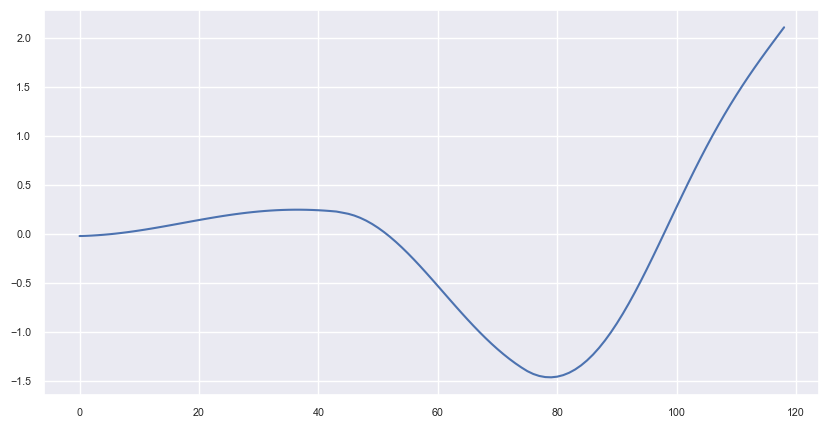

In [1086]:
#results_['action_list']
plt.figure(figsize = [10,5])
plt.plot(np.array(results_['states_list'])[1:120,0] )


In [1004]:
li = 20

x_0 = np.arange(0,li)*( eval_env_2.observation_space.high[0] - eval_env_2.observation_space.low[0])/li + eval_env_2.observation_space.low[0]

li = 5
x_1 = np.arange(0,li)*( eval_env_2.observation_space.high[1] - eval_env_2.observation_space.low[1])/li + eval_env_2.observation_space.low[1]


x_ = np.array([i for i in 
    np.stack([np.digitize(np.array(results_['states_list'])[:,0], x_0, right=False), np.digitize(np.array(results_['states_list'])[:,1], x_1, right=False)
             ]).T])


x_base = np.array(list(map(tuple,x_)))
x_ = np.array(list(map(str,map(tuple,x_))))



In [888]:
x_[ind].shape

(118,)

In [886]:
np.arange(t,200+t)[np.arange(len(ind[ind]))]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117])

In [835]:
np.array(results_['rew_list'])[np.array(results_['episode_steps']) == i][j,0,:][np.arange(120),
                        np.array(results_['action_list'])[np.array(results_['episode_steps']) == i]]

array([ 4.3086314 ,  3.6565306 ,  3.271414  ,  2.5909665 ,  2.1389868 ,
        1.4738976 ,  1.1663452 ,  1.0399421 ,  0.9577077 ,  0.75893766,
        0.4792079 ,  0.4534749 ,  0.27192143,  0.2843314 ,  0.17777109,
       -0.11584012,  0.01813122, -0.23905426, -0.2579928 , -0.3966749 ,
       -0.4357606 , -0.49179772, -0.55481094, -0.65156984, -0.68274665,
       -0.5471913 , -0.63826865, -0.6575636 , -0.7047265 , -0.6900391 ,
       -0.6434264 , -0.7210487 , -0.80803853, -0.7519348 , -0.76969683,
       -0.91409916, -0.8514171 , -0.8357318 , -0.78260237, -0.8892317 ,
       -1.0029079 , -1.086934  , -0.96663576, -1.0420942 , -1.0625873 ,
       -1.0233427 , -1.1036962 , -1.1882817 , -0.9948835 , -1.0575589 ,
       -1.0991286 , -1.0076615 , -1.0295589 , -1.1515719 , -0.9344697 ,
       -1.0909036 , -0.90015596, -0.9985338 , -0.97500294, -1.0361618 ,
       -1.0533814 , -1.0859073 , -1.1127962 , -1.1154597 , -1.0794005 ,
       -1.0586342 , -0.98945266, -1.1795882 , -1.160869  , -1.13

array([ 4.3086314 ,  3.6565306 ,  3.271414  ,  2.5909665 ,  2.1389868 ,
        1.4738976 ,  1.1663452 ,  1.0399421 ,  0.9577077 ,  0.75893766,
        0.4792079 ,  0.4534749 ,  0.27192143,  0.2843314 ,  0.17777109,
       -0.11584012,  0.01813122, -0.23905426, -0.2579928 , -0.3966749 ,
       -0.4357606 , -0.49179772, -0.55481094, -0.65156984, -0.68274665,
       -0.5471913 , -0.63826865, -0.6575636 , -0.7047265 , -0.6900391 ,
       -0.6434264 , -0.7210487 , -0.80803853, -0.7519348 , -0.76969683,
       -0.91409916, -0.8514171 , -0.8357318 , -0.78260237, -0.8892317 ,
       -1.0029079 , -1.086934  , -0.96663576, -1.0420942 , -1.0625873 ,
       -1.0233427 , -1.1036962 , -1.1882817 , -0.9948835 , -1.0575589 ,
       -1.0991286 , -1.0076615 , -1.0295589 , -1.1515719 , -0.9344697 ,
       -1.0909036 , -0.90015596, -0.9985338 , -0.97500294, -1.0361618 ,
       -1.0533814 , -1.0859073 , -1.1127962 , -1.1154597 , -1.0794005 ,
       -1.0586342 , -0.98945266, -1.1795882 , -1.160869  , -1.13

In [864]:
np.array(results_['action_list'])[np.array(results_['episode_steps']) == i]
np.array(results_['rew_list'])[ind][j,0,np.arange(len(ind[ind]))][np.array(results_['action_list'])[ind]]
np.array(results_['rew_list'])[ind][j,0,np.arange(len(ind[ind])),].shape

(118, 3)

In [874]:

plt.figure(figsize =[15,5])
for i in np.unique(results_['episode_steps']):
    ind = np.array(results_['episode_steps']) == i
    for j in np.array(results_['time_step'])[np.array(results_['episode_steps'])==i]:
        t = 0
        if j>200:
            t = j-200
            
        plt.plot(np.arange(t,200+t)[np.arange(len(ind[ind]))],np.array(results_['states_list'])[ind][j,0][np.arange(len(ind[ind])),np.array(results_['action_list'])[ind]],alpha =0.05)

IndexError: invalid index to scalar variable.

<Figure size 1500x500 with 0 Axes>

In [924]:
#results_['states_list']
x_h = x_[ind]
x_h_2 = sorted([tuple(list(k)+[l]) for l,k in enumerate(x_base[ind]) ])
ind_2 = np.array([k[2] for k in  x_h_2])
x_h_3 = [k[:2] for k in  x_h_2]

In [946]:
np.array(results_['action_list'])[ind][ind_2].shape

(123,)

In [952]:
np.array(results_['rew_list'])[ind][j,0][ind_2,np.array(results_['action_list'])[ind][ind_2]].shape

(123,)

In [985]:
[ str(i) for i in product(range(11),range(6))]

['(0, 0)',
 '(0, 1)',
 '(0, 2)',
 '(0, 3)',
 '(0, 4)',
 '(0, 5)',
 '(1, 0)',
 '(1, 1)',
 '(1, 2)',
 '(1, 3)',
 '(1, 4)',
 '(1, 5)',
 '(2, 0)',
 '(2, 1)',
 '(2, 2)',
 '(2, 3)',
 '(2, 4)',
 '(2, 5)',
 '(3, 0)',
 '(3, 1)',
 '(3, 2)',
 '(3, 3)',
 '(3, 4)',
 '(3, 5)',
 '(4, 0)',
 '(4, 1)',
 '(4, 2)',
 '(4, 3)',
 '(4, 4)',
 '(4, 5)',
 '(5, 0)',
 '(5, 1)',
 '(5, 2)',
 '(5, 3)',
 '(5, 4)',
 '(5, 5)',
 '(6, 0)',
 '(6, 1)',
 '(6, 2)',
 '(6, 3)',
 '(6, 4)',
 '(6, 5)',
 '(7, 0)',
 '(7, 1)',
 '(7, 2)',
 '(7, 3)',
 '(7, 4)',
 '(7, 5)',
 '(8, 0)',
 '(8, 1)',
 '(8, 2)',
 '(8, 3)',
 '(8, 4)',
 '(8, 5)',
 '(9, 0)',
 '(9, 1)',
 '(9, 2)',
 '(9, 3)',
 '(9, 4)',
 '(9, 5)',
 '(10, 0)',
 '(10, 1)',
 '(10, 2)',
 '(10, 3)',
 '(10, 4)',
 '(10, 5)']

In [1023]:
state_list = list(map(str, list(product(range(21),range(6)))))

In [1028]:
freq_table  = pd.DataFrame(np.zeros((len(state_list),len(state_list)),dtype = int), index = state_list, columns =state_list)


In [ ]:
224


df.loc[~(df==0).all(axis=1)]

In [1029]:
for i in np.unique(results_['episode_steps']):
    ind = np.array(results_['episode_steps']) == i
    x_h = x_[ind]
    for j,k in (zip(x_h[:-1],x_h[1:])):
        freq_table.loc[j,k] +=1
        
        
#results_['states_list']

<Axes: >

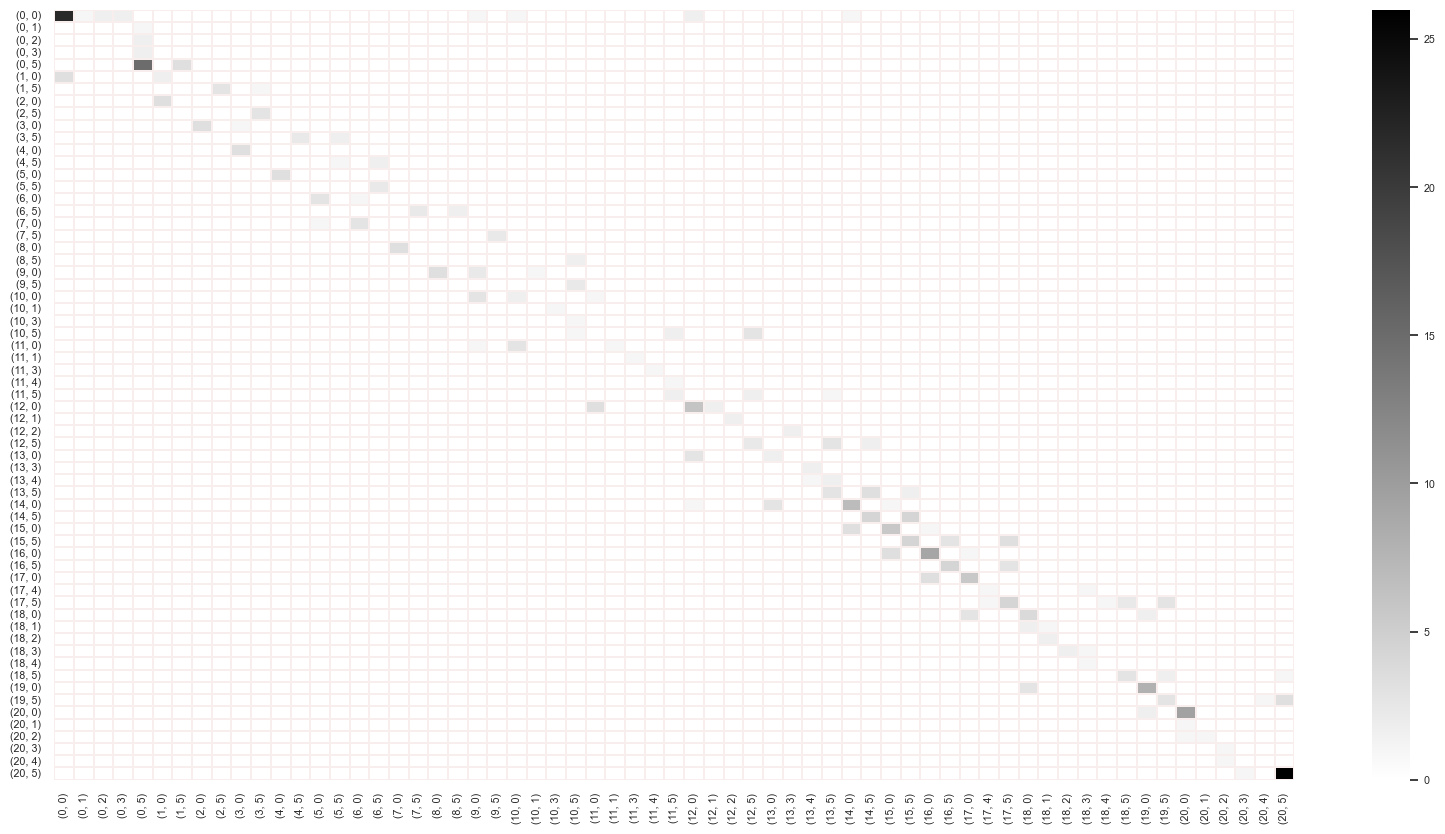

In [1082]:
import seaborn as sns
sns.set(font_scale=0.7)
fig, ax = plt.subplots(1,figsize =[20,10])
sns.heatmap(freq_table.loc[~(freq_table==0).all(axis=1), ~(freq_table==0).all(axis=1)]**0.75,cmap='binary',ax= ax,linewidths=0.01, linecolor='#F7EEED')
#ax.set_fontsize(5)

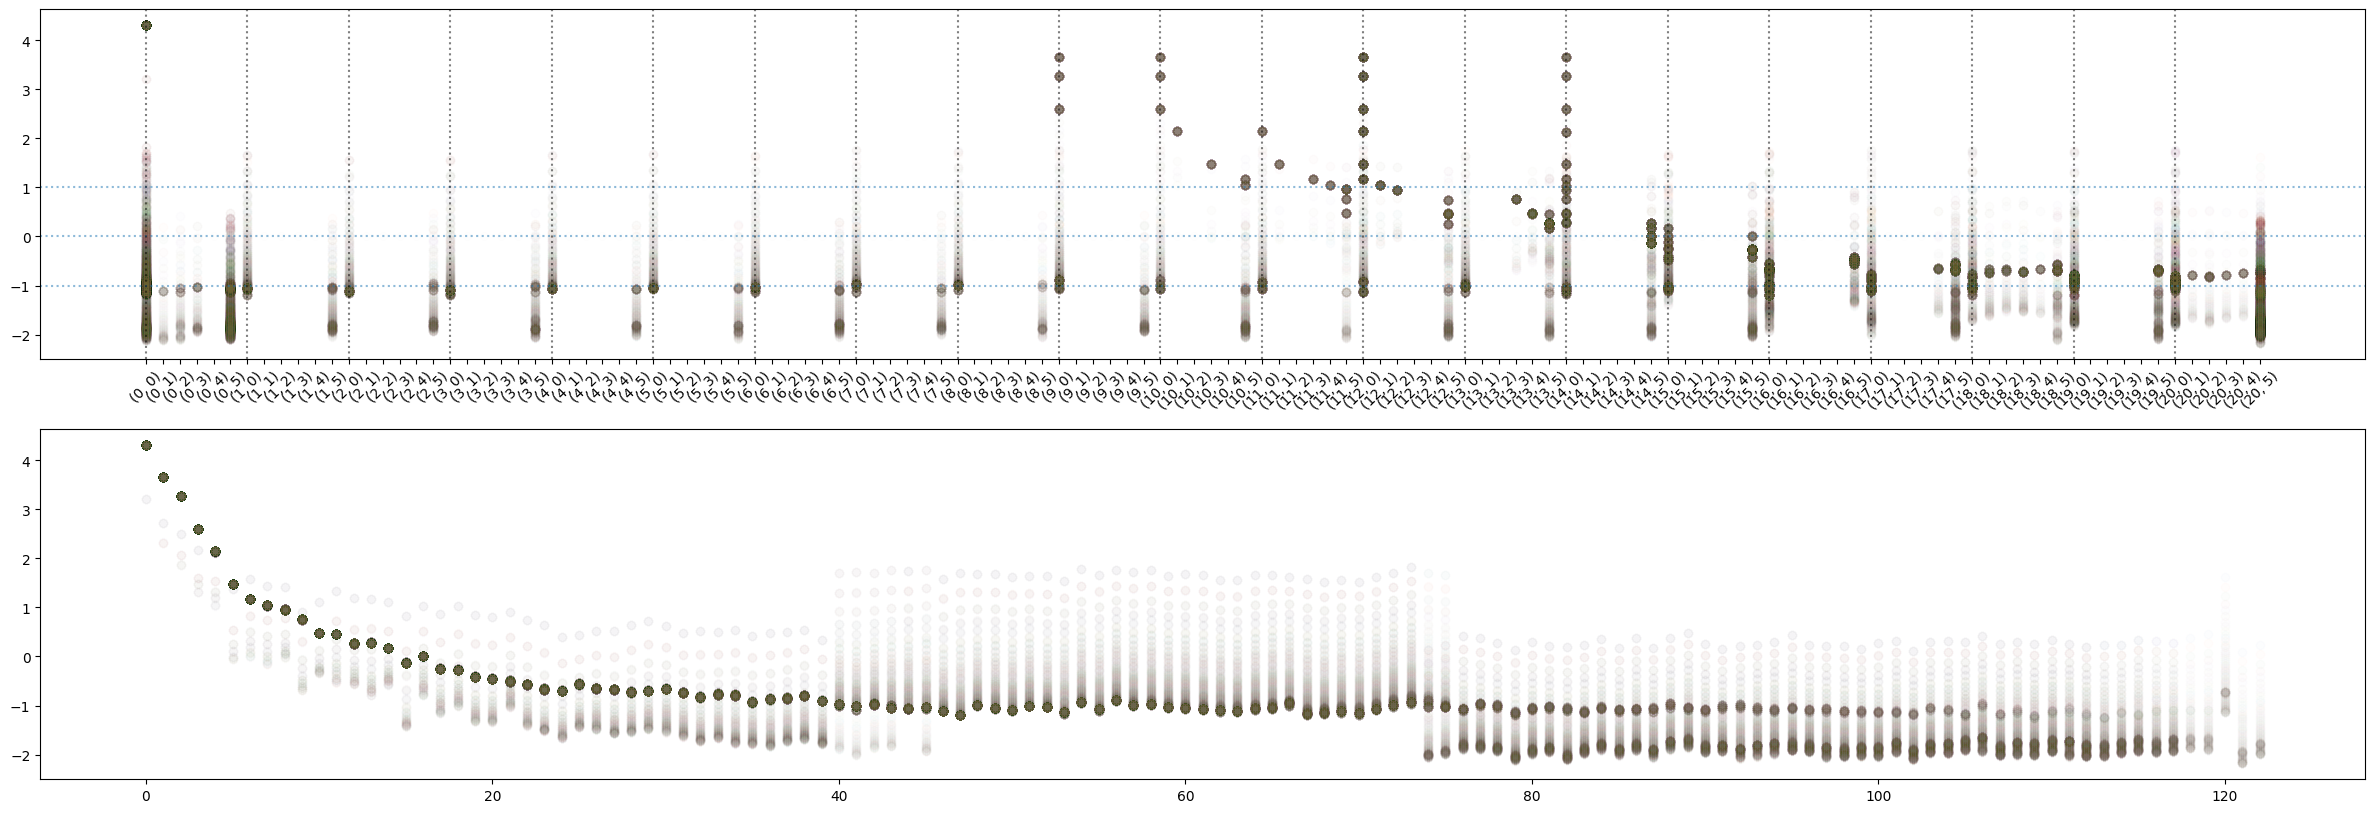

In [1008]:
fig, ax = plt.subplots(2,figsize =[30,10])
ax[0].scatter( [ str(i) for i in product(range(21),range(6))], [ 0 for i in product(range(21),range(6))]   ,alpha =0.005)
ax[0].axhline(0, linestyle = ':',alpha =0.5)
ax[0].axhline(1, linestyle = ':',alpha =0.5)
ax[0].axhline(-1, linestyle = ':',alpha =0.5)
for i in range(21):
    ax[0].axvline(str((i,0)), linestyle = ':',c = 'black',alpha =0.5)




#fig, ax = plt.subplots(figsize =[25,5])
for i in np.unique(results_['episode_steps']):
    ind = np.array(results_['episode_steps']) == i
    x_h = x_[ind]
    x_h_2 = sorted([tuple(list(k)+[l]) for l,k in enumerate(x_base[ind]) ])
    ind_2 = np.array([k[2] for k in  x_h_2])
    x_h_3 = [str(k[:2]) for k in  x_h_2]
    for j in np.array(results_['time_step'])[np.array(results_['episode_steps'])==i]:
        t = 0
        if j>200:
            t = j-200

        
        y_1 = np.array(results_['rew_list'])[ind][j,0][ind_2,np.array(results_['action_list'])[ind][ind_2]]
        #ax[0].scatter(x_h,np.array(results_['rew_list'])[ind][j,0][np.arange(len(ind[ind])),np.array(results_['action_list'])[ind]],alpha =0.005)
        #print(len(x_h_3),len(y_1))
        ax[0].scatter( x_h_3, y_1    ,alpha =0.01)
        
        x_h2 =  np.arange(t,200+t)[np.arange(len(ind[ind]))]   
        ax[1].scatter(x_h2,np.array(results_['rew_list'])[ind][j,0][np.arange(len(ind[ind])),np.array(results_['action_list'])[ind]],alpha =0.01)


ax[0].tick_params(axis='x', labelrotation=45)
#ax[0].set_xticklabels(rotation=45)

In [704]:
torch.round(results_['rew_list'][k],decimals=2).squeeze().shape

torch.Size([200, 3])

In [529]:
results_['rew_list'][k].squeeze()[np.arange(len(results_['action_list'])),results_['action_list'][:]]

tensor([ 0.0307,  0.0215,  0.0053,  0.0297,  0.0105,  0.0367,  0.0861,  0.0349,
        -0.0373, -0.0122,  0.0120,  0.0126,  0.0247,  0.0172, -0.0035,  0.0159,
         0.0034,  0.0034, -0.0023,  0.0112,  0.0139,  0.0290,  0.0197,  0.0192,
         0.0231,  0.0164,  0.0397,  0.0289,  0.0151,  0.0235,  0.0263,  0.0130,
         0.0233,  0.0416,  0.0499,  0.0640,  0.0716,  0.0276,  0.0336,  0.0321,
         0.0540,  0.0430,  0.0091, -0.0049,  0.0178, -0.0086,  0.0152,  0.0210,
         0.0892,  0.0454,  0.0027,  0.0058, -0.0147, -0.0088,  0.0045,  0.0429,
         0.0248,  0.0140,  0.0218, -0.0011, -0.0314, -0.0133, -0.0035,  0.0026,
        -0.0099, -0.0306, -0.0392,  0.0057,  0.0013, -0.0112,  0.0037,  0.0197,
         0.0138,  0.0054, -0.0072, -0.0171,  0.0109,  0.0280,  0.0548,  0.0689,
         0.0734,  0.0468,  0.0388,  0.0384,  0.0446,  0.0266,  0.0348,  0.0439,
         0.0608,  0.0660, -0.0005,  0.0246,  0.0004, -0.0058, -0.0004, -0.0008,
        -0.0099, -0.0226,  0.0250,  0.00

In [582]:
torch.round(results_['rew_list'][k],decimals=2).squeeze().shape

torch.Size([200, 3])

In [726]:
list(zip([0]+results_['len_ep'],results_['len_ep']))
#results_['running_rtg_list']

[(0, 112)]

In [599]:
index_list.shape, np.array(results_['action_list']).shape,index_list
x_.shape

(2753,)

In [649]:
results_['len_ep']

[119,
 117,
 118,
 118,
 118,
 118,
 117,
 120,
 114,
 207,
 118,
 220,
 117,
 118,
 120,
 115,
 208,
 216,
 117,
 118]

In [708]:
len(results_['action_list']),results_['rew_list'][k].shape

(2687, torch.Size([1, 200, 3]))

In [711]:


torch.round(results_['rew_list'][k],decimals=2).squeeze()[np.arange(context_len_2),results_['action_list'][ind:context_len_2+ind]].shape, action.shape

(torch.Size([200]), ())

In [697]:
x_[0:100]#[k]
x_[ind:(ind_2+ ind)][k],ind,ind_2+ind,len(results_['rew_list'])
torch.round(results_['rew_list'][k],decimals=2).shape

torch.Size([1, 200, 3])

<Axes: xlabel='state'>

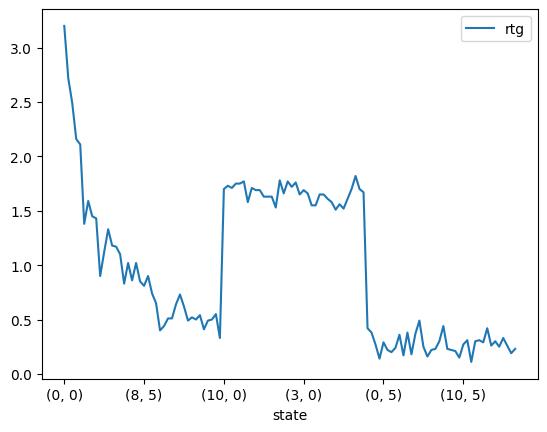

In [761]:
#(results_['action_list'][ind:context_len_2+ ind])
import pandas as pd
pd.DataFrame({'rtg':y,'state':x}).plot(x='state',y='rtg')

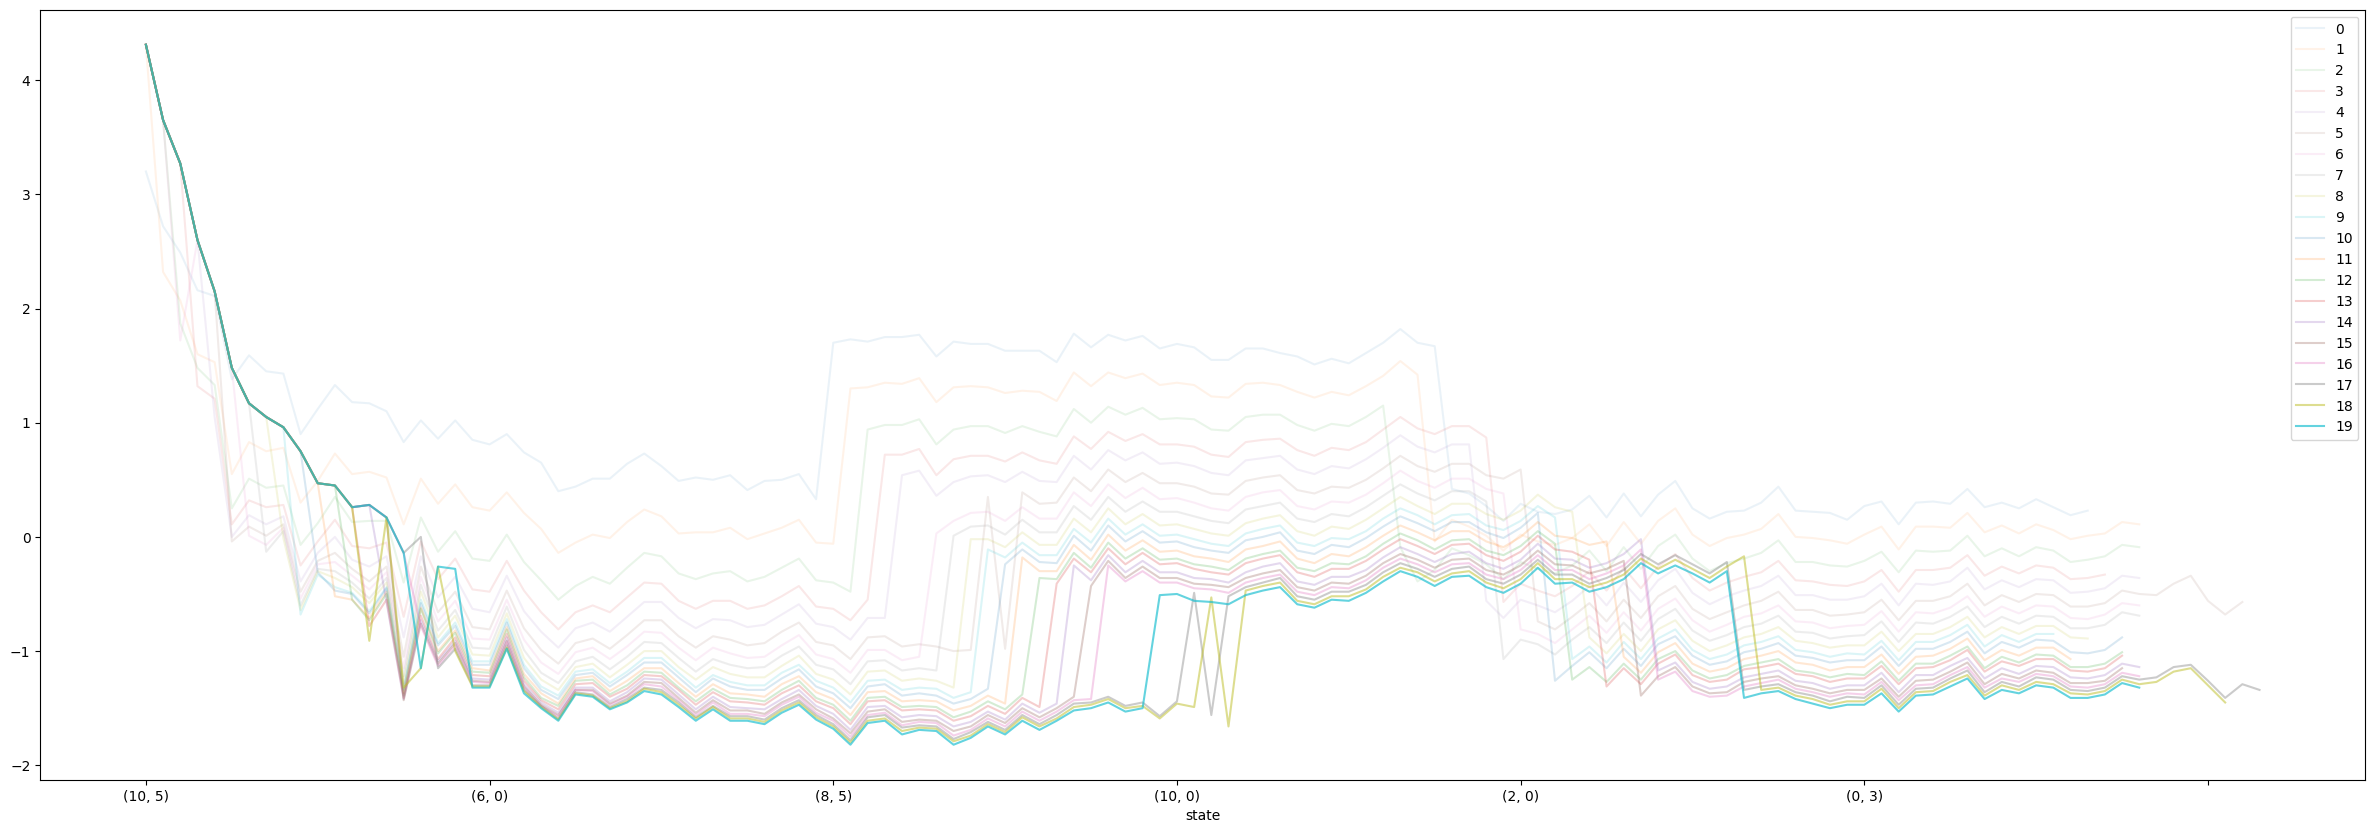

In [776]:
fig, ax = plt.subplots(figsize = [30,10])



ind = 0
for k in range(20):
    ind_2 = results_['len_ep'][k] 
    
    
    #print(x_[ind:ind_2+ind],ind,ind_2+ind,k)
    #index_list = np.array(x).argsort(axis =0).tolist()
    #index_list = np.array(index_list)
    #x=x_[index_list]
    #y = torch.round(results_['rew_list'][k],decimals=2).squeeze()[np.arange(ind_2),results_['action_list'][ind:ind_2+ind]]#[index_list]

    context_len_2 = min(results_['rew_list'][k].shape[1],ind_2)
    x = x_[ind:context_len_2+ind]#[k]
    action = results_['action_list'][ind:context_len_2+ ind][k]
    #y = torch.round(results_['rew_list'][k],decimals=2)[0,k]
    
    y = torch.round(results_['rew_list'][k],decimals=2).squeeze()[np.arange(context_len_2),results_['action_list'][ind:context_len_2+ind]]#[index_list]
    ind = ind_2+ ind

    pd.DataFrame({'rtg':y,'state':x}).plot(x='state',y='rtg',kind='line',ax =ax,alpha=1/(11-k/2),label=k)
    #plt.plot(
        
    #    y = y,#.numpy(),
    #    x = x#[index_list]
        
    #)

In [783]:
results_.keys()

dict_keys(['eval/avg_reward', 'eval/avg_ep_len', 'rew_list', 'actual_reward', 'states_list', 'action_list', 'running_rtg_list', 'len_ep'])

In [781]:
np.array(results_['states']).shape

KeyError: 'states'

In [784]:
np.array(results_['states_list']).shape

(2357, 2)

In [635]:
#results_['actual_reward']
#results_['rew_list'][-1].shape


2

In [630]:
plt.figure(figsize = [25,5])

x=x_#[index_list]

y = torch.round(results_['rew_list'][-1],decimals=2).squeeze()[np.arange(len(results_['action_list'])),results_['action_list'][:]]#[index_list]

plt.scatter(
    
    y = y.numpy(),
    x = x
    
)

IndexError: index 200 is out of bounds for dimension 0 with size 200

<Figure size 2500x500 with 0 Axes>

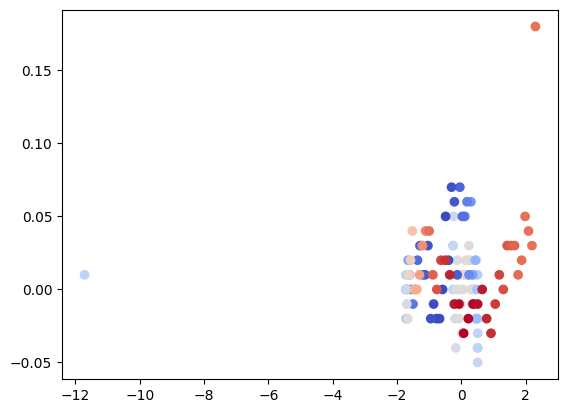

In [476]:
plt.scatter(
            np.array(results_['states_list'])[:,0],
            torch.round(results_['rew_list'][-1],decimals=2).squeeze()[np.arange(len(results_['action_list'])),results_['action_list'][:]]
            ,
            
            c = np.array(results_['states_list'])[:,1], cmap ='coolwarm'
           
           )

In [374]:
np.array(results_['states_list'])[:,1]

array([-0.19680892, -0.1621432 , -0.12773713, -0.0938485 , -0.06073147,
       -0.02863464,  0.002201  ,  0.03154411,  0.05917522,  0.08488893,
        0.10849621,  0.12982656,  0.1487301 ,  0.16507953,  0.1787715 ,
        0.18972807,  0.19789729,  0.20325358,  0.20579746,  0.20555472,
        0.20257519,  0.19693096,  0.18871418,  0.17803474,  0.16501763,
        0.1498    ,  0.13252863,  0.11335725,  0.09244403,  0.06994949,
        0.04603454,  0.02085907, -0.00541929, -0.03264595, -0.06066969,
       -0.08934291, -0.11852134, -0.14806361, -0.17783064, -0.26871592,
       -0.35926998, -0.4490647 , -0.5376504 , -0.62454593, -0.70923114,
       -0.79114264, -0.8696742 , -0.94418204, -1.0139959 , -1.0784354 ,
       -1.1368325 , -1.1885575 , -1.2330482 , -1.2698394 , -1.2985901 ,
       -1.3191061 , -1.3313553 , -1.3354735 , -1.3317612 , -1.3206702 ,
       -1.3027822 , -1.2787813 , -1.2494227 , -1.2155007 , -1.1778185 ,
       -1.1371609 , -1.0942715 , -1.049837  , -1.0044738 , -0.95

In [357]:
np.array((results_['rew_list']))[-1].squeeze()[:]

array([-1.57287866e-01,  2.58929640e-01,  8.25066343e-02,  5.34021482e-02,
       -1.23732902e-01, -2.73151636e-01,  3.09541762e-01, -3.38973179e-02,
        1.43820703e-01,  2.06869468e-02, -1.41847670e-01,  5.14170289e-01,
       -4.69430014e-02,  7.76794329e-02, -7.32062012e-03, -1.55541331e-01,
        1.90300107e-01, -5.45038521e-01,  2.76004896e-02, -3.41589540e-01,
        1.97535172e-01, -3.56307060e-01,  2.24608064e-01,  6.03496209e-02,
        4.77751866e-02, -4.61240858e-01, -8.07463601e-02, -2.88928181e-01,
       -4.73071128e-01, -1.02744244e-01, -2.04011112e-01,  2.93262750e-01,
        3.55367750e-01,  1.23978652e-01,  1.00108199e-01, -4.08739954e-01,
       -5.03757000e-01, -3.87187123e-01, -2.10317671e-01, -4.30827945e-01,
       -4.14984703e-01, -4.03864160e-02,  9.40258279e-02, -5.28841555e-01,
       -4.57950383e-01, -4.44874734e-01, -7.16404855e-01, -5.02104044e-01,
       -5.14447331e-01, -4.43346888e-01, -8.63783240e-01, -4.12381381e-01,
        6.02066517e-01, -

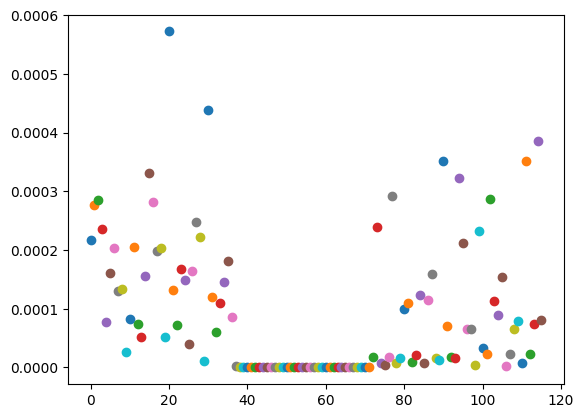

In [375]:

for i in range(len(results_['rew_list'])-1):
    plt.scatter(i, F.mse_loss(torch.tensor(np.array((results_['rew_list']))[i].squeeze()[:]),
                    torch.tensor(np.array((results_['rew_list']))[i+1].squeeze()[:])))

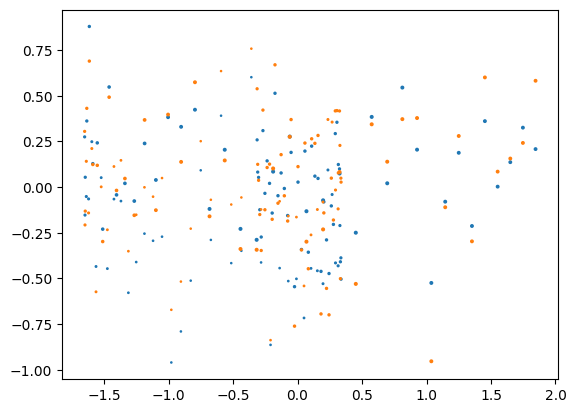

In [351]:
plt.scatter(np.array(results_['states_list'])[1:,0],np.array((results_['rew_list']))[-1].squeeze()[1:len(results_['states_list'])], np.array(results_['states_list'])[1:,1]+2 )
plt.scatter(np.array(results_['states_list'])[1:,0],np.array((results_['rew_list']))[0].squeeze()[1:len(results_['states_list'])],  np.array(results_['states_list'])[1:,1]+2)

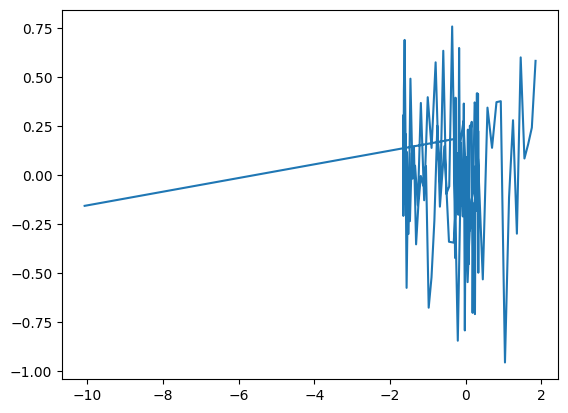

In [342]:
plt.plot(np.array(results_['states_list'])[:,0],np.array((results_['rew_list']))[1].squeeze()[:len(results_['states_list'])])




In [303]:
len(results_['rew_list'])

114

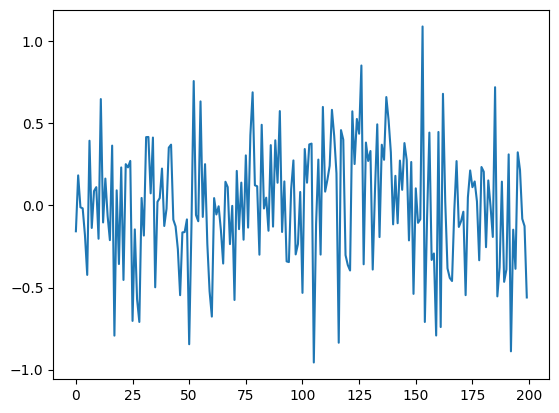

In [301]:
plt.plot(np.array((results_['rew_list']))[1].squeeze())

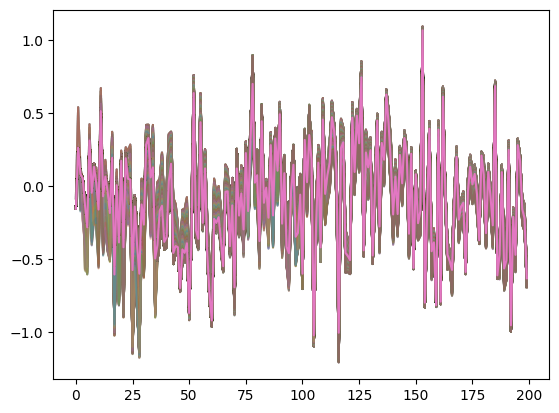

In [292]:
import  matplotlib.pyplot as plt
plt.plot(np.array((results_['rew_list'])).squeeze().T,alpha = 0.25)
plt.plot(np.array((results_['rew_list'])).squeeze().T.mean(axis=1),alpha = 1)

# test

In [148]:

# set mujoco env path if not already set
#%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin


eval_dataset = ""		# medium / medium-replay / medium-expert
eval_rtg_scale = 1		# normalize returns to go

eval_env_name = env_name#"CartPole-v1"
eval_rtg_target = 5000
eval_env_d4rl_name = env_name#'CartPole-v1'



num_test_eval_ep = 10			# num of evaluation episodes
eval_max_eval_ep_len = 1000		# max len of one episode


context_len = 20        # K in decision transformer
n_blocks = 3            # num of transformer blocks
embed_dim = 128         # embedding (hidden) dim of transformer
n_heads = 1             # num of transformer heads
dropout_p = 0.1         # dropout probability


eval_chk_pt_dir = "./dt_runs/"

#Documents/Projects/multiagent research/dt_runs/dt_CartPole-v1_model_24-05-13-00-13-40_best.pt
eval_chk_pt_name = 'dt_MountainCar-v0_model_24-05-13-15-07-23.pt'#'dt_CartPole-v1_model_24-05-13-00-32-30_best.pt'
eval_chk_pt_list = [eval_chk_pt_name]


## manually override check point list
## passing a list will evaluate on all checkpoints
## and output mean and std score


# eval_chk_pt_list = [
# 	"dt_walker2d-medium-v2_model_22-02-20-06-27-12_best.pt",
# 	"dt_walker2d-medium-v2_model_22-02-20-09-11-30_best.pt",
# 	"dt_walker2d-medium-v2_model_22-02-22-09-24-12_best.pt"
# ]


#env_data_stats = get_d4rl_dataset_stats(eval_env_d4rl_name)
#state mean:  [0.31123659014701843, 0.30185556411743164, 0.029100451618433, 0.02120562456548214]
#state std:  [0.6855536103248596, 0.7185616493225098, 0.07947435975074768, 0.40452462434768677]

eval_state_mean =np.array(state_mean.tolist()) #np.array(env_data_stats['state_mean'])
eval_state_std = np.array(state_std.tolist())#np.array(env_data_stats['state_std'])

eval_env = gym.make(eval_env_name, render_mode='rgb_array')

state_dim = eval_env.observation_space.shape[0]
act_dim = 3#eval_env.action_space.shape[0]

all_scores = []

for eval_chk_pt_name in eval_chk_pt_list:

	eval_model = DecisionTransformer(
				state_dim=state_dim,
				act_dim=act_dim,
				n_blocks=n_blocks,
				h_dim=embed_dim,
				context_len=context_len,
				n_heads=n_heads,
				drop_p=dropout_p,
			).to(device)


	eval_chk_pt_path = os.path.join(eval_chk_pt_dir, eval_chk_pt_name)

	# load checkpoint
	eval_model.load_state_dict(torch.load(eval_chk_pt_path, map_location=device))

	print("model loaded from: " + eval_chk_pt_path)

	# evaluate on env
	results = evaluate_on_env(eval_model, device, context_len,
							eval_env, eval_rtg_target, eval_rtg_scale,
							num_test_eval_ep, eval_max_eval_ep_len,
							eval_state_mean, eval_state_std)
	#print(results)

	norm_score = results['eval/avg_reward']*100#get_d4rl_normalized_score(results['eval/avg_reward'], eval_env_name) * 100
	print("normalized d4rl score: ", norm_score)

	all_scores.append(norm_score)

print("=" * 60)
all_scores = np.array(all_scores)
print("evaluated on env: " + eval_env_name)
print("total num of checkpoints evaluated: " + str(len(eval_chk_pt_list)))
print("d4rl score mean: " + format(all_scores.mean(), ".5f"))
print("d4rl score std: " + format(all_scores.std(), ".5f"))
print("d4rl score var: " + format(all_scores.var(), ".5f"))
print("=" * 60)




model loaded from: ./dt_runs/dt_MountainCar-v0_model_24-05-13-15-07-23.pt
normalized d4rl score:  -14410.0
evaluated on env: MountainCar-v0
total num of checkpoints evaluated: 1
d4rl score mean: -14410.00000
d4rl score std: 0.00000
d4rl score var: 0.00000


# render env

In [149]:
class Recorder_3(gym.Wrapper):
    def __init__(self, env, directory, auto_release=True, size=None, fps=None):
        super().__init__(env)
        #setattr(self.env,'render_mode', 'rgb_array')
        self.directory = directory
        self.auto_release = auto_release
        self.active = True

        if not os.path.exists(self.directory):
            os.mkdir(self.directory)

        if size is None:
            self.env.reset()
            self.size = self.env.render().shape[:2][::-1]
        else:
            self.size = size

        if fps is None:
            if 'video.frames_per_second' in self.env.metadata:
                self.fps = self.env.metadata['video.frames_per_second']
            else:
                self.fps = 30
        else:
            self.fps = fps

    def pause(self):
        self.active = False

    def resume(self):
        self.active = True

    def _start(self):
        self.cliptime = time.time()
        self.path = f'{self.directory}/{self.cliptime}.mp4'
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        self._writer = cv2.VideoWriter(self.path, fourcc, self.fps, self.size)

    def _write(self):
        if self.active:
            frame = self.env.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            self._writer.write(frame)

    def release(self):
        self._writer.release()

    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        self._start()
        self._write()
        return observation

    def step(self, *args, **kwargs):
        data = self.env.step(*args, **kwargs)
        self._write()

        if self.auto_release and data[2]:
            self.release()

        return data

    def play(self):
        start = time.time()
        filename = 'temp-{start}.mp4'
        clip = VideoFileClip(self.path)
        clip.write_videofile(filename, progress_bar = False, verbose = False)
        display(Video(filename, embed = True))
        os.remove(filename)

In [150]:

#from colabgymrender.recorder import Recorder

num_test_eval_ep = 1
eval_max_ep_len = 1000


directory = "./render_video"

#setattr(eval_env,'render_mode', 'rgb_array')

eval_env = Recorder_3(eval_env, directory)

results = evaluate_on_env(eval_model, device, context_len, 
                        eval_env, eval_rtg_target, eval_rtg_scale, 
                        num_test_eval_ep, eval_max_ep_len,
						eval_state_mean, eval_state_std)
#print(results)

norm_score = results['eval/avg_reward']*100#get_d4rl_normalized_score(results['eval/avg_reward'], eval_env_name) * 100
print("normalized d4rl score: ", norm_score)

#eval_env.play()

eval_env.close()



OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


normalized d4rl score:  -15500.0


# plot

In [ ]:
import numpy as np
import pickle

import pandas as pd
import glob

import matplotlib.pyplot as plt


env_d4rl_name = "CartPole-v1"

log_dir = 'dt_runs/'

x_key = "num_updates"
y_key = "eval_d4rl_score"
y_smoothing_win = 5
plot_avg = False
save_fig = False


plt.figure(figsize=[15,5])

if plot_avg:
    save_fig_path = env_d4rl_name + "_avg.png"
else:
    save_fig_path = env_d4rl_name + ".png"


all_files = glob.glob(log_dir + f'/dt_{env_d4rl_name}*.csv')

ax = plt.gca()
ax.set_title(env_d4rl_name)

if plot_avg:
    name_list = []
    df_list = []
    for filename in all_files:
        frame = pd.read_csv(filename, index_col=None, header=0)
        print(filename, frame.shape)
        frame['y_smooth'] = frame[y_key].rolling(window=y_smoothing_win).mean() 
        df_list.append(frame)
    
    
    df_concat = pd.concat(df_list)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    data_avg.plot(x=x_key, y='y_smooth', ax=ax)
    
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend(['avg of all runs'], loc='lower right')
    
    if save_fig:
        plt.savefig(save_fig_path)
        
    plt.show()
    
    
else:
    name_list = []
    for filename in all_files:
        frame = pd.read_csv(filename, index_col=None, header=0)
        print(filename, frame.shape)
        frame['y_smooth'] = frame[y_key].rolling(window=y_smoothing_win).mean()
        frame.plot(x=x_key, y='y_smooth', ax=ax)
        name_list.append(filename.split('/')[-1])
    
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend(name_list, loc='lower right')
    
    if save_fig:
        plt.savefig(save_fig_path)
    
    plt.show()
    
